# Imports

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Tuple, Union, Sequence

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import PIL


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm
import json

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/urothel_ca')
PATH_WSIS = PATH/'Neue_Scans_Urothelkarzinome'
#PATH_ROIS = PATH/'Rois_Christoph'
PATH_ROIS = PATH/'Rois_Samir'
PATH_ROIS_ADJUSTED = PATH/'Rois_Samir_adjusted'
PATH_EXCEL_SHEET = PATH/'Data_Sheet_MIER_22112021.xlsx'


seed = 42
np.random.seed(seed)

# Data 

In [3]:
wsi_mrxs_paths = [p for p in PATH_WSIS.ls() if p.suffix == '.mrxs']
len(wsi_mrxs_paths)

239

In [4]:
wsi_dir_paths = [p for p in PATH_WSIS.ls() if p.suffix == '']
len(wsi_dir_paths)

239

In [5]:
json_paths = PATH_ROIS.ls()
len(json_paths)

233

## get rois for each wsi path

### wsi path to json file mapping

In [6]:
def find_json_path(mrxs_path:pathlib.Path)->pathlib.Path:
    stem = mrxs_path.stem
    for jp in json_paths:
        if(jp.stem == stem):
            return jp
    return None

In [7]:
wsi_mrxs_to_json_path = {}
wsi_mrxs_paths_without_corresponding_json_file = []
for mrxs_p in wsi_mrxs_paths:
    jp = find_json_path(mrxs_path=mrxs_p)
    if(jp is not None):
        wsi_mrxs_to_json_path[mrxs_p] = jp
    else:
        wsi_mrxs_paths_without_corresponding_json_file.append(mrxs_p)

In [8]:
len(wsi_mrxs_to_json_path)

233

In [9]:
len(wsi_mrxs_paths_without_corresponding_json_file)

6

### custom function that creates PolygonHelper objects from a given json file with the roi coordinates

In [10]:
class __PolygonHelper:
    def __init__(self, level:int, vertices:Sequence[Tuple[float, float]]):
        self.level = level
        self.vertices = vertices

def get_polygons_from_json(json_path:pathlib.Path)->List[__PolygonHelper]:
    """
    Reads the json file and returns a list of __PolygonHelper objects. 
    This should be a specialized function for the specific structure of your json files.
    
    Arguments:
        json_path: path to json file
        
    Returns:
        List of __PolygonHelper objects
    """
    polygons = []
    with open(json_path) as json_file:
        for i, annotation in enumerate(json.load(json_file)):
            #some annotations do not have a "classification" prop
            # => just skip them
            try:
                annotation["properties"]["classification"]
            except KeyError as ke:
                print(ke)
                print(f'annotation num: {i}')
                continue
                
            #skip rois that are not classified as Tumor
            if(annotation["properties"]["classification"]["name"] == "Tumor"):
                if(annotation["geometry"]["type"] == 'MultiPolygon'):
                    multi_polygon_vertices = annotation["geometry"]["coordinates"]
                    #print(f'Multi Polygon: {np.array(multi_polygon_vertices).squeeze().shape}')
                    ##QuPath produces Polygons and Multipolygons 
                    ##(see difference here: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-
                    ##multipolygon-for-shapefiles-in-qgis/225373)
                    ##This loop separates Multipolygons into individual Polygons
                    for sub_polygon_vertices in multi_polygon_vertices:
                        sub_polygon_vertices_array = np.array(sub_polygon_vertices, dtype=object).squeeze()
                        if(len(sub_polygon_vertices_array.shape) == 2 and sub_polygon_vertices_array.shape[1] == 2):
                            #print(f'/1/: {sub_polygon_vertices_array.shape}')
                            polygons.append(__PolygonHelper(level=0, vertices=sub_polygon_vertices_array))
                        else:
                            for elem in sub_polygon_vertices_array:
                                elem_array = np.array(elem).squeeze()
                                #print(f'/2/: {elem_array.shape}')
                                polygons.append(__PolygonHelper(level=0, vertices=elem_array))
                    
                elif(annotation["geometry"]["type"] == 'Polygon'):
                    vertices = annotation["geometry"]["coordinates"]
                    #print(f'/3/ len of vertices: {len(vertices)}')
                    for ls in vertices:               
                        #print(f'/4/: {np.array(ls).squeeze().shape}')
                        polygons.append(__PolygonHelper(level=0, vertices=np.array(ls, dtype=object).squeeze()))
                else:
                    assert False
    return polygons

### adjust misalligned rois because of black and white padding when mrxs files are opened by openslide

In [11]:
def is_row_black(img:Union[PIL.Image.Image, numpy.ndarray], row_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[row_num, :, :] == [0,0,0])

def is_column_black(img:Union[PIL.Image.Image, numpy.ndarray], column_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[:, column_num, :] == [0,0,0])

def get_num_of_black_rows_at_top(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_rows = 0
    while(is_row_black(img=img, row_num=n_rows)):
        n_rows += 1
    return n_rows

def get_num_of_black_columns_at_left(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_columns = 0
    while(is_column_black(img=img, column_num=n_columns)):
        n_columns += 1
    return n_columns

class Row_or_col(Enum):
    ROW = 1
    COLUMN = 2
    
def is_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], index:int, row_or_col:Row_or_col)->bool:
    """
    checks if the by index specified row or column in the image contains only [0,0,0] == black
    or [255,255,255] == white RGB values
    """
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    a = None
    if(row_or_col is Row_or_col.ROW):
        a = img[index, :, :]
    elif(row_or_col is Row_or_col.COLUMN):
        a = img[:, index, :]
    else:
        raise ValueError('row_or_col has insufficient value')
    return np.where(np.logical_and(np.ravel(a) > 0, np.ravel(a) < 255))[0].size == 0

def get_num_of_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], row_or_col:Row_or_col)->int:
    n = 0
    while(is_only_black_white(img=img, index=n, row_or_col=row_or_col)):
        n += 1
    return n

def adjust_rois(wsi_img:Union[PIL.Image.Image, numpy.ndarray], 
                wsi_img_level:int, 
                rois:List[roi.RegionOfInterestPolygon]):
    """
    returns new RegionOfInterestPolygon objects
    """
    cols_left = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.COLUMN)
    rows_top = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.ROW)
    rois_adjusted = []
    for r in rois:
        new_vertices = util.polygon_to_numpy(r.polygon)
        new_vertices += [util.adjust_level(value_to_adjust=cols_left, from_level=wsi_img_level, to_level=r.level), 
                         util.adjust_level(value_to_adjust=rows_top, from_level=wsi_img_level, to_level=r.level)]
        r_new = roi.RegionOfInterestPolygon(roi_id=r.roi_id, vertices=new_vertices, level=r.level)
        rois_adjusted.append(r_new)

    return rois_adjusted

def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def adjust_and_save_rois(wsi_path, json_path):
    print(f'wsi: {wsi_path.name}')
    print(f'json: {json_path.name}')
        
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    if(not save_path.exists()):    
        wh = tiles.WsiHandler(wsi_path=wsi_path)
        rois = roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path, 
                                        polygons_from_json_func=get_polygons_from_json)       
        rois_adjusted = adjust_rois(wsi_img=wh.get_wsi_as_pil_image(level=5), wsi_img_level=5, rois=rois)               
        save_as_pickle(rois_adjusted, save_path)
    else:
        print(f'Already exists: {save_path}')    

In [12]:
failed = []
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    try:
        roi.adjust_and_save_rois(wsi_path, json_path)
    except:
        failed.append(wsi_path)

100%|██████████| 233/233 [00:00<00:00, 378934.79it/s]


In [13]:
#no stroma rois
wsi_path_to_rois = {}
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    rois = load_pickle(save_path)
    wsi_path_to_rois[wsi_path] = rois

100%|██████████| 233/233 [00:16<00:00, 14.46it/s]


## id and label funcs

In [14]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    split = wsi_path.stem.split('_')
    return f'{split[0]}_{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    tma_nr = wsi_path.stem.split('_')[1]
    row = data_sheet.iloc[int(tma_nr)-1]
    survival_time = row['Survival Time (months)']
    recurrence_free_survival = row['Recurrence Free Survival (months)']
    return [survival_time, recurrence_free_survival]

## tiles

In [15]:
tilesummaries_save_path = Path(f'./tilesummaries/001/')
tilesummaries = []

tilesummaries_saved_names = [p.stem for p in tilesummaries_save_path.ls()]

for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
#for wsi_path in tqdm(list(failed_wsi_paths.keys())[:]):
    if(f'{wsi_path.stem}_tilesummary' in tilesummaries_saved_names):
        print(f'{wsi_path.stem} is loaded ...')
        tilesummaries.append(load_pickle(tilesummaries_save_path/f'{wsi_path.stem}_tilesummary.pickle'))
        pass
    else:
        print(f'{wsi_path.stem} tiles are calculated ...')    
        t = tiles.WsisToTilesParallel(wsi_paths=[wsi_path],
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.score_tile_1,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.95, 
                                          verbose=True, 
                                          grids_per_roi=1, 
                                          optimize_grid_angles=False)[0]
        tilesummaries.append(t)
        p = tilesummaries_save_path/f'{t.wsi_path.stem}_tilesummary.pickle'
        save_as_pickle(t, p)

  1%|          | 2/233 [00:00<00:19, 11.83it/s]

MIER_140_M17 is loaded ...
MIER_151_M3 is loaded ...
MIER_158_TUR2 is loaded ...


  2%|▏         | 4/233 [00:00<00:27,  8.40it/s]

MIER_175_M12 is loaded ...
MIER_200_M9 is loaded ...


  3%|▎         | 7/233 [00:00<00:23,  9.79it/s]

MIER_211_C is loaded ...
MIER_217_C is loaded ...
MIER_236_C is loaded ...
MIER_40_D is loaded ...


  4%|▍         | 9/233 [00:00<00:25,  8.81it/s]

MIER_52_B is loaded ...


  5%|▌         | 12/233 [00:01<00:26,  8.23it/s]

MIER_74_M10 is loaded ...
MIER_184_I is loaded ...
MIER_46_A is loaded ...


  6%|▌         | 13/233 [00:01<00:26,  8.41it/s]

MIER_134_TUR1 is loaded ...


  6%|▌         | 14/233 [00:01<00:32,  6.77it/s]

MIER_130_C is loaded ...


  7%|▋         | 17/233 [00:02<00:36,  5.87it/s]

MIER_233_TUR1 is loaded ...
MIER_127_G is loaded ...
MIER_41_A is loaded ...
MIER_115_C is loaded ...


  9%|▉         | 21/233 [00:02<00:23,  9.00it/s]

MIER_147_A is loaded ...
MIER_17_C is loaded ...
MIER_183_A is loaded ...
MIER_222_M13 is loaded ...


 10%|▉         | 23/233 [00:02<00:21,  9.97it/s]

MIER_50_A is loaded ...
MIER_79_D is loaded ...


 12%|█▏        | 27/233 [00:03<00:23,  8.72it/s]

MIER_167_L is loaded ...
MIER_187_M13 is loaded ...
MIER_145_B is loaded ...
MIER_71_H is loaded ...


 12%|█▏        | 29/233 [00:03<00:20, 10.19it/s]

MIER_6_C is loaded ...


 13%|█▎        | 31/233 [00:03<00:27,  7.43it/s]

MIER_229_TUR2 is loaded ...
MIER_154_M21 is loaded ...
MIER_8_B is loaded ...


 14%|█▍        | 33/233 [00:03<00:25,  7.97it/s]

MIER_36_A is loaded ...
MIER_22_E is loaded ...


 16%|█▌        | 37/233 [00:04<00:20,  9.58it/s]

MIER_221_C is loaded ...
MIER_70_B is loaded ...
MIER_35_F is loaded ...


 18%|█▊        | 41/233 [00:04<00:16, 11.82it/s]

MIER_142_M13 is loaded ...
MIER_29_C is loaded ...
MIER_164_C is loaded ...
MIER_225_G is loaded ...
MIER_131_B is loaded ...


 19%|█▉        | 44/233 [00:04<00:14, 13.14it/s]

MIER_91_C is loaded ...
MIER_13_C is loaded ...


 21%|██        | 48/233 [00:05<00:21,  8.68it/s]

MIER_14_A is loaded ...
MIER_201_B is loaded ...
MIER_110_TUR3 is loaded ...
MIER_117_E is loaded ...
MIER_202_G is loaded ...


 23%|██▎       | 53/233 [00:05<00:15, 11.77it/s]

MIER_182_TUR4 is loaded ...
MIER_161_B is loaded ...
MIER_107_M22 is loaded ...
MIER_51_C is loaded ...


 24%|██▍       | 57/233 [00:05<00:14, 12.19it/s]

MIER_82_TUR1 is loaded ...
MIER_95_B is loaded ...
MIER_237_M4 is loaded ...
MIER_23_G is loaded ...


 25%|██▌       | 59/233 [00:06<00:23,  7.48it/s]

MIER_199_M10 is loaded ...
MIER_15_B is loaded ...
MIER_16_B is loaded ...


 27%|██▋       | 63/233 [00:06<00:19,  8.66it/s]

MIER_26_B is loaded ...
MIER_75_B is loaded ...
MIER_85_M12 is loaded ...
MIER_156_M15 is loaded ...
MIER_189_TUR is loaded ...


 29%|██▉       | 68/233 [00:07<00:14, 11.38it/s]

MIER_170_TUR1 is loaded ...
MIER_196_D is loaded ...
MIER_190_D is loaded ...
MIER_144_TUR is loaded ...


 30%|███       | 71/233 [00:07<00:12, 12.79it/s]

MIER_206_M11 is loaded ...
MIER_128_C is loaded ...
MIER_195_A is loaded ...


 32%|███▏      | 75/233 [00:07<00:11, 13.20it/s]

MIER_223_TUR is loaded ...
MIER_11_A is loaded ...
MIER_125_B is loaded ...
MIER_109_A is loaded ...


 33%|███▎      | 77/233 [00:08<00:23,  6.75it/s]

MIER_112_TUR1 is loaded ...
MIER_108_J is loaded ...


 35%|███▌      | 82/233 [00:08<00:17,  8.48it/s]

MIER_169_TUR is loaded ...
MIER_101_TUR3 is loaded ...
MIER_235_C is loaded ...
MIER_241_M5 is loaded ...
MIER_39_D is loaded ...


 37%|███▋      | 87/233 [00:08<00:12, 11.92it/s]

MIER_100_B is loaded ...
MIER_136_A is loaded ...
MIER_218_A is loaded ...
MIER_244_A is loaded ...


 38%|███▊      | 89/233 [00:09<00:12, 11.72it/s]

MIER_193_TUR2 is loaded ...
MIER_162_TUR2 is loaded ...
MIER_7_E is loaded ...


 40%|███▉      | 93/233 [00:09<00:11, 12.07it/s]

MIER_4_A is loaded ...
MIER_73_B is loaded ...
MIER_28_E is loaded ...
MIER_3_D is loaded ...
MIER_168_M3 is loaded ...


 42%|████▏     | 98/233 [00:09<00:11, 12.10it/s]

MIER_133_B is loaded ...
MIER_163_M4 is loaded ...
MIER_62_A is loaded ...
MIER_242_TUR2 is loaded ...


 44%|████▍     | 102/233 [00:10<00:10, 12.76it/s]

MIER_63_M17 is loaded ...
MIER_57_M21 is loaded ...
MIER_58_C is loaded ...


 45%|████▌     | 106/233 [00:10<00:16,  7.61it/s]

MIER_231_M11 is loaded ...
MIER_150_M16 is loaded ...
MIER_213_C is loaded ...
MIER_116_A is loaded ...


 46%|████▋     | 108/233 [00:11<00:14,  8.42it/s]

MIER_234_TUR8 is loaded ...
MIER_137_D is loaded ...
MIER_111_TUR5 is loaded ...


 47%|████▋     | 110/233 [00:11<00:13,  9.31it/s]

MIER_56_M16 is loaded ...
MIER_68_TUR2 is loaded ...


 49%|████▉     | 114/233 [00:11<00:11, 10.34it/s]

MIER_103_B is loaded ...
MIER_105_F is loaded ...
MIER_113_M16 is loaded ...
MIER_185_TUR1 is loaded ...
MIER_186_M10 is loaded ...


 51%|█████     | 119/233 [00:12<00:09, 11.60it/s]

MIER_2_B is loaded ...
MIER_207_E is loaded ...
MIER_226_A is loaded ...
MIER_228_A is loaded ...


 52%|█████▏    | 121/233 [00:12<00:09, 12.15it/s]

MIER_239_M1 is loaded ...
MIER_59_B is loaded ...


 54%|█████▎    | 125/233 [00:12<00:09, 11.50it/s]

MIER_83_M13 is loaded ...
MIER_92_TUR2 is loaded ...
MIER_55_M11 is loaded ...
MIER_66_TUR1 is loaded ...


 55%|█████▌    | 129/233 [00:12<00:08, 11.61it/s]

MIER_138_TUR is loaded ...
MIER_34_B is loaded ...
MIER_37_A is loaded ...


 57%|█████▋    | 133/233 [00:13<00:15,  6.62it/s]

MIER_42_C is loaded ...
MIER_87_M15 is loaded ...
MIER_165_B is loaded ...
MIER_20_A is loaded ...


 59%|█████▉    | 137/233 [00:14<00:10,  8.96it/s]

MIER_238_TUR2 is loaded ...
MIER_209_M16 is loaded ...
MIER_114_M21 is loaded ...
MIER_33_C is loaded ...


 61%|██████    | 141/233 [00:14<00:07, 11.95it/s]

MIER_198_A is loaded ...
MIER_179_M13 is loaded ...
MIER_97_TUR1 is loaded ...
MIER_157_M2 is loaded ...


 61%|██████▏   | 143/233 [00:14<00:07, 11.66it/s]

MIER_141_F is loaded ...
MIER_177_TUR2 is loaded ...
MIER_18_A is loaded ...


 63%|██████▎   | 147/233 [00:15<00:08, 10.26it/s]

MIER_227_E is loaded ...
MIER_159_TUR4 is loaded ...
MIER_152_TUR2 is loaded ...
MIER_27_A is loaded ...
MIER_30_A is loaded ...


 65%|██████▌   | 152/233 [00:15<00:07, 11.17it/s]

MIER_230_M12 is loaded ...
MIER_60_G is loaded ...
MIER_9_B is loaded ...


 67%|██████▋   | 156/233 [00:16<00:08,  9.57it/s]

MIER_99_TUR1 is loaded ...
MIER_129_C is loaded ...
MIER_172_F is loaded ...
MIER_173_B is loaded ...


 68%|██████▊   | 159/233 [00:16<00:06, 11.73it/s]

MIER_176_TUR is loaded ...
MIER_180_F is loaded ...
MIER_215_M18 is loaded ...
MIER_219_A is loaded ...
MIER_246_C is loaded ...


 70%|██████▉   | 162/233 [00:16<00:05, 13.09it/s]

MIER_38_G is loaded ...
MIER_61_A is loaded ...


 71%|███████   | 166/233 [00:16<00:05, 12.72it/s]

MIER_240_M16 is loaded ...
MIER_126_E is loaded ...
MIER_174_D is loaded ...
MIER_203_M13 is loaded ...


 72%|███████▏  | 168/233 [00:17<00:13,  4.67it/s]

MIER_10_A is loaded ...


 74%|███████▍  | 172/233 [00:18<00:10,  5.85it/s]

MIER_232_M10 is loaded ...
MIER_72_A is loaded ...
MIER_76_B is loaded ...
MIER_77_A is loaded ...


 76%|███████▌  | 176/233 [00:18<00:06,  8.27it/s]

MIER_102_D is loaded ...
MIER_32_A is loaded ...
MIER_84_TUR2 is loaded ...
MIER_245_TUR1 is loaded ...


 76%|███████▋  | 178/233 [00:18<00:05,  9.80it/s]

MIER_123_LK1 is loaded ...
MIER_192_D is loaded ...
MIER_67_M20 is loaded ...


 79%|███████▉  | 184/233 [00:19<00:04, 12.10it/s]

MIER_160_D is loaded ...
MIER_214_A is loaded ...
MIER_139_TUR is loaded ...
MIER_188_M14 is loaded ...
MIER_149_C is loaded ...


 80%|███████▉  | 186/233 [00:19<00:04, 10.61it/s]

MIER_45_D is loaded ...
MIER_143_TUR1 is loaded ...


 81%|████████  | 188/233 [00:19<00:03, 12.20it/s]

MIER_224_TUR3 is loaded ...
MIER_69_TUR6 is loaded ...
MIER_88_M6 is loaded ...


 82%|████████▏ | 192/233 [00:19<00:03, 12.25it/s]

MIER_90_A is loaded ...
MIER_12_A is loaded ...
MIER_124_TUR4 is loaded ...


 84%|████████▍ | 196/233 [00:19<00:02, 13.54it/s]

MIER_171_M18 is loaded ...
MIER_19_B is loaded ...
MIER_208_TUR4 is loaded ...
MIER_21_A is loaded ...


 85%|████████▍ | 198/233 [00:20<00:02, 12.85it/s]

MIER_243_TUR5 is loaded ...
MIER_43_B is loaded ...
MIER_44_B is loaded ...


 87%|████████▋ | 202/233 [00:20<00:02, 13.21it/s]

MIER_48_A is loaded ...
MIER_96_M7 is loaded ...
MIER_98_TUR2 is loaded ...


 88%|████████▊ | 204/233 [00:20<00:02, 11.69it/s]

MIER_93_M9 is loaded ...
MIER_155_A is loaded ...


 89%|████████▉ | 208/233 [00:20<00:01, 14.09it/s]

MIER_191_M2 is loaded ...
MIER_216_TUR3 is loaded ...
MIER_220_D is loaded ...
MIER_49_A is loaded ...
MIER_5_A is loaded ...


 90%|█████████ | 210/233 [00:22<00:05,  3.96it/s]

MIER_197_TUR1 is loaded ...
MIER_65_A is loaded ...


 92%|█████████▏| 214/233 [00:22<00:03,  5.71it/s]

MIER_81_TUR1 is loaded ...
MIER_212_M10 is loaded ...
MIER_146_B is loaded ...


 93%|█████████▎| 216/233 [00:22<00:02,  6.89it/s]

MIER_181_M10 is loaded ...
MIER_24_B is loaded ...
MIER_247_M11 is loaded ...


 94%|█████████▍| 220/233 [00:23<00:01,  8.93it/s]

MIER_104_E is loaded ...
MIER_25_B is loaded ...
MIER_64_M4 is loaded ...
MIER_210_B is loaded ...


 96%|█████████▌| 223/233 [00:23<00:01,  9.81it/s]

MIER_47_C is loaded ...
MIER_204_A is loaded ...
MIER_178_TUR1 is loaded ...


 98%|█████████▊| 229/233 [00:23<00:00, 14.14it/s]

MIER_121_D is loaded ...
MIER_53_G is loaded ...
MIER_80_TUR3 is loaded ...
MIER_148_A is loaded ...
MIER_166_M21 is loaded ...
MIER_89_TUR3 is loaded ...


100%|██████████| 233/233 [00:23<00:00,  9.74it/s]

MIER_78_M17 is loaded ...
MIER_94_G is loaded ...


## patient_manager

In [16]:
patient_manager = PatientManager()

patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)

100%|██████████| 233/233 [00:42<00:00,  5.53it/s]


In [17]:
train_size = 0.7
validation_size = 0.2
test_size = 0.1

patient_manager.split(train_size=train_size, 
                      validation_size=validation_size, 
                      test_size=test_size, 
                      random_state=seed)

## data block api

In [18]:
final_size = 512
bs = 15


data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.RegressionBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

In [19]:
dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Setting up Pipeline: <lambda> -> RegressionSetup -- {'c': None}
Setting up after_item: Pipeline: Resize -- {'size': (512, 512), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


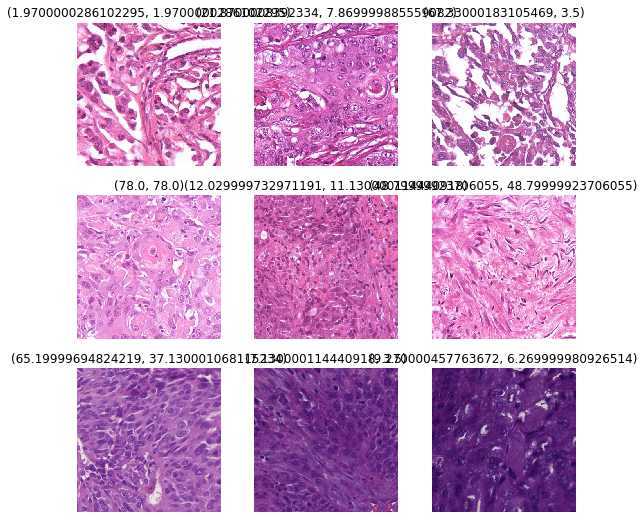

In [20]:
dls.show_batch()

# learner

## n

In [20]:
n=3

## create

In [21]:
arch = torchvision.models.resnet50

In [22]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}_regression')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/Deep_Learner/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [23]:
#learner.to_fp16()
print(learner.path)
learner.path.parent.mkdir(exist_ok=True)
learner.path.mkdir(exist_ok=True)

/home/Deep_Learner/private/datasets/urothel_ca/models/3-resnet50_regression


## name

In [24]:
epochs_frozen = 5
epochs_unfrozen = 10

In [25]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'3-resnet50'

## train

SuggestedLRs(valley=0.013182567432522774)

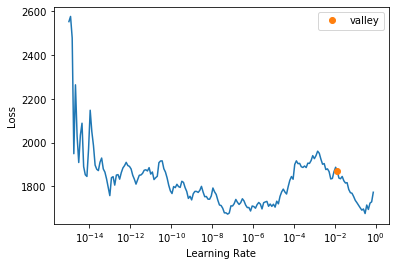

In [63]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

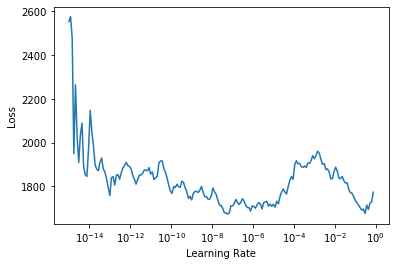

In [64]:
learner.recorder.plot_lr_find()

In [67]:
lr1 = 0.013182567432522774

In [68]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

In [77]:
pd.read_csv(learner.path/log_head_name)

epoch  train_loss    valid_loss  accuracy_multi     time
0      0  754.931824  8.308810e+04        0.908985  6:42:26
1      1  538.500305  3.929061e+05        0.896247  8:05:31
2      2  410.115997  9.959066e+05        0.910439  8:40:43
3      3  353.809906  1.043100e+06        0.914664  9:43:54
4      4  348.166168  1.388828e+04        0.908612  9:03:09

In [27]:
nameHead = f'{nameBase}-head';nameHead

'3-resnet50-head'

In [ ]:
#learner.save(nameHead)
#learner.load(nameHead)

In [78]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=1e-11, end_lr=1e-2, num_it=500)

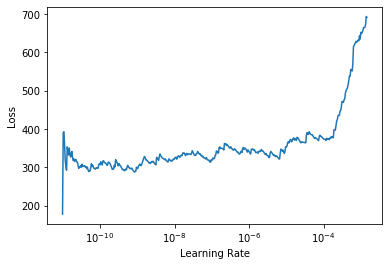

In [81]:
learner.recorder.plot_lr_find()

In [82]:
lr2 = 1e-10
lr3 = 1e-09
lr4 = 1e-08

In [83]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), SaveModelCallback(every_epoch=True, fname='complete')])

In [89]:
pd.read_csv(learner.path/log_complete_name)

epoch  train_loss    valid_loss  accuracy_multi     time
0      0  359.740082  2.739875e+04        0.906909  6:16:25
1      1  339.505280  6.777426e+05        0.913732  6:06:02
2      2  327.662231  2.523943e+06        0.913222  6:08:10
3      3  344.370148  1.441587e+06        0.905406  6:07:12
4      4  347.824768  3.051520e+04        0.907046  6:06:17
5      5  347.786133  2.267476e+06        0.912986  6:15:06
6      6  321.910675  3.824942e+06        0.911793  6:06:18
7      7  336.951385  6.961086e+05        0.915546  6:06:27
8      8  346.091522  2.164124e+06        0.910563  6:09:38
9      9  316.421448  7.549339e+05        0.912700  6:10:08

In [26]:
nameComplete = f'{nameBase}-complete'; nameComplete

'3-resnet50-complete'

In [27]:
#learner.save(nameComplete)
learner.load(nameComplete)

# prediction

In [28]:
from postprocessing.predictor import Predictor

## new predictions

In [139]:
predictor = Predictor(learner=learner, 
                      patient_manager=patient_manager, 
                      prediction_type=shared.enums.PredictionType.regression, 
                      classes=['Survival Time (months)','Recurrence Free Survival (months)'])

In [ ]:
predictor.predict_on_tiles(tile_retrieval_type=shared.enums.TileRetrievalType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, 
                          batch_size=bs)




  0%|          | 0/40235 [00:00<?, ?it/s]




  0%|          | 1/40235 [00:00<4:24:25,  2.54it/s]




  0%|          | 2/40235 [00:00<4:15:31,  2.62it/s]




  0%|          | 3/40235 [00:01<4:09:52,  2.68it/s]




  0%|          | 4/40235 [00:01<4:11:30,  2.67it/s]




  0%|          | 5/40235 [00:01<4:09:55,  2.68it/s]




  0%|          | 6/40235 [00:02<4:09:20,  2.69it/s]




  0%|          | 7/40235 [00:02<4:13:12,  2.65it/s]




  0%|          | 8/40235 [00:02<4:11:29,  2.67it/s]




  0%|          | 9/40235 [00:03<4:06:01,  2.73it/s]




  0%|          | 10/40235 [00:03<4:05:08,  2.73it/s]




  0%|          | 11/40235 [00:04<4:02:50,  2.76it/s]




  0%|          | 12/40235 [00:04<4:01:06,  2.78it/s]




  0%|          | 13/40235 [00:04<4:00:30,  2.79it/s]




  0%|          | 14/40235 [00:05<3:55:26,  2.85it/s]




  0%|          | 15/40235 [00:05<3:59:02,  2.80it/s]




  0%|          | 16/40235 [00:05<3:58:37,  2.81it/s]




  0%|          | 17/40235 [00:06<4:01:04,  2.78it/s]




  0%|          | 18/40235 [00:06<4:04:15,  2.74it/s]




  0%|          | 19/40235 [00:06<4:02:07,  2.77it/s]




  0%|          | 20/40235 [00:07<4:00:27,  2.79it/s]




  0%|          | 21/40235 [00:07<3:59:52,  2.79it/s]




  0%|          | 22/40235 [00:07<3:58:55,  2.81it/s]




  0%|          | 23/40235 [00:08<3:57:46,  2.82it/s]




  0%|          | 24/40235 [00:08<3:56:28,  2.83it/s]




  0%|          | 25/40235 [00:09<4:00:09,  2.79it/s]




  0%|          | 26/40235 [00:09<4:03:30,  2.75it/s]




  0%|          | 27/40235 [00:09<4:10:20,  2.68it/s]




  0%|          | 28/40235 [00:10<4:10:29,  2.68it/s]




  0%|          | 29/40235 [00:10<4:07:45,  2.70it/s]




  0%|          | 30/40235 [00:10<4:08:04,  2.70it/s]




  0%|          | 31/40235 [00:11<4:08:29,  2.70it/s]




  0%|          | 32/40235 [00:11<4:07:18,  2.71it/s]




  0%|          | 33/40235 [00:12<4:07:46,  2.70it/s]




  0%|          | 34/40235 [00:12<4:08:28,  2.70it/s]




  0%|          | 35/40235 [00:12<4:09:37,  2.68it/s]




  0%|          | 36/40235 [00:13<4:05:33,  2.73it/s]




  0%|          | 37/40235 [00:13<3:58:48,  2.81it/s]




  0%|          | 38/40235 [00:13<3:52:19,  2.88it/s]




  0%|          | 39/40235 [00:14<3:49:08,  2.92it/s]




  0%|          | 40/40235 [00:14<3:51:52,  2.89it/s]




  0%|          | 41/40235 [00:14<3:58:01,  2.81it/s]




  0%|          | 42/40235 [00:15<3:53:24,  2.87it/s]




  0%|          | 43/40235 [00:15<4:48:27,  2.32it/s]




  0%|          | 44/40235 [00:16<5:40:45,  1.97it/s]




  0%|          | 45/40235 [00:17<6:22:48,  1.75it/s]




  0%|          | 46/40235 [00:17<6:44:40,  1.66it/s]




  0%|          | 47/40235 [00:18<6:29:29,  1.72it/s]




  0%|          | 48/40235 [00:18<5:46:37,  1.93it/s]




  0%|          | 49/40235 [00:19<5:22:30,  2.08it/s]




  0%|          | 50/40235 [00:19<4:46:56,  2.33it/s]




  0%|          | 51/40235 [00:20<5:16:08,  2.12it/s]




  0%|          | 52/40235 [00:20<5:10:31,  2.16it/s]




  0%|          | 53/40235 [00:21<5:33:47,  2.01it/s]




  0%|          | 54/40235 [00:21<5:04:05,  2.20it/s]




  0%|          | 55/40235 [00:21<5:03:30,  2.21it/s]




  0%|          | 56/40235 [00:22<4:43:18,  2.36it/s]




  0%|          | 57/40235 [00:22<4:51:16,  2.30it/s]




  0%|          | 58/40235 [00:23<4:41:11,  2.38it/s]




  0%|          | 59/40235 [00:23<4:40:11,  2.39it/s]




  0%|          | 60/40235 [00:23<4:19:01,  2.59it/s]




  0%|          | 61/40235 [00:24<4:12:07,  2.66it/s]




  0%|          | 62/40235 [00:24<4:08:34,  2.69it/s]




  0%|          | 63/40235 [00:24<4:04:32,  2.74it/s]




  0%|          | 64/40235 [00:25<4:13:22,  2.64it/s]




  0%|          | 65/40235 [00:25<4:34:47,  2.44it/s]




  0%|          | 66/40235 [00:26<4:15:22,  2.62it/s]




  0%|          | 67/40235 [00:26<4:08:26,  2.69it/s]




  0%|          | 68/40235 [00:26<4:04:05,  2.74it/s]




  0%|          | 69/40235 [00:27<3:59:48,  2.79it/s]




  0%|          | 70/40235 [00:27<4:19:53,  2.58it/s]




  0%|          | 71/40235 [00:27<4:13:22,  2.64it/s]




  0%|          | 72/40235 [00:28<4:36:07,  2.42it/s]




  0%|          | 73/40235 [00:28<4:24:43,  2.53it/s]




  0%|          | 74/40235 [00:29<4:25:58,  2.52it/s]




  0%|          | 75/40235 [00:29<4:20:59,  2.56it/s]




  0%|          | 76/40235 [00:29<4:12:12,  2.65it/s]




  0%|          | 77/40235 [00:30<4:34:30,  2.44it/s]




  0%|          | 78/40235 [00:30<4:26:35,  2.51it/s]




  0%|          | 79/40235 [00:31<5:18:17,  2.10it/s]




  0%|          | 80/40235 [00:32<5:38:35,  1.98it/s]




  0%|          | 81/40235 [00:32<6:03:26,  1.84it/s]




  0%|          | 82/40235 [00:33<5:57:35,  1.87it/s]




  0%|          | 83/40235 [00:33<6:17:05,  1.77it/s]




  0%|          | 84/40235 [00:34<6:08:16,  1.82it/s]




  0%|          | 85/40235 [00:34<5:50:06,  1.91it/s]




  0%|          | 86/40235 [00:35<5:19:12,  2.10it/s]




  0%|          | 87/40235 [00:35<5:06:03,  2.19it/s]




  0%|          | 88/40235 [00:35<5:06:09,  2.19it/s]




  0%|          | 89/40235 [00:36<4:48:12,  2.32it/s]




  0%|          | 90/40235 [00:36<4:39:00,  2.40it/s]




  0%|          | 91/40235 [00:37<4:46:23,  2.34it/s]




  0%|          | 92/40235 [00:37<4:40:29,  2.39it/s]




  0%|          | 93/40235 [00:38<4:47:01,  2.33it/s]




  0%|          | 94/40235 [00:38<4:34:30,  2.44it/s]




  0%|          | 95/40235 [00:38<4:34:46,  2.43it/s]




  0%|          | 96/40235 [00:39<4:28:09,  2.49it/s]




  0%|          | 97/40235 [00:39<4:20:05,  2.57it/s]




  0%|          | 98/40235 [00:39<4:12:12,  2.65it/s]




  0%|          | 99/40235 [00:40<4:19:06,  2.58it/s]




  0%|          | 100/40235 [00:40<4:42:38,  2.37it/s]




  0%|          | 101/40235 [00:41<5:24:10,  2.06it/s]




  0%|          | 102/40235 [00:41<5:27:16,  2.04it/s]




  0%|          | 103/40235 [00:42<5:37:06,  1.98it/s]




  0%|          | 104/40235 [00:42<5:14:28,  2.13it/s]




  0%|          | 105/40235 [00:43<5:17:06,  2.11it/s]




  0%|          | 106/40235 [00:43<5:44:55,  1.94it/s]




  0%|          | 107/40235 [00:44<5:14:55,  2.12it/s]




  0%|          | 108/40235 [00:44<5:46:28,  1.93it/s]




  0%|          | 109/40235 [00:45<5:19:59,  2.09it/s]




  0%|          | 110/40235 [00:45<4:58:39,  2.24it/s]




  0%|          | 111/40235 [00:46<4:38:27,  2.40it/s]




  0%|          | 112/40235 [00:46<4:28:57,  2.49it/s]




  0%|          | 113/40235 [00:46<4:27:33,  2.50it/s]




  0%|          | 114/40235 [00:47<4:20:29,  2.57it/s]




  0%|          | 115/40235 [00:47<4:53:27,  2.28it/s]




  0%|          | 116/40235 [00:48<4:41:17,  2.38it/s]




  0%|          | 117/40235 [00:48<4:48:20,  2.32it/s]




  0%|          | 118/40235 [00:49<4:47:00,  2.33it/s]




  0%|          | 119/40235 [00:49<5:11:27,  2.15it/s]




  0%|          | 120/40235 [00:49<4:58:08,  2.24it/s]




  0%|          | 121/40235 [00:50<5:24:08,  2.06it/s]




  0%|          | 122/40235 [00:50<4:58:46,  2.24it/s]




  0%|          | 123/40235 [00:51<5:25:54,  2.05it/s]




  0%|          | 124/40235 [00:51<5:13:08,  2.13it/s]




  0%|          | 125/40235 [00:52<4:56:32,  2.25it/s]




  0%|          | 126/40235 [00:52<5:02:26,  2.21it/s]




  0%|          | 127/40235 [00:53<5:03:30,  2.20it/s]




  0%|          | 128/40235 [00:53<5:07:42,  2.17it/s]




  0%|          | 129/40235 [00:54<4:51:00,  2.30it/s]




  0%|          | 130/40235 [00:54<5:33:58,  2.00it/s]




  0%|          | 131/40235 [00:55<5:26:53,  2.04it/s]




  0%|          | 132/40235 [00:55<5:24:01,  2.06it/s]




  0%|          | 133/40235 [00:56<5:03:00,  2.21it/s]




  0%|          | 134/40235 [00:56<4:55:18,  2.26it/s]




  0%|          | 135/40235 [00:57<5:14:26,  2.13it/s]




  0%|          | 136/40235 [00:57<4:56:34,  2.25it/s]




  0%|          | 137/40235 [00:58<5:32:56,  2.01it/s]




  0%|          | 138/40235 [00:58<5:07:47,  2.17it/s]




  0%|          | 139/40235 [00:58<4:45:50,  2.34it/s]




  0%|          | 140/40235 [00:59<4:31:56,  2.46it/s]




  0%|          | 141/40235 [00:59<4:43:40,  2.36it/s]




  0%|          | 142/40235 [00:59<4:28:32,  2.49it/s]




  0%|          | 143/40235 [01:00<4:20:19,  2.57it/s]




  0%|          | 144/40235 [01:00<4:42:02,  2.37it/s]




  0%|          | 145/40235 [01:01<4:44:33,  2.35it/s]




  0%|          | 146/40235 [01:01<5:01:26,  2.22it/s]




  0%|          | 147/40235 [01:02<4:46:24,  2.33it/s]




  0%|          | 148/40235 [01:02<4:31:52,  2.46it/s]




  0%|          | 149/40235 [01:02<4:54:41,  2.27it/s]




  0%|          | 150/40235 [01:03<4:39:54,  2.39it/s]




  0%|          | 151/40235 [01:03<4:27:00,  2.50it/s]




  0%|          | 152/40235 [01:04<4:29:03,  2.48it/s]




  0%|          | 153/40235 [01:04<4:15:05,  2.62it/s]




  0%|          | 154/40235 [01:04<4:12:44,  2.64it/s]




  0%|          | 155/40235 [01:05<4:12:16,  2.65it/s]




  0%|          | 156/40235 [01:05<4:17:12,  2.60it/s]




  0%|          | 157/40235 [01:05<4:08:34,  2.69it/s]




  0%|          | 158/40235 [01:06<4:06:04,  2.71it/s]




  0%|          | 159/40235 [01:06<4:02:27,  2.75it/s]




  0%|          | 160/40235 [01:06<4:01:49,  2.76it/s]




  0%|          | 161/40235 [01:07<4:05:16,  2.72it/s]




  0%|          | 162/40235 [01:07<4:07:25,  2.70it/s]




  0%|          | 163/40235 [01:08<4:09:02,  2.68it/s]




  0%|          | 164/40235 [01:08<4:02:25,  2.75it/s]




  0%|          | 165/40235 [01:08<4:08:30,  2.69it/s]




  0%|          | 166/40235 [01:09<4:05:41,  2.72it/s]




  0%|          | 167/40235 [01:09<4:07:06,  2.70it/s]




  0%|          | 168/40235 [01:09<4:04:03,  2.74it/s]




  0%|          | 169/40235 [01:10<4:14:27,  2.62it/s]




  0%|          | 170/40235 [01:10<4:05:50,  2.72it/s]




  0%|          | 171/40235 [01:11<4:03:11,  2.75it/s]




  0%|          | 172/40235 [01:11<4:06:01,  2.71it/s]




  0%|          | 173/40235 [01:12<4:50:03,  2.30it/s]




  0%|          | 174/40235 [01:12<5:04:06,  2.20it/s]




  0%|          | 175/40235 [01:13<5:12:40,  2.14it/s]




  0%|          | 176/40235 [01:13<5:06:40,  2.18it/s]




  0%|          | 177/40235 [01:14<5:24:06,  2.06it/s]




  0%|          | 178/40235 [01:14<5:00:44,  2.22it/s]




  0%|          | 179/40235 [01:14<5:32:01,  2.01it/s]




  0%|          | 180/40235 [01:15<5:18:54,  2.09it/s]




  0%|          | 181/40235 [01:16<5:46:11,  1.93it/s]




  0%|          | 182/40235 [01:16<5:11:47,  2.14it/s]




  0%|          | 183/40235 [01:16<5:16:42,  2.11it/s]




  0%|          | 184/40235 [01:17<5:02:35,  2.21it/s]




  0%|          | 185/40235 [01:17<4:53:59,  2.27it/s]




  0%|          | 186/40235 [01:18<5:25:45,  2.05it/s]




  0%|          | 187/40235 [01:18<5:05:50,  2.18it/s]




  0%|          | 188/40235 [01:19<5:46:29,  1.93it/s]




  0%|          | 189/40235 [01:20<6:17:48,  1.77it/s]




  0%|          | 190/40235 [01:20<6:21:08,  1.75it/s]




  0%|          | 191/40235 [01:21<6:02:42,  1.84it/s]




  0%|          | 192/40235 [01:21<5:31:23,  2.01it/s]




  0%|          | 193/40235 [01:21<5:06:28,  2.18it/s]




  0%|          | 194/40235 [01:22<5:32:50,  2.01it/s]




  0%|          | 195/40235 [01:23<6:02:27,  1.84it/s]




  0%|          | 196/40235 [01:23<6:20:00,  1.76it/s]




  0%|          | 197/40235 [01:24<6:11:45,  1.79it/s]




  0%|          | 198/40235 [01:24<5:49:43,  1.91it/s]




  0%|          | 199/40235 [01:25<6:07:30,  1.82it/s]




  0%|          | 200/40235 [01:25<5:50:34,  1.90it/s]




  0%|          | 201/40235 [01:26<6:07:18,  1.82it/s]




  1%|          | 202/40235 [01:26<6:03:52,  1.83it/s]




  1%|          | 203/40235 [01:27<5:32:36,  2.01it/s]




  1%|          | 204/40235 [01:27<5:04:30,  2.19it/s]




  1%|          | 205/40235 [01:28<5:40:25,  1.96it/s]




  1%|          | 206/40235 [01:28<5:59:07,  1.86it/s]




  1%|          | 207/40235 [01:29<6:04:58,  1.83it/s]




  1%|          | 208/40235 [01:29<5:40:44,  1.96it/s]




  1%|          | 209/40235 [01:30<5:15:31,  2.11it/s]




  1%|          | 210/40235 [01:30<4:58:57,  2.23it/s]




  1%|          | 211/40235 [01:31<4:48:11,  2.31it/s]




  1%|          | 212/40235 [01:31<4:44:01,  2.35it/s]




  1%|          | 213/40235 [01:31<4:40:33,  2.38it/s]




  1%|          | 214/40235 [01:32<4:46:12,  2.33it/s]




  1%|          | 215/40235 [01:32<4:39:46,  2.38it/s]




  1%|          | 216/40235 [01:33<5:03:30,  2.20it/s]




  1%|          | 217/40235 [01:33<4:45:07,  2.34it/s]




  1%|          | 218/40235 [01:34<4:36:15,  2.41it/s]




  1%|          | 219/40235 [01:34<4:18:55,  2.58it/s]




  1%|          | 220/40235 [01:35<5:22:24,  2.07it/s]




  1%|          | 221/40235 [01:35<5:16:20,  2.11it/s]




  1%|          | 222/40235 [01:35<5:11:03,  2.14it/s]




  1%|          | 223/40235 [01:36<5:09:02,  2.16it/s]




  1%|          | 224/40235 [01:36<5:05:26,  2.18it/s]




  1%|          | 225/40235 [01:37<5:37:37,  1.98it/s]




  1%|          | 226/40235 [01:37<5:39:23,  1.96it/s]




  1%|          | 227/40235 [01:38<5:38:55,  1.97it/s]




  1%|          | 228/40235 [01:38<5:30:36,  2.02it/s]




  1%|          | 229/40235 [01:39<5:08:03,  2.16it/s]




  1%|          | 230/40235 [01:39<4:51:15,  2.29it/s]




  1%|          | 231/40235 [01:40<5:18:08,  2.10it/s]




  1%|          | 232/40235 [01:40<5:08:39,  2.16it/s]




  1%|          | 233/40235 [01:41<5:44:10,  1.94it/s]




  1%|          | 234/40235 [01:41<6:08:45,  1.81it/s]




  1%|          | 235/40235 [01:42<6:18:55,  1.76it/s]




  1%|          | 236/40235 [01:43<5:54:23,  1.88it/s]




  1%|          | 237/40235 [01:43<5:26:19,  2.04it/s]




  1%|          | 238/40235 [01:43<4:59:42,  2.22it/s]




  1%|          | 239/40235 [01:44<5:58:26,  1.86it/s]




  1%|          | 240/40235 [01:45<5:46:38,  1.92it/s]




  1%|          | 241/40235 [01:45<5:39:02,  1.97it/s]




  1%|          | 242/40235 [01:46<5:59:16,  1.86it/s]




  1%|          | 243/40235 [01:46<5:35:17,  1.99it/s]




  1%|          | 244/40235 [01:46<5:21:55,  2.07it/s]




  1%|          | 245/40235 [01:47<5:45:34,  1.93it/s]




  1%|          | 246/40235 [01:47<5:23:58,  2.06it/s]




  1%|          | 247/40235 [01:48<5:56:58,  1.87it/s]




  1%|          | 248/40235 [01:49<5:35:55,  1.98it/s]




  1%|          | 249/40235 [01:49<5:05:32,  2.18it/s]




  1%|          | 250/40235 [01:49<5:02:12,  2.21it/s]




  1%|          | 251/40235 [01:50<5:19:25,  2.09it/s]




  1%|          | 252/40235 [01:50<4:49:55,  2.30it/s]




  1%|          | 253/40235 [01:51<5:22:24,  2.07it/s]




  1%|          | 254/40235 [01:51<5:19:30,  2.09it/s]




  1%|          | 255/40235 [01:52<4:58:24,  2.23it/s]




  1%|          | 256/40235 [01:52<4:35:36,  2.42it/s]




  1%|          | 257/40235 [01:52<4:24:21,  2.52it/s]




  1%|          | 258/40235 [01:53<4:13:11,  2.63it/s]




  1%|          | 259/40235 [01:53<4:15:23,  2.61it/s]




  1%|          | 260/40235 [01:54<4:53:36,  2.27it/s]




  1%|          | 261/40235 [01:54<5:23:44,  2.06it/s]




  1%|          | 262/40235 [01:55<5:21:44,  2.07it/s]




  1%|          | 263/40235 [01:55<5:14:21,  2.12it/s]




  1%|          | 264/40235 [01:56<5:39:03,  1.96it/s]




  1%|          | 265/40235 [01:56<5:11:05,  2.14it/s]




  1%|          | 266/40235 [01:57<6:01:17,  1.84it/s]




  1%|          | 267/40235 [01:57<6:10:56,  1.80it/s]




  1%|          | 268/40235 [01:58<6:20:02,  1.75it/s]




  1%|          | 269/40235 [01:59<6:17:14,  1.77it/s]




  1%|          | 270/40235 [01:59<6:01:19,  1.84it/s]




  1%|          | 271/40235 [02:00<6:35:29,  1.68it/s]




  1%|          | 272/40235 [02:00<6:43:10,  1.65it/s]




  1%|          | 273/40235 [02:01<6:53:13,  1.61it/s]




  1%|          | 274/40235 [02:02<6:57:24,  1.60it/s]




  1%|          | 275/40235 [02:02<6:10:37,  1.80it/s]




  1%|          | 276/40235 [02:03<5:38:20,  1.97it/s]




  1%|          | 277/40235 [02:03<5:15:08,  2.11it/s]




  1%|          | 278/40235 [02:03<4:48:25,  2.31it/s]




  1%|          | 279/40235 [02:04<4:37:15,  2.40it/s]




  1%|          | 280/40235 [02:04<5:03:48,  2.19it/s]




  1%|          | 281/40235 [02:05<4:56:29,  2.25it/s]




  1%|          | 282/40235 [02:05<4:33:30,  2.43it/s]




  1%|          | 283/40235 [02:05<4:21:29,  2.55it/s]




  1%|          | 284/40235 [02:06<4:22:37,  2.54it/s]




  1%|          | 285/40235 [02:06<5:27:05,  2.04it/s]




  1%|          | 286/40235 [02:07<5:01:05,  2.21it/s]




  1%|          | 287/40235 [02:07<4:43:15,  2.35it/s]




  1%|          | 288/40235 [02:08<4:37:24,  2.40it/s]




  1%|          | 289/40235 [02:08<5:00:12,  2.22it/s]




  1%|          | 290/40235 [02:08<4:34:59,  2.42it/s]




  1%|          | 291/40235 [02:09<4:19:10,  2.57it/s]




  1%|          | 292/40235 [02:09<4:14:58,  2.61it/s]




  1%|          | 293/40235 [02:09<4:13:28,  2.63it/s]




  1%|          | 294/40235 [02:10<4:10:03,  2.66it/s]




  1%|          | 295/40235 [02:10<4:09:27,  2.67it/s]




  1%|          | 296/40235 [02:11<4:21:00,  2.55it/s]




  1%|          | 297/40235 [02:11<4:11:36,  2.65it/s]




  1%|          | 298/40235 [02:11<4:08:20,  2.68it/s]




  1%|          | 299/40235 [02:12<4:27:26,  2.49it/s]




  1%|          | 300/40235 [02:12<4:22:10,  2.54it/s]




  1%|          | 301/40235 [02:13<4:17:33,  2.58it/s]




  1%|          | 302/40235 [02:13<4:12:23,  2.64it/s]




  1%|          | 303/40235 [02:13<4:10:02,  2.66it/s]




  1%|          | 304/40235 [02:14<4:19:52,  2.56it/s]




  1%|          | 305/40235 [02:14<4:14:24,  2.62it/s]




  1%|          | 306/40235 [02:14<4:08:32,  2.68it/s]




  1%|          | 307/40235 [02:15<4:00:15,  2.77it/s]




  1%|          | 308/40235 [02:15<3:57:21,  2.80it/s]




  1%|          | 309/40235 [02:15<3:57:43,  2.80it/s]




  1%|          | 310/40235 [02:16<4:16:59,  2.59it/s]




  1%|          | 311/40235 [02:16<4:14:17,  2.62it/s]




  1%|          | 312/40235 [02:17<4:21:06,  2.55it/s]




  1%|          | 313/40235 [02:17<4:41:33,  2.36it/s]




  1%|          | 314/40235 [02:18<4:29:06,  2.47it/s]




  1%|          | 315/40235 [02:18<4:21:00,  2.55it/s]




  1%|          | 316/40235 [02:18<4:15:53,  2.60it/s]




  1%|          | 317/40235 [02:19<4:11:47,  2.64it/s]




  1%|          | 318/40235 [02:19<4:09:08,  2.67it/s]




  1%|          | 319/40235 [02:19<4:07:07,  2.69it/s]




  1%|          | 320/40235 [02:20<4:05:45,  2.71it/s]




  1%|          | 321/40235 [02:20<4:06:01,  2.70it/s]




  1%|          | 322/40235 [02:21<4:20:37,  2.55it/s]




  1%|          | 323/40235 [02:21<4:14:18,  2.62it/s]




  1%|          | 324/40235 [02:21<4:10:58,  2.65it/s]




  1%|          | 325/40235 [02:22<4:11:38,  2.64it/s]




  1%|          | 326/40235 [02:22<4:09:57,  2.66it/s]




  1%|          | 327/40235 [02:22<4:07:18,  2.69it/s]




  1%|          | 328/40235 [02:23<4:40:52,  2.37it/s]




  1%|          | 329/40235 [02:23<4:28:47,  2.47it/s]




  1%|          | 330/40235 [02:24<4:21:32,  2.54it/s]




  1%|          | 331/40235 [02:24<4:12:22,  2.64it/s]




  1%|          | 332/40235 [02:24<4:23:11,  2.53it/s]




  1%|          | 333/40235 [02:25<4:14:49,  2.61it/s]




  1%|          | 334/40235 [02:25<4:23:17,  2.53it/s]




  1%|          | 335/40235 [02:26<4:37:31,  2.40it/s]




  1%|          | 336/40235 [02:26<4:22:06,  2.54it/s]




  1%|          | 337/40235 [02:26<4:29:53,  2.46it/s]




  1%|          | 338/40235 [02:27<4:27:33,  2.49it/s]




  1%|          | 339/40235 [02:27<4:48:49,  2.30it/s]




  1%|          | 340/40235 [02:28<4:35:25,  2.41it/s]




  1%|          | 341/40235 [02:28<4:25:38,  2.50it/s]




  1%|          | 342/40235 [02:28<4:21:26,  2.54it/s]




  1%|          | 343/40235 [02:29<4:15:42,  2.60it/s]




  1%|          | 344/40235 [02:29<4:11:27,  2.64it/s]




  1%|          | 345/40235 [02:30<4:10:04,  2.66it/s]




  1%|          | 346/40235 [02:30<4:07:01,  2.69it/s]




  1%|          | 347/40235 [02:30<4:05:43,  2.71it/s]




  1%|          | 348/40235 [02:31<4:04:31,  2.72it/s]




  1%|          | 349/40235 [02:31<4:06:09,  2.70it/s]




  1%|          | 350/40235 [02:31<4:09:07,  2.67it/s]




  1%|          | 351/40235 [02:32<4:52:16,  2.27it/s]




  1%|          | 352/40235 [02:32<4:39:07,  2.38it/s]




  1%|          | 353/40235 [02:33<5:00:34,  2.21it/s]




  1%|          | 354/40235 [02:33<4:44:25,  2.34it/s]




  1%|          | 355/40235 [02:34<4:34:42,  2.42it/s]




  1%|          | 356/40235 [02:34<4:24:46,  2.51it/s]




  1%|          | 357/40235 [02:34<4:20:41,  2.55it/s]




  1%|          | 358/40235 [02:35<4:15:03,  2.61it/s]




  1%|          | 359/40235 [02:35<4:14:43,  2.61it/s]




  1%|          | 360/40235 [02:36<4:10:42,  2.65it/s]




  1%|          | 361/40235 [02:36<4:07:27,  2.69it/s]




  1%|          | 362/40235 [02:37<4:58:14,  2.23it/s]




  1%|          | 363/40235 [02:37<5:38:30,  1.96it/s]




  1%|          | 364/40235 [02:38<5:34:15,  1.99it/s]




  1%|          | 365/40235 [02:38<5:07:29,  2.16it/s]




  1%|          | 366/40235 [02:39<5:45:14,  1.92it/s]




  1%|          | 367/40235 [02:39<5:55:27,  1.87it/s]




  1%|          | 368/40235 [02:40<5:19:30,  2.08it/s]




  1%|          | 369/40235 [02:40<5:11:40,  2.13it/s]




  1%|          | 370/40235 [02:40<5:05:30,  2.17it/s]




  1%|          | 371/40235 [02:41<5:09:06,  2.15it/s]




  1%|          | 372/40235 [02:41<4:47:58,  2.31it/s]




  1%|          | 373/40235 [02:42<4:30:14,  2.46it/s]




  1%|          | 374/40235 [02:42<4:25:09,  2.51it/s]




  1%|          | 375/40235 [02:43<5:09:22,  2.15it/s]




  1%|          | 376/40235 [02:43<5:03:32,  2.19it/s]




  1%|          | 377/40235 [02:43<4:43:56,  2.34it/s]




  1%|          | 378/40235 [02:44<5:22:03,  2.06it/s]




  1%|          | 379/40235 [02:45<5:43:37,  1.93it/s]




  1%|          | 380/40235 [02:45<5:11:39,  2.13it/s]




  1%|          | 381/40235 [02:45<5:14:18,  2.11it/s]




  1%|          | 382/40235 [02:46<4:54:21,  2.26it/s]




  1%|          | 383/40235 [02:46<4:39:05,  2.38it/s]




  1%|          | 384/40235 [02:47<4:59:23,  2.22it/s]




  1%|          | 385/40235 [02:47<4:45:00,  2.33it/s]




  1%|          | 386/40235 [02:47<4:31:31,  2.45it/s]




  1%|          | 387/40235 [02:48<4:47:21,  2.31it/s]




  1%|          | 388/40235 [02:49<5:03:41,  2.19it/s]




  1%|          | 389/40235 [02:49<4:52:00,  2.27it/s]




  1%|          | 390/40235 [02:49<4:40:24,  2.37it/s]




  1%|          | 391/40235 [02:50<4:37:36,  2.39it/s]




  1%|          | 392/40235 [02:50<4:29:23,  2.47it/s]




  1%|          | 393/40235 [02:50<4:28:43,  2.47it/s]




  1%|          | 394/40235 [02:51<4:19:14,  2.56it/s]




  1%|          | 395/40235 [02:51<4:19:21,  2.56it/s]




  1%|          | 396/40235 [02:52<4:11:58,  2.64it/s]




  1%|          | 397/40235 [02:52<4:58:24,  2.22it/s]




  1%|          | 398/40235 [02:53<5:26:29,  2.03it/s]




  1%|          | 399/40235 [02:53<5:50:25,  1.89it/s]




  1%|          | 400/40235 [02:54<6:11:17,  1.79it/s]




  1%|          | 401/40235 [02:55<6:20:14,  1.75it/s]




  1%|          | 402/40235 [02:55<5:43:43,  1.93it/s]




  1%|          | 403/40235 [02:55<5:21:08,  2.07it/s]




  1%|          | 404/40235 [02:56<5:03:50,  2.18it/s]




  1%|          | 405/40235 [02:56<5:10:57,  2.13it/s]




  1%|          | 406/40235 [02:57<5:51:52,  1.89it/s]




  1%|          | 407/40235 [02:57<5:26:22,  2.03it/s]




  1%|          | 408/40235 [02:58<5:20:26,  2.07it/s]




  1%|          | 409/40235 [02:58<5:06:41,  2.16it/s]




  1%|          | 410/40235 [02:59<5:25:12,  2.04it/s]




  1%|          | 411/40235 [02:59<4:56:49,  2.24it/s]




  1%|          | 412/40235 [03:00<4:38:02,  2.39it/s]




  1%|          | 413/40235 [03:00<4:28:40,  2.47it/s]




  1%|          | 414/40235 [03:00<4:31:56,  2.44it/s]




  1%|          | 415/40235 [03:01<4:46:38,  2.32it/s]




  1%|          | 416/40235 [03:01<4:33:11,  2.43it/s]




  1%|          | 417/40235 [03:02<4:27:50,  2.48it/s]




  1%|          | 418/40235 [03:02<5:09:45,  2.14it/s]




  1%|          | 419/40235 [03:03<5:05:03,  2.18it/s]




  1%|          | 420/40235 [03:03<4:47:14,  2.31it/s]




  1%|          | 421/40235 [03:03<4:42:51,  2.35it/s]




  1%|          | 422/40235 [03:04<4:28:23,  2.47it/s]




  1%|          | 423/40235 [03:04<4:32:38,  2.43it/s]




  1%|          | 424/40235 [03:05<4:54:17,  2.25it/s]




  1%|          | 425/40235 [03:05<4:56:45,  2.24it/s]




  1%|          | 426/40235 [03:05<4:40:13,  2.37it/s]




  1%|          | 427/40235 [03:06<4:25:03,  2.50it/s]




  1%|          | 428/40235 [03:06<4:23:51,  2.51it/s]




  1%|          | 429/40235 [03:07<4:19:31,  2.56it/s]




  1%|          | 430/40235 [03:07<4:56:08,  2.24it/s]




  1%|          | 431/40235 [03:08<5:18:13,  2.08it/s]




  1%|          | 432/40235 [03:08<4:55:58,  2.24it/s]




  1%|          | 433/40235 [03:08<4:33:52,  2.42it/s]




  1%|          | 434/40235 [03:09<5:03:14,  2.19it/s]




  1%|          | 435/40235 [03:10<5:27:05,  2.03it/s]




  1%|          | 436/40235 [03:10<5:01:54,  2.20it/s]




  1%|          | 437/40235 [03:10<4:44:49,  2.33it/s]




  1%|          | 438/40235 [03:11<4:34:54,  2.41it/s]




  1%|          | 439/40235 [03:11<5:16:36,  2.09it/s]




  1%|          | 440/40235 [03:12<4:54:40,  2.25it/s]




  1%|          | 441/40235 [03:12<4:58:26,  2.22it/s]




  1%|          | 442/40235 [03:13<4:43:36,  2.34it/s]




  1%|          | 443/40235 [03:13<4:41:26,  2.36it/s]




  1%|          | 444/40235 [03:13<4:29:08,  2.46it/s]




  1%|          | 445/40235 [03:14<4:21:02,  2.54it/s]




  1%|          | 446/40235 [03:14<4:14:02,  2.61it/s]




  1%|          | 447/40235 [03:14<4:10:11,  2.65it/s]




  1%|          | 448/40235 [03:15<4:41:07,  2.36it/s]




  1%|          | 449/40235 [03:15<4:29:40,  2.46it/s]




  1%|          | 450/40235 [03:16<4:38:30,  2.38it/s]




  1%|          | 451/40235 [03:16<5:06:17,  2.16it/s]




  1%|          | 452/40235 [03:17<5:23:49,  2.05it/s]




  1%|          | 453/40235 [03:17<5:31:02,  2.00it/s]




  1%|          | 454/40235 [03:18<5:21:22,  2.06it/s]




  1%|          | 455/40235 [03:18<4:57:12,  2.23it/s]




  1%|          | 456/40235 [03:19<5:03:45,  2.18it/s]




  1%|          | 457/40235 [03:19<4:46:31,  2.31it/s]




  1%|          | 458/40235 [03:20<5:11:22,  2.13it/s]




  1%|          | 459/40235 [03:20<4:48:55,  2.29it/s]




  1%|          | 460/40235 [03:20<4:33:31,  2.42it/s]




  1%|          | 461/40235 [03:21<4:33:47,  2.42it/s]




  1%|          | 462/40235 [03:21<4:27:13,  2.48it/s]




  1%|          | 463/40235 [03:21<4:20:07,  2.55it/s]




  1%|          | 464/40235 [03:22<4:16:34,  2.58it/s]




  1%|          | 465/40235 [03:22<4:14:13,  2.61it/s]




  1%|          | 466/40235 [03:23<5:11:41,  2.13it/s]




  1%|          | 467/40235 [03:23<4:46:39,  2.31it/s]




  1%|          | 468/40235 [03:24<5:33:04,  1.99it/s]




  1%|          | 469/40235 [03:24<5:44:06,  1.93it/s]




  1%|          | 470/40235 [03:25<5:10:33,  2.13it/s]




  1%|          | 471/40235 [03:25<4:52:02,  2.27it/s]




  1%|          | 472/40235 [03:26<4:32:36,  2.43it/s]




  1%|          | 473/40235 [03:26<4:29:37,  2.46it/s]




  1%|          | 474/40235 [03:26<4:48:10,  2.30it/s]




  1%|          | 475/40235 [03:27<4:31:38,  2.44it/s]




  1%|          | 476/40235 [03:27<4:22:12,  2.53it/s]




  1%|          | 477/40235 [03:28<4:18:04,  2.57it/s]




  1%|          | 478/40235 [03:28<4:13:11,  2.62it/s]




  1%|          | 479/40235 [03:28<4:25:54,  2.49it/s]




  1%|          | 480/40235 [03:29<4:27:41,  2.48it/s]




  1%|          | 481/40235 [03:29<4:44:18,  2.33it/s]




  1%|          | 482/40235 [03:30<4:31:12,  2.44it/s]




  1%|          | 483/40235 [03:30<4:38:04,  2.38it/s]




  1%|          | 484/40235 [03:30<4:43:34,  2.34it/s]




  1%|          | 485/40235 [03:31<4:49:50,  2.29it/s]




  1%|          | 486/40235 [03:31<4:39:40,  2.37it/s]




  1%|          | 487/40235 [03:32<4:45:58,  2.32it/s]




  1%|          | 488/40235 [03:32<5:35:21,  1.98it/s]




  1%|          | 489/40235 [03:33<5:22:29,  2.05it/s]




  1%|          | 490/40235 [03:33<4:59:28,  2.21it/s]




  1%|          | 491/40235 [03:34<5:34:16,  1.98it/s]




  1%|          | 492/40235 [03:34<5:02:15,  2.19it/s]




  1%|          | 493/40235 [03:35<4:45:02,  2.32it/s]




  1%|          | 494/40235 [03:35<4:47:26,  2.30it/s]




  1%|          | 495/40235 [03:35<4:34:06,  2.42it/s]




  1%|          | 496/40235 [03:36<4:42:12,  2.35it/s]




  1%|          | 497/40235 [03:36<4:29:36,  2.46it/s]




  1%|          | 498/40235 [03:37<4:48:30,  2.30it/s]




  1%|          | 499/40235 [03:37<4:30:24,  2.45it/s]




  1%|          | 500/40235 [03:37<4:22:12,  2.53it/s]




  1%|          | 501/40235 [03:38<4:18:11,  2.56it/s]




  1%|          | 502/40235 [03:38<4:22:19,  2.52it/s]




  1%|▏         | 503/40235 [03:39<4:17:42,  2.57it/s]




  1%|▏         | 504/40235 [03:39<4:18:52,  2.56it/s]




  1%|▏         | 505/40235 [03:39<4:27:08,  2.48it/s]




  1%|▏         | 506/40235 [03:40<4:11:47,  2.63it/s]




  1%|▏         | 507/40235 [03:40<4:07:14,  2.68it/s]




  1%|▏         | 508/40235 [03:41<4:43:27,  2.34it/s]




  1%|▏         | 509/40235 [03:41<4:30:47,  2.45it/s]




  1%|▏         | 510/40235 [03:41<4:22:28,  2.52it/s]




  1%|▏         | 511/40235 [03:42<4:16:14,  2.58it/s]




  1%|▏         | 512/40235 [03:42<4:16:06,  2.59it/s]




  1%|▏         | 513/40235 [03:43<4:14:29,  2.60it/s]




  1%|▏         | 514/40235 [03:43<4:11:01,  2.64it/s]




  1%|▏         | 515/40235 [03:43<4:09:46,  2.65it/s]




  1%|▏         | 516/40235 [03:44<4:09:22,  2.65it/s]




  1%|▏         | 517/40235 [03:44<4:17:30,  2.57it/s]




  1%|▏         | 518/40235 [03:44<4:19:50,  2.55it/s]




  1%|▏         | 519/40235 [03:45<4:09:31,  2.65it/s]




  1%|▏         | 520/40235 [03:45<4:49:05,  2.29it/s]




  1%|▏         | 521/40235 [03:46<4:34:45,  2.41it/s]




  1%|▏         | 522/40235 [03:46<4:24:52,  2.50it/s]




  1%|▏         | 523/40235 [03:47<4:18:38,  2.56it/s]




  1%|▏         | 524/40235 [03:47<4:14:32,  2.60it/s]




  1%|▏         | 525/40235 [03:47<4:15:53,  2.59it/s]




  1%|▏         | 526/40235 [03:48<4:22:00,  2.53it/s]




  1%|▏         | 527/40235 [03:48<4:18:30,  2.56it/s]




  1%|▏         | 528/40235 [03:48<4:15:49,  2.59it/s]




  1%|▏         | 529/40235 [03:49<4:15:00,  2.60it/s]




  1%|▏         | 530/40235 [03:49<4:11:21,  2.63it/s]




  1%|▏         | 531/40235 [03:50<4:09:28,  2.65it/s]




  1%|▏         | 532/40235 [03:50<4:12:41,  2.62it/s]




  1%|▏         | 533/40235 [03:50<4:09:56,  2.65it/s]




  1%|▏         | 534/40235 [03:51<4:59:12,  2.21it/s]




  1%|▏         | 535/40235 [03:51<4:41:19,  2.35it/s]




  1%|▏         | 536/40235 [03:52<5:07:08,  2.15it/s]




  1%|▏         | 537/40235 [03:52<4:51:55,  2.27it/s]




  1%|▏         | 538/40235 [03:53<4:43:05,  2.34it/s]




  1%|▏         | 539/40235 [03:53<4:32:26,  2.43it/s]




  1%|▏         | 540/40235 [03:53<4:22:52,  2.52it/s]




  1%|▏         | 541/40235 [03:54<4:17:02,  2.57it/s]




  1%|▏         | 542/40235 [03:54<4:14:46,  2.60it/s]




  1%|▏         | 543/40235 [03:54<4:10:17,  2.64it/s]




  1%|▏         | 544/40235 [03:55<4:24:11,  2.50it/s]




  1%|▏         | 545/40235 [03:55<4:10:35,  2.64it/s]




  1%|▏         | 546/40235 [03:56<4:26:46,  2.48it/s]




  1%|▏         | 547/40235 [03:56<4:19:27,  2.55it/s]




  1%|▏         | 548/40235 [03:56<4:14:12,  2.60it/s]




  1%|▏         | 549/40235 [03:57<4:15:03,  2.59it/s]




  1%|▏         | 550/40235 [03:57<4:12:45,  2.62it/s]




  1%|▏         | 551/40235 [03:58<4:18:43,  2.56it/s]




  1%|▏         | 552/40235 [03:58<4:14:19,  2.60it/s]




  1%|▏         | 553/40235 [03:58<4:10:08,  2.64it/s]




  1%|▏         | 554/40235 [03:59<4:07:56,  2.67it/s]




  1%|▏         | 555/40235 [03:59<4:32:21,  2.43it/s]




  1%|▏         | 556/40235 [04:00<4:22:50,  2.52it/s]




  1%|▏         | 557/40235 [04:00<4:10:27,  2.64it/s]




  1%|▏         | 558/40235 [04:00<4:08:30,  2.66it/s]




  1%|▏         | 559/40235 [04:01<4:06:02,  2.69it/s]




  1%|▏         | 560/40235 [04:01<4:07:56,  2.67it/s]




  1%|▏         | 561/40235 [04:01<4:16:56,  2.57it/s]




  1%|▏         | 562/40235 [04:02<4:23:13,  2.51it/s]




  1%|▏         | 563/40235 [04:02<4:17:39,  2.57it/s]




  1%|▏         | 564/40235 [04:03<4:27:34,  2.47it/s]




  1%|▏         | 565/40235 [04:03<4:20:24,  2.54it/s]




  1%|▏         | 566/40235 [04:03<4:13:51,  2.60it/s]




  1%|▏         | 567/40235 [04:04<4:22:53,  2.51it/s]




  1%|▏         | 568/40235 [04:04<4:42:21,  2.34it/s]




  1%|▏         | 569/40235 [04:05<4:30:03,  2.45it/s]




  1%|▏         | 570/40235 [04:05<4:22:33,  2.52it/s]




  1%|▏         | 571/40235 [04:05<4:14:29,  2.60it/s]




  1%|▏         | 572/40235 [04:06<4:05:54,  2.69it/s]




  1%|▏         | 573/40235 [04:06<4:30:39,  2.44it/s]




  1%|▏         | 574/40235 [04:07<4:23:00,  2.51it/s]




  1%|▏         | 575/40235 [04:07<4:17:17,  2.57it/s]




  1%|▏         | 576/40235 [04:07<4:12:46,  2.61it/s]




  1%|▏         | 577/40235 [04:08<4:09:53,  2.65it/s]




  1%|▏         | 578/40235 [04:08<4:16:08,  2.58it/s]




  1%|▏         | 579/40235 [04:09<4:08:47,  2.66it/s]




  1%|▏         | 580/40235 [04:09<4:19:58,  2.54it/s]




  1%|▏         | 581/40235 [04:09<4:33:21,  2.42it/s]




  1%|▏         | 582/40235 [04:10<4:25:21,  2.49it/s]




  1%|▏         | 583/40235 [04:10<4:19:52,  2.54it/s]




  1%|▏         | 584/40235 [04:11<4:15:07,  2.59it/s]




  1%|▏         | 585/40235 [04:11<4:13:16,  2.61it/s]




  1%|▏         | 586/40235 [04:11<4:17:36,  2.57it/s]




  1%|▏         | 587/40235 [04:12<4:15:11,  2.59it/s]




  1%|▏         | 588/40235 [04:12<4:29:43,  2.45it/s]




  1%|▏         | 589/40235 [04:12<4:15:53,  2.58it/s]




  1%|▏         | 590/40235 [04:13<4:12:07,  2.62it/s]




  1%|▏         | 591/40235 [04:13<4:30:05,  2.45it/s]




  1%|▏         | 592/40235 [04:14<4:42:16,  2.34it/s]




  1%|▏         | 593/40235 [04:14<4:29:50,  2.45it/s]




  1%|▏         | 594/40235 [04:15<4:21:27,  2.53it/s]




  1%|▏         | 595/40235 [04:15<4:17:26,  2.57it/s]




  1%|▏         | 596/40235 [04:15<4:11:52,  2.62it/s]




  1%|▏         | 597/40235 [04:16<4:12:56,  2.61it/s]




  1%|▏         | 598/40235 [04:16<4:12:09,  2.62it/s]




  1%|▏         | 599/40235 [04:16<4:22:22,  2.52it/s]




  1%|▏         | 600/40235 [04:17<4:14:02,  2.60it/s]




  1%|▏         | 601/40235 [04:17<4:10:00,  2.64it/s]




  1%|▏         | 602/40235 [04:18<4:08:09,  2.66it/s]




  1%|▏         | 603/40235 [04:18<4:10:19,  2.64it/s]




  2%|▏         | 604/40235 [04:18<4:05:47,  2.69it/s]




  2%|▏         | 605/40235 [04:19<4:05:50,  2.69it/s]




  2%|▏         | 606/40235 [04:19<3:55:25,  2.81it/s]




  2%|▏         | 607/40235 [04:19<3:55:34,  2.80it/s]




  2%|▏         | 608/40235 [04:20<3:55:46,  2.80it/s]




  2%|▏         | 609/40235 [04:20<3:59:10,  2.76it/s]




  2%|▏         | 610/40235 [04:20<4:06:16,  2.68it/s]




  2%|▏         | 611/40235 [04:21<4:04:49,  2.70it/s]




  2%|▏         | 612/40235 [04:21<4:04:52,  2.70it/s]




  2%|▏         | 613/40235 [04:22<4:05:09,  2.69it/s]




  2%|▏         | 614/40235 [04:22<4:41:12,  2.35it/s]




  2%|▏         | 615/40235 [04:23<5:13:15,  2.11it/s]




  2%|▏         | 616/40235 [04:23<5:31:46,  1.99it/s]




  2%|▏         | 617/40235 [04:24<5:15:05,  2.10it/s]




  2%|▏         | 618/40235 [04:24<4:53:29,  2.25it/s]




  2%|▏         | 619/40235 [04:25<5:26:35,  2.02it/s]




  2%|▏         | 620/40235 [04:25<5:34:11,  1.98it/s]




  2%|▏         | 621/40235 [04:26<5:42:28,  1.93it/s]




  2%|▏         | 622/40235 [04:26<6:06:03,  1.80it/s]




  2%|▏         | 623/40235 [04:27<5:34:24,  1.97it/s]




  2%|▏         | 624/40235 [04:27<5:06:49,  2.15it/s]




  2%|▏         | 625/40235 [04:28<4:48:20,  2.29it/s]




  2%|▏         | 626/40235 [04:28<5:05:35,  2.16it/s]




  2%|▏         | 627/40235 [04:28<4:45:42,  2.31it/s]




  2%|▏         | 628/40235 [04:29<4:44:16,  2.32it/s]




  2%|▏         | 629/40235 [04:30<5:35:40,  1.97it/s]




  2%|▏         | 630/40235 [04:30<5:14:36,  2.10it/s]




  2%|▏         | 631/40235 [04:30<4:52:01,  2.26it/s]




  2%|▏         | 632/40235 [04:31<4:37:53,  2.38it/s]




  2%|▏         | 633/40235 [04:31<5:26:48,  2.02it/s]




  2%|▏         | 634/40235 [04:32<5:25:19,  2.03it/s]




  2%|▏         | 635/40235 [04:32<5:44:27,  1.92it/s]




  2%|▏         | 636/40235 [04:33<5:18:10,  2.07it/s]




  2%|▏         | 637/40235 [04:33<4:57:38,  2.22it/s]




  2%|▏         | 638/40235 [04:34<4:59:51,  2.20it/s]




  2%|▏         | 639/40235 [04:34<4:44:21,  2.32it/s]




  2%|▏         | 640/40235 [04:35<5:19:40,  2.06it/s]




  2%|▏         | 641/40235 [04:35<4:53:40,  2.25it/s]




  2%|▏         | 642/40235 [04:35<4:35:01,  2.40it/s]




  2%|▏         | 643/40235 [04:36<5:11:09,  2.12it/s]




  2%|▏         | 644/40235 [04:37<5:31:41,  1.99it/s]




  2%|▏         | 645/40235 [04:37<5:10:38,  2.12it/s]




  2%|▏         | 646/40235 [04:37<4:49:18,  2.28it/s]




  2%|▏         | 647/40235 [04:38<4:40:23,  2.35it/s]




  2%|▏         | 648/40235 [04:38<4:47:26,  2.30it/s]




  2%|▏         | 649/40235 [04:39<4:54:20,  2.24it/s]




  2%|▏         | 650/40235 [04:39<4:44:21,  2.32it/s]




  2%|▏         | 651/40235 [04:39<4:36:19,  2.39it/s]




  2%|▏         | 652/40235 [04:40<4:23:15,  2.51it/s]




  2%|▏         | 653/40235 [04:40<4:35:33,  2.39it/s]




  2%|▏         | 654/40235 [04:41<4:24:33,  2.49it/s]




  2%|▏         | 655/40235 [04:41<4:34:05,  2.41it/s]




  2%|▏         | 656/40235 [04:41<4:45:32,  2.31it/s]




  2%|▏         | 657/40235 [04:42<4:44:17,  2.32it/s]




  2%|▏         | 658/40235 [04:42<4:30:30,  2.44it/s]




  2%|▏         | 659/40235 [04:43<4:20:51,  2.53it/s]




  2%|▏         | 660/40235 [04:43<4:14:47,  2.59it/s]




  2%|▏         | 661/40235 [04:43<4:09:48,  2.64it/s]




  2%|▏         | 662/40235 [04:44<4:06:43,  2.67it/s]




  2%|▏         | 663/40235 [04:44<4:24:52,  2.49it/s]




  2%|▏         | 664/40235 [04:45<4:09:57,  2.64it/s]




  2%|▏         | 665/40235 [04:45<4:03:20,  2.71it/s]




  2%|▏         | 666/40235 [04:45<3:55:32,  2.80it/s]




  2%|▏         | 667/40235 [04:46<3:57:42,  2.77it/s]




  2%|▏         | 668/40235 [04:46<4:06:32,  2.67it/s]




  2%|▏         | 669/40235 [04:46<4:10:01,  2.64it/s]




  2%|▏         | 670/40235 [04:47<4:10:52,  2.63it/s]




  2%|▏         | 671/40235 [04:47<4:58:39,  2.21it/s]




  2%|▏         | 672/40235 [04:48<5:11:02,  2.12it/s]




  2%|▏         | 673/40235 [04:48<5:17:00,  2.08it/s]




  2%|▏         | 674/40235 [04:49<5:36:08,  1.96it/s]




  2%|▏         | 675/40235 [04:49<5:05:13,  2.16it/s]




  2%|▏         | 676/40235 [04:50<4:45:49,  2.31it/s]




  2%|▏         | 677/40235 [04:50<4:36:29,  2.38it/s]




  2%|▏         | 678/40235 [04:50<4:25:26,  2.48it/s]




  2%|▏         | 679/40235 [04:51<4:17:17,  2.56it/s]




  2%|▏         | 680/40235 [04:51<4:12:46,  2.61it/s]




  2%|▏         | 681/40235 [04:52<4:04:23,  2.70it/s]




  2%|▏         | 682/40235 [04:52<4:09:08,  2.65it/s]




  2%|▏         | 683/40235 [04:52<4:02:19,  2.72it/s]




  2%|▏         | 684/40235 [04:53<4:07:31,  2.66it/s]




  2%|▏         | 685/40235 [04:53<4:03:31,  2.71it/s]




  2%|▏         | 686/40235 [04:53<4:02:05,  2.72it/s]




  2%|▏         | 687/40235 [04:54<4:24:32,  2.49it/s]




  2%|▏         | 688/40235 [04:54<4:14:53,  2.59it/s]




  2%|▏         | 689/40235 [04:55<4:09:48,  2.64it/s]




  2%|▏         | 690/40235 [04:55<4:06:47,  2.67it/s]




  2%|▏         | 691/40235 [04:55<4:03:18,  2.71it/s]




  2%|▏         | 692/40235 [04:56<4:06:20,  2.68it/s]




  2%|▏         | 693/40235 [04:56<4:40:21,  2.35it/s]




  2%|▏         | 694/40235 [04:57<4:27:31,  2.46it/s]




  2%|▏         | 695/40235 [04:57<4:19:24,  2.54it/s]




  2%|▏         | 696/40235 [04:57<4:12:14,  2.61it/s]




  2%|▏         | 697/40235 [04:58<4:08:56,  2.65it/s]




  2%|▏         | 698/40235 [04:58<5:06:15,  2.15it/s]




  2%|▏         | 699/40235 [04:59<4:46:25,  2.30it/s]




  2%|▏         | 700/40235 [04:59<4:35:51,  2.39it/s]




  2%|▏         | 701/40235 [05:00<4:43:12,  2.33it/s]




  2%|▏         | 702/40235 [05:00<4:33:32,  2.41it/s]




  2%|▏         | 703/40235 [05:00<4:23:21,  2.50it/s]




  2%|▏         | 704/40235 [05:01<4:14:33,  2.59it/s]




  2%|▏         | 705/40235 [05:01<4:13:24,  2.60it/s]




  2%|▏         | 706/40235 [05:01<4:07:53,  2.66it/s]




  2%|▏         | 707/40235 [05:02<4:04:59,  2.69it/s]




  2%|▏         | 708/40235 [05:02<4:02:05,  2.72it/s]




  2%|▏         | 709/40235 [05:02<3:57:50,  2.77it/s]




  2%|▏         | 710/40235 [05:03<3:58:05,  2.77it/s]




  2%|▏         | 711/40235 [05:03<3:58:17,  2.76it/s]




  2%|▏         | 712/40235 [05:04<3:58:59,  2.76it/s]




  2%|▏         | 713/40235 [05:04<3:58:46,  2.76it/s]




  2%|▏         | 714/40235 [05:04<4:30:15,  2.44it/s]




  2%|▏         | 715/40235 [05:05<4:21:33,  2.52it/s]




  2%|▏         | 716/40235 [05:05<4:14:49,  2.58it/s]




  2%|▏         | 717/40235 [05:05<4:12:07,  2.61it/s]




  2%|▏         | 718/40235 [05:06<4:08:56,  2.65it/s]




  2%|▏         | 719/40235 [05:06<4:08:39,  2.65it/s]




  2%|▏         | 720/40235 [05:07<4:07:15,  2.66it/s]




  2%|▏         | 721/40235 [05:07<4:04:22,  2.69it/s]




  2%|▏         | 722/40235 [05:07<4:01:44,  2.72it/s]




  2%|▏         | 723/40235 [05:08<4:00:47,  2.73it/s]




  2%|▏         | 724/40235 [05:08<4:48:45,  2.28it/s]




  2%|▏         | 725/40235 [05:09<4:39:40,  2.35it/s]




  2%|▏         | 726/40235 [05:09<4:31:09,  2.43it/s]




  2%|▏         | 727/40235 [05:09<4:23:02,  2.50it/s]




  2%|▏         | 728/40235 [05:10<4:16:44,  2.56it/s]




  2%|▏         | 729/40235 [05:10<4:17:26,  2.56it/s]




  2%|▏         | 730/40235 [05:11<4:13:01,  2.60it/s]




  2%|▏         | 731/40235 [05:11<4:09:56,  2.63it/s]




  2%|▏         | 732/40235 [05:11<4:11:26,  2.62it/s]




  2%|▏         | 733/40235 [05:12<4:05:50,  2.68it/s]




  2%|▏         | 734/40235 [05:12<4:04:07,  2.70it/s]




  2%|▏         | 735/40235 [05:12<4:03:06,  2.71it/s]




  2%|▏         | 736/40235 [05:13<4:20:11,  2.53it/s]




  2%|▏         | 737/40235 [05:13<4:14:32,  2.59it/s]




  2%|▏         | 738/40235 [05:14<4:08:06,  2.65it/s]




  2%|▏         | 739/40235 [05:14<4:06:06,  2.67it/s]




  2%|▏         | 740/40235 [05:14<4:04:51,  2.69it/s]




  2%|▏         | 741/40235 [05:15<4:04:55,  2.69it/s]




  2%|▏         | 742/40235 [05:15<4:02:55,  2.71it/s]




  2%|▏         | 743/40235 [05:15<4:01:04,  2.73it/s]




  2%|▏         | 744/40235 [05:16<3:57:17,  2.77it/s]




  2%|▏         | 745/40235 [05:16<3:57:28,  2.77it/s]




  2%|▏         | 746/40235 [05:16<3:56:57,  2.78it/s]




  2%|▏         | 747/40235 [05:17<3:49:58,  2.86it/s]




  2%|▏         | 748/40235 [05:17<4:10:00,  2.63it/s]




  2%|▏         | 749/40235 [05:18<4:13:25,  2.60it/s]




  2%|▏         | 750/40235 [05:18<4:10:08,  2.63it/s]




  2%|▏         | 751/40235 [05:19<4:51:26,  2.26it/s]




  2%|▏         | 752/40235 [05:19<5:30:38,  1.99it/s]




  2%|▏         | 753/40235 [05:20<5:50:57,  1.88it/s]




  2%|▏         | 754/40235 [05:20<6:00:35,  1.82it/s]




  2%|▏         | 755/40235 [05:21<5:43:23,  1.92it/s]




  2%|▏         | 756/40235 [05:22<6:03:12,  1.81it/s]




  2%|▏         | 757/40235 [05:22<5:24:17,  2.03it/s]




  2%|▏         | 758/40235 [05:22<5:20:10,  2.05it/s]




  2%|▏         | 759/40235 [05:23<4:54:17,  2.24it/s]




  2%|▏         | 760/40235 [05:23<4:37:29,  2.37it/s]




  2%|▏         | 761/40235 [05:23<4:25:26,  2.48it/s]




  2%|▏         | 762/40235 [05:24<4:31:44,  2.42it/s]




  2%|▏         | 763/40235 [05:24<4:21:30,  2.52it/s]




  2%|▏         | 764/40235 [05:25<4:40:54,  2.34it/s]




  2%|▏         | 765/40235 [05:25<4:39:39,  2.35it/s]




  2%|▏         | 766/40235 [05:26<4:33:36,  2.40it/s]




  2%|▏         | 767/40235 [05:26<4:47:51,  2.29it/s]




  2%|▏         | 768/40235 [05:27<5:06:40,  2.14it/s]




  2%|▏         | 769/40235 [05:27<4:45:34,  2.30it/s]




  2%|▏         | 770/40235 [05:27<4:52:14,  2.25it/s]




  2%|▏         | 771/40235 [05:28<5:01:25,  2.18it/s]




  2%|▏         | 772/40235 [05:28<5:19:23,  2.06it/s]




  2%|▏         | 773/40235 [05:29<5:15:11,  2.09it/s]




  2%|▏         | 774/40235 [05:29<5:28:29,  2.00it/s]




  2%|▏         | 775/40235 [05:30<4:59:51,  2.19it/s]




  2%|▏         | 776/40235 [05:30<4:39:54,  2.35it/s]




  2%|▏         | 777/40235 [05:31<5:02:44,  2.17it/s]




  2%|▏         | 778/40235 [05:31<5:11:19,  2.11it/s]




  2%|▏         | 779/40235 [05:32<4:58:51,  2.20it/s]




  2%|▏         | 780/40235 [05:32<5:02:48,  2.17it/s]




  2%|▏         | 781/40235 [05:33<5:28:48,  2.00it/s]




  2%|▏         | 782/40235 [05:33<6:00:56,  1.82it/s]




  2%|▏         | 783/40235 [05:34<6:04:35,  1.80it/s]




  2%|▏         | 784/40235 [05:34<5:26:09,  2.02it/s]




  2%|▏         | 785/40235 [05:35<5:36:53,  1.95it/s]




  2%|▏         | 786/40235 [05:35<5:06:32,  2.14it/s]




  2%|▏         | 787/40235 [05:36<4:42:48,  2.32it/s]




  2%|▏         | 788/40235 [05:36<5:00:36,  2.19it/s]




  2%|▏         | 789/40235 [05:36<4:42:43,  2.33it/s]




  2%|▏         | 790/40235 [05:37<5:39:10,  1.94it/s]




  2%|▏         | 791/40235 [05:37<5:07:14,  2.14it/s]




  2%|▏         | 792/40235 [05:38<4:40:58,  2.34it/s]




  2%|▏         | 793/40235 [05:38<5:04:00,  2.16it/s]




  2%|▏         | 794/40235 [05:39<4:42:38,  2.33it/s]




  2%|▏         | 795/40235 [05:39<4:34:33,  2.39it/s]




  2%|▏         | 796/40235 [05:40<4:54:03,  2.24it/s]




  2%|▏         | 797/40235 [05:40<4:37:20,  2.37it/s]




  2%|▏         | 798/40235 [05:40<4:27:14,  2.46it/s]




  2%|▏         | 799/40235 [05:41<4:17:58,  2.55it/s]




  2%|▏         | 800/40235 [05:41<4:24:27,  2.49it/s]




  2%|▏         | 801/40235 [05:42<5:01:11,  2.18it/s]




  2%|▏         | 802/40235 [05:42<5:10:00,  2.12it/s]




  2%|▏         | 803/40235 [05:43<4:56:48,  2.21it/s]




  2%|▏         | 804/40235 [05:43<5:53:06,  1.86it/s]




  2%|▏         | 805/40235 [05:44<5:20:38,  2.05it/s]




  2%|▏         | 806/40235 [05:44<5:21:39,  2.04it/s]




  2%|▏         | 807/40235 [05:45<5:26:34,  2.01it/s]




  2%|▏         | 808/40235 [05:45<4:59:21,  2.20it/s]




  2%|▏         | 809/40235 [05:46<5:08:49,  2.13it/s]




  2%|▏         | 810/40235 [05:46<4:55:09,  2.23it/s]




  2%|▏         | 811/40235 [05:46<4:35:18,  2.39it/s]




  2%|▏         | 812/40235 [05:47<4:24:46,  2.48it/s]




  2%|▏         | 813/40235 [05:47<4:16:07,  2.57it/s]




  2%|▏         | 814/40235 [05:48<4:33:53,  2.40it/s]




  2%|▏         | 815/40235 [05:48<4:25:38,  2.47it/s]




  2%|▏         | 816/40235 [05:48<4:29:10,  2.44it/s]




  2%|▏         | 817/40235 [05:49<4:26:17,  2.47it/s]




  2%|▏         | 818/40235 [05:49<4:17:05,  2.56it/s]




  2%|▏         | 819/40235 [05:50<4:55:54,  2.22it/s]




  2%|▏         | 820/40235 [05:50<4:36:20,  2.38it/s]




  2%|▏         | 821/40235 [05:50<4:33:38,  2.40it/s]




  2%|▏         | 822/40235 [05:51<4:40:06,  2.35it/s]




  2%|▏         | 823/40235 [05:51<4:26:26,  2.47it/s]




  2%|▏         | 824/40235 [05:52<4:14:28,  2.58it/s]




  2%|▏         | 825/40235 [05:52<4:35:26,  2.38it/s]




  2%|▏         | 826/40235 [05:52<4:21:31,  2.51it/s]




  2%|▏         | 827/40235 [05:53<4:11:30,  2.61it/s]




  2%|▏         | 828/40235 [05:53<4:10:52,  2.62it/s]




  2%|▏         | 829/40235 [05:54<4:14:24,  2.58it/s]




  2%|▏         | 830/40235 [05:54<4:42:58,  2.32it/s]




  2%|▏         | 831/40235 [05:55<4:36:19,  2.38it/s]




  2%|▏         | 832/40235 [05:55<4:39:01,  2.35it/s]




  2%|▏         | 833/40235 [05:55<4:30:02,  2.43it/s]




  2%|▏         | 834/40235 [05:56<4:19:20,  2.53it/s]




  2%|▏         | 835/40235 [05:56<4:10:07,  2.63it/s]




  2%|▏         | 836/40235 [05:56<4:06:08,  2.67it/s]




  2%|▏         | 837/40235 [05:57<4:31:29,  2.42it/s]




  2%|▏         | 838/40235 [05:57<4:17:59,  2.55it/s]




  2%|▏         | 839/40235 [05:58<4:21:04,  2.51it/s]




  2%|▏         | 840/40235 [05:58<4:09:02,  2.64it/s]




  2%|▏         | 841/40235 [05:58<4:08:04,  2.65it/s]




  2%|▏         | 842/40235 [05:59<4:03:36,  2.70it/s]




  2%|▏         | 843/40235 [05:59<4:14:49,  2.58it/s]




  2%|▏         | 844/40235 [06:00<4:11:08,  2.61it/s]




  2%|▏         | 845/40235 [06:00<4:22:20,  2.50it/s]




  2%|▏         | 846/40235 [06:00<4:09:14,  2.63it/s]




  2%|▏         | 847/40235 [06:01<4:16:35,  2.56it/s]




  2%|▏         | 848/40235 [06:01<4:09:20,  2.63it/s]




  2%|▏         | 849/40235 [06:01<4:09:50,  2.63it/s]




  2%|▏         | 850/40235 [06:02<4:05:16,  2.68it/s]




  2%|▏         | 851/40235 [06:02<4:01:47,  2.71it/s]




  2%|▏         | 852/40235 [06:03<3:59:56,  2.74it/s]




  2%|▏         | 853/40235 [06:03<3:58:23,  2.75it/s]




  2%|▏         | 854/40235 [06:03<3:58:48,  2.75it/s]




  2%|▏         | 855/40235 [06:04<4:04:52,  2.68it/s]




  2%|▏         | 856/40235 [06:04<4:01:50,  2.71it/s]




  2%|▏         | 857/40235 [06:04<4:01:19,  2.72it/s]




  2%|▏         | 858/40235 [06:05<4:00:40,  2.73it/s]




  2%|▏         | 859/40235 [06:05<4:04:16,  2.69it/s]




  2%|▏         | 860/40235 [06:05<4:02:44,  2.70it/s]




  2%|▏         | 861/40235 [06:06<4:01:49,  2.71it/s]




  2%|▏         | 862/40235 [06:06<3:59:17,  2.74it/s]




  2%|▏         | 863/40235 [06:07<3:58:41,  2.75it/s]




  2%|▏         | 864/40235 [06:07<3:57:50,  2.76it/s]




  2%|▏         | 865/40235 [06:07<3:56:55,  2.77it/s]




  2%|▏         | 866/40235 [06:08<3:56:19,  2.78it/s]




  2%|▏         | 867/40235 [06:08<3:56:48,  2.77it/s]




  2%|▏         | 868/40235 [06:08<3:56:45,  2.77it/s]




  2%|▏         | 869/40235 [06:09<3:59:12,  2.74it/s]




  2%|▏         | 870/40235 [06:09<4:22:47,  2.50it/s]




  2%|▏         | 871/40235 [06:10<4:16:03,  2.56it/s]




  2%|▏         | 872/40235 [06:10<4:10:04,  2.62it/s]




  2%|▏         | 873/40235 [06:10<4:09:12,  2.63it/s]




  2%|▏         | 874/40235 [06:11<4:14:26,  2.58it/s]




  2%|▏         | 875/40235 [06:11<4:08:28,  2.64it/s]




  2%|▏         | 876/40235 [06:11<4:04:00,  2.69it/s]




  2%|▏         | 877/40235 [06:12<4:05:00,  2.68it/s]




  2%|▏         | 878/40235 [06:12<3:59:17,  2.74it/s]




  2%|▏         | 879/40235 [06:13<4:29:48,  2.43it/s]




  2%|▏         | 880/40235 [06:13<4:22:58,  2.49it/s]




  2%|▏         | 881/40235 [06:13<4:14:05,  2.58it/s]




  2%|▏         | 882/40235 [06:14<4:09:04,  2.63it/s]




  2%|▏         | 883/40235 [06:14<4:04:57,  2.68it/s]




  2%|▏         | 884/40235 [06:14<4:02:27,  2.71it/s]




  2%|▏         | 885/40235 [06:15<4:02:13,  2.71it/s]




  2%|▏         | 886/40235 [06:16<5:01:13,  2.18it/s]




  2%|▏         | 887/40235 [06:16<5:30:13,  1.99it/s]




  2%|▏         | 888/40235 [06:17<5:26:03,  2.01it/s]




  2%|▏         | 889/40235 [06:17<6:04:18,  1.80it/s]




  2%|▏         | 890/40235 [06:18<5:54:44,  1.85it/s]




  2%|▏         | 891/40235 [06:18<5:49:30,  1.88it/s]




  2%|▏         | 892/40235 [06:19<5:26:14,  2.01it/s]




  2%|▏         | 893/40235 [06:19<5:07:21,  2.13it/s]




  2%|▏         | 894/40235 [06:20<5:45:43,  1.90it/s]




  2%|▏         | 895/40235 [06:20<6:03:08,  1.81it/s]




  2%|▏         | 896/40235 [06:21<6:42:03,  1.63it/s]




  2%|▏         | 897/40235 [06:22<7:14:11,  1.51it/s]




  2%|▏         | 898/40235 [06:22<6:19:48,  1.73it/s]




  2%|▏         | 899/40235 [06:23<5:44:13,  1.90it/s]




  2%|▏         | 900/40235 [06:23<5:37:18,  1.94it/s]




  2%|▏         | 901/40235 [06:24<5:49:43,  1.87it/s]




  2%|▏         | 902/40235 [06:24<5:13:12,  2.09it/s]




  2%|▏         | 903/40235 [06:25<5:01:01,  2.18it/s]




  2%|▏         | 904/40235 [06:25<5:13:03,  2.09it/s]




  2%|▏         | 905/40235 [06:26<5:36:00,  1.95it/s]




  2%|▏         | 906/40235 [06:26<5:53:57,  1.85it/s]




  2%|▏         | 907/40235 [06:27<5:20:44,  2.04it/s]




  2%|▏         | 908/40235 [06:27<4:57:25,  2.20it/s]




  2%|▏         | 909/40235 [06:28<5:32:07,  1.97it/s]




  2%|▏         | 910/40235 [06:28<5:08:59,  2.12it/s]




  2%|▏         | 911/40235 [06:28<4:50:09,  2.26it/s]




  2%|▏         | 912/40235 [06:29<4:45:01,  2.30it/s]




  2%|▏         | 913/40235 [06:29<4:53:58,  2.23it/s]




  2%|▏         | 914/40235 [06:30<4:41:10,  2.33it/s]




  2%|▏         | 915/40235 [06:30<5:41:48,  1.92it/s]




  2%|▏         | 916/40235 [06:31<5:14:40,  2.08it/s]




  2%|▏         | 917/40235 [06:31<5:23:35,  2.03it/s]




  2%|▏         | 918/40235 [06:32<5:05:04,  2.15it/s]




  2%|▏         | 919/40235 [06:32<5:46:49,  1.89it/s]




  2%|▏         | 920/40235 [06:33<5:13:15,  2.09it/s]




  2%|▏         | 921/40235 [06:33<5:22:18,  2.03it/s]




  2%|▏         | 922/40235 [06:34<5:03:45,  2.16it/s]




  2%|▏         | 923/40235 [06:34<4:45:25,  2.30it/s]




  2%|▏         | 924/40235 [06:34<4:31:24,  2.41it/s]




  2%|▏         | 925/40235 [06:35<5:12:09,  2.10it/s]




  2%|▏         | 926/40235 [06:35<4:56:33,  2.21it/s]




  2%|▏         | 927/40235 [06:36<5:04:15,  2.15it/s]




  2%|▏         | 928/40235 [06:36<4:46:23,  2.29it/s]




  2%|▏         | 929/40235 [06:37<5:28:45,  1.99it/s]




  2%|▏         | 930/40235 [06:38<5:38:25,  1.94it/s]




  2%|▏         | 931/40235 [06:38<5:08:54,  2.12it/s]




  2%|▏         | 932/40235 [06:39<5:55:39,  1.84it/s]




  2%|▏         | 933/40235 [06:39<5:22:46,  2.03it/s]




  2%|▏         | 934/40235 [06:40<5:29:32,  1.99it/s]




  2%|▏         | 935/40235 [06:40<5:06:00,  2.14it/s]




  2%|▏         | 936/40235 [06:40<4:59:07,  2.19it/s]




  2%|▏         | 937/40235 [06:41<4:43:52,  2.31it/s]




  2%|▏         | 938/40235 [06:41<4:46:31,  2.29it/s]




  2%|▏         | 939/40235 [06:42<4:32:03,  2.41it/s]




  2%|▏         | 940/40235 [06:42<4:30:00,  2.43it/s]




  2%|▏         | 941/40235 [06:42<4:43:05,  2.31it/s]




  2%|▏         | 942/40235 [06:43<4:26:35,  2.46it/s]




  2%|▏         | 943/40235 [06:43<4:54:33,  2.22it/s]




  2%|▏         | 944/40235 [06:44<4:38:51,  2.35it/s]




  2%|▏         | 945/40235 [06:44<4:49:57,  2.26it/s]




  2%|▏         | 946/40235 [06:45<5:14:53,  2.08it/s]




  2%|▏         | 947/40235 [06:45<4:51:47,  2.24it/s]




  2%|▏         | 948/40235 [06:45<4:36:14,  2.37it/s]




  2%|▏         | 949/40235 [06:46<4:49:51,  2.26it/s]




  2%|▏         | 950/40235 [06:46<4:34:06,  2.39it/s]




  2%|▏         | 951/40235 [06:47<4:24:08,  2.48it/s]




  2%|▏         | 952/40235 [06:47<4:22:33,  2.49it/s]




  2%|▏         | 953/40235 [06:48<4:31:53,  2.41it/s]




  2%|▏         | 954/40235 [06:48<4:27:06,  2.45it/s]




  2%|▏         | 955/40235 [06:49<5:05:13,  2.14it/s]




  2%|▏         | 956/40235 [06:49<4:46:30,  2.28it/s]




  2%|▏         | 957/40235 [06:49<4:59:56,  2.18it/s]




  2%|▏         | 958/40235 [06:50<5:32:39,  1.97it/s]




  2%|▏         | 959/40235 [06:50<5:11:36,  2.10it/s]




  2%|▏         | 960/40235 [06:51<5:45:22,  1.90it/s]




  2%|▏         | 961/40235 [06:51<5:19:11,  2.05it/s]




  2%|▏         | 962/40235 [06:52<4:58:46,  2.19it/s]




  2%|▏         | 963/40235 [06:52<4:37:08,  2.36it/s]




  2%|▏         | 964/40235 [06:53<4:25:34,  2.46it/s]




  2%|▏         | 965/40235 [06:53<4:25:04,  2.47it/s]




  2%|▏         | 966/40235 [06:53<4:37:38,  2.36it/s]




  2%|▏         | 967/40235 [06:54<5:03:23,  2.16it/s]




  2%|▏         | 968/40235 [06:54<4:43:22,  2.31it/s]




  2%|▏         | 969/40235 [06:55<4:43:13,  2.31it/s]




  2%|▏         | 970/40235 [06:55<4:28:12,  2.44it/s]




  2%|▏         | 971/40235 [06:56<4:24:18,  2.48it/s]




  2%|▏         | 972/40235 [06:56<4:51:18,  2.25it/s]




  2%|▏         | 973/40235 [06:56<4:34:55,  2.38it/s]




  2%|▏         | 974/40235 [06:57<4:46:14,  2.29it/s]




  2%|▏         | 975/40235 [06:57<4:47:08,  2.28it/s]




  2%|▏         | 976/40235 [06:58<5:03:20,  2.16it/s]




  2%|▏         | 977/40235 [06:58<5:07:03,  2.13it/s]




  2%|▏         | 978/40235 [06:59<5:36:44,  1.94it/s]




  2%|▏         | 979/40235 [06:59<5:17:40,  2.06it/s]




  2%|▏         | 980/40235 [07:00<4:56:37,  2.21it/s]




  2%|▏         | 981/40235 [07:00<4:37:14,  2.36it/s]




  2%|▏         | 982/40235 [07:00<4:26:02,  2.46it/s]




  2%|▏         | 983/40235 [07:01<4:10:38,  2.61it/s]




  2%|▏         | 984/40235 [07:01<4:17:28,  2.54it/s]




  2%|▏         | 985/40235 [07:02<4:15:49,  2.56it/s]




  2%|▏         | 986/40235 [07:02<4:13:58,  2.58it/s]




  2%|▏         | 987/40235 [07:03<4:52:56,  2.23it/s]




  2%|▏         | 988/40235 [07:03<5:04:12,  2.15it/s]




  2%|▏         | 989/40235 [07:03<4:42:58,  2.31it/s]




  2%|▏         | 990/40235 [07:04<5:03:36,  2.15it/s]




  2%|▏         | 991/40235 [07:04<4:45:30,  2.29it/s]




  2%|▏         | 992/40235 [07:05<4:35:04,  2.38it/s]




  2%|▏         | 993/40235 [07:05<4:25:45,  2.46it/s]




  2%|▏         | 994/40235 [07:05<4:18:05,  2.53it/s]




  2%|▏         | 995/40235 [07:06<4:35:06,  2.38it/s]




  2%|▏         | 996/40235 [07:06<4:34:04,  2.39it/s]




  2%|▏         | 997/40235 [07:07<4:42:15,  2.32it/s]




  2%|▏         | 998/40235 [07:07<4:24:33,  2.47it/s]




  2%|▏         | 999/40235 [07:08<4:15:17,  2.56it/s]




  2%|▏         | 1000/40235 [07:08<4:10:48,  2.61it/s]




  2%|▏         | 1001/40235 [07:09<5:18:56,  2.05it/s]




  2%|▏         | 1002/40235 [07:09<4:49:25,  2.26it/s]




  2%|▏         | 1003/40235 [07:09<4:40:15,  2.33it/s]




  2%|▏         | 1004/40235 [07:10<4:41:30,  2.32it/s]




  2%|▏         | 1005/40235 [07:10<4:56:52,  2.20it/s]




  3%|▎         | 1006/40235 [07:11<4:40:39,  2.33it/s]




  3%|▎         | 1007/40235 [07:11<4:28:22,  2.44it/s]




  3%|▎         | 1008/40235 [07:12<5:00:24,  2.18it/s]




  3%|▎         | 1009/40235 [07:12<4:50:58,  2.25it/s]




  3%|▎         | 1010/40235 [07:12<4:39:38,  2.34it/s]




  3%|▎         | 1011/40235 [07:13<4:42:12,  2.32it/s]




  3%|▎         | 1012/40235 [07:13<4:26:05,  2.46it/s]




  3%|▎         | 1013/40235 [07:14<4:18:06,  2.53it/s]




  3%|▎         | 1014/40235 [07:14<4:22:49,  2.49it/s]




  3%|▎         | 1015/40235 [07:14<4:14:47,  2.57it/s]




  3%|▎         | 1016/40235 [07:15<4:08:04,  2.63it/s]




  3%|▎         | 1017/40235 [07:15<4:07:26,  2.64it/s]




  3%|▎         | 1018/40235 [07:16<4:19:29,  2.52it/s]




  3%|▎         | 1019/40235 [07:16<4:10:06,  2.61it/s]




  3%|▎         | 1020/40235 [07:16<4:06:37,  2.65it/s]




  3%|▎         | 1021/40235 [07:17<4:01:08,  2.71it/s]




  3%|▎         | 1022/40235 [07:17<3:59:12,  2.73it/s]




  3%|▎         | 1023/40235 [07:17<3:57:01,  2.76it/s]




  3%|▎         | 1024/40235 [07:18<3:56:10,  2.77it/s]




  3%|▎         | 1025/40235 [07:18<3:54:35,  2.79it/s]




  3%|▎         | 1026/40235 [07:18<3:54:42,  2.78it/s]




  3%|▎         | 1027/40235 [07:19<3:55:32,  2.77it/s]




  3%|▎         | 1028/40235 [07:19<4:31:32,  2.41it/s]




  3%|▎         | 1029/40235 [07:20<4:21:15,  2.50it/s]




  3%|▎         | 1030/40235 [07:20<5:13:46,  2.08it/s]




  3%|▎         | 1031/40235 [07:21<4:53:39,  2.23it/s]




  3%|▎         | 1032/40235 [07:21<4:34:21,  2.38it/s]




  3%|▎         | 1033/40235 [07:21<4:25:06,  2.46it/s]




  3%|▎         | 1034/40235 [07:22<4:56:56,  2.20it/s]




  3%|▎         | 1035/40235 [07:22<4:34:50,  2.38it/s]




  3%|▎         | 1036/40235 [07:23<5:09:08,  2.11it/s]




  3%|▎         | 1037/40235 [07:23<4:55:01,  2.21it/s]




  3%|▎         | 1038/40235 [07:24<4:35:16,  2.37it/s]




  3%|▎         | 1039/40235 [07:24<4:25:17,  2.46it/s]




  3%|▎         | 1040/40235 [07:24<4:13:08,  2.58it/s]




  3%|▎         | 1041/40235 [07:25<4:57:39,  2.19it/s]




  3%|▎         | 1042/40235 [07:25<4:39:15,  2.34it/s]




  3%|▎         | 1043/40235 [07:26<4:27:12,  2.44it/s]




  3%|▎         | 1044/40235 [07:26<4:27:06,  2.45it/s]




  3%|▎         | 1045/40235 [07:26<4:18:04,  2.53it/s]




  3%|▎         | 1046/40235 [07:27<4:12:13,  2.59it/s]




  3%|▎         | 1047/40235 [07:27<4:06:57,  2.64it/s]




  3%|▎         | 1048/40235 [07:28<4:25:51,  2.46it/s]




  3%|▎         | 1049/40235 [07:28<4:17:49,  2.53it/s]




  3%|▎         | 1050/40235 [07:29<4:50:13,  2.25it/s]




  3%|▎         | 1051/40235 [07:29<4:34:13,  2.38it/s]




  3%|▎         | 1052/40235 [07:29<4:22:46,  2.49it/s]




  3%|▎         | 1053/40235 [07:30<4:16:43,  2.54it/s]




  3%|▎         | 1054/40235 [07:30<4:57:07,  2.20it/s]




  3%|▎         | 1055/40235 [07:31<4:35:46,  2.37it/s]




  3%|▎         | 1056/40235 [07:31<4:25:35,  2.46it/s]




  3%|▎         | 1057/40235 [07:31<4:16:15,  2.55it/s]




  3%|▎         | 1058/40235 [07:32<4:09:52,  2.61it/s]




  3%|▎         | 1059/40235 [07:32<4:09:20,  2.62it/s]




  3%|▎         | 1060/40235 [07:32<4:05:45,  2.66it/s]




  3%|▎         | 1061/40235 [07:33<3:59:57,  2.72it/s]




  3%|▎         | 1062/40235 [07:33<3:58:34,  2.74it/s]




  3%|▎         | 1063/40235 [07:34<4:22:42,  2.49it/s]




  3%|▎         | 1064/40235 [07:34<4:15:18,  2.56it/s]




  3%|▎         | 1065/40235 [07:34<4:23:20,  2.48it/s]




  3%|▎         | 1066/40235 [07:35<4:15:30,  2.55it/s]




  3%|▎         | 1067/40235 [07:35<4:11:02,  2.60it/s]




  3%|▎         | 1068/40235 [07:36<4:06:34,  2.65it/s]




  3%|▎         | 1069/40235 [07:36<4:03:10,  2.68it/s]




  3%|▎         | 1070/40235 [07:36<4:24:21,  2.47it/s]




  3%|▎         | 1071/40235 [07:37<4:12:17,  2.59it/s]




  3%|▎         | 1072/40235 [07:37<4:06:33,  2.65it/s]




  3%|▎         | 1073/40235 [07:37<4:04:11,  2.67it/s]




  3%|▎         | 1074/40235 [07:38<3:56:17,  2.76it/s]




  3%|▎         | 1075/40235 [07:38<3:55:19,  2.77it/s]




  3%|▎         | 1076/40235 [07:39<3:57:39,  2.75it/s]




  3%|▎         | 1077/40235 [07:39<4:13:07,  2.58it/s]




  3%|▎         | 1078/40235 [07:39<4:09:56,  2.61it/s]




  3%|▎         | 1079/40235 [07:40<4:47:59,  2.27it/s]




  3%|▎         | 1080/40235 [07:40<4:37:40,  2.35it/s]




  3%|▎         | 1081/40235 [07:41<4:25:27,  2.46it/s]




  3%|▎         | 1082/40235 [07:41<4:17:20,  2.54it/s]




  3%|▎         | 1083/40235 [07:41<4:12:17,  2.59it/s]




  3%|▎         | 1084/40235 [07:42<4:05:34,  2.66it/s]




  3%|▎         | 1085/40235 [07:42<4:03:30,  2.68it/s]




  3%|▎         | 1086/40235 [07:43<4:17:10,  2.54it/s]




  3%|▎         | 1087/40235 [07:43<4:12:48,  2.58it/s]




  3%|▎         | 1088/40235 [07:43<4:08:07,  2.63it/s]




  3%|▎         | 1089/40235 [07:44<4:05:09,  2.66it/s]




  3%|▎         | 1090/40235 [07:44<4:02:15,  2.69it/s]




  3%|▎         | 1091/40235 [07:44<3:59:35,  2.72it/s]




  3%|▎         | 1092/40235 [07:45<4:15:01,  2.56it/s]




  3%|▎         | 1093/40235 [07:45<4:09:56,  2.61it/s]




  3%|▎         | 1094/40235 [07:46<4:26:26,  2.45it/s]




  3%|▎         | 1095/40235 [07:46<4:17:27,  2.53it/s]




  3%|▎         | 1096/40235 [07:46<4:11:23,  2.59it/s]




  3%|▎         | 1097/40235 [07:47<4:45:49,  2.28it/s]




  3%|▎         | 1098/40235 [07:47<4:35:18,  2.37it/s]




  3%|▎         | 1099/40235 [07:48<4:23:19,  2.48it/s]




  3%|▎         | 1100/40235 [07:48<4:29:30,  2.42it/s]




  3%|▎         | 1101/40235 [07:49<4:19:06,  2.52it/s]




  3%|▎         | 1102/40235 [07:49<4:13:16,  2.58it/s]




  3%|▎         | 1103/40235 [07:49<4:14:10,  2.57it/s]




  3%|▎         | 1104/40235 [07:50<4:09:21,  2.62it/s]




  3%|▎         | 1105/40235 [07:50<5:04:14,  2.14it/s]




  3%|▎         | 1106/40235 [07:51<5:27:27,  1.99it/s]




  3%|▎         | 1107/40235 [07:51<5:09:50,  2.10it/s]




  3%|▎         | 1108/40235 [07:52<5:26:14,  2.00it/s]




  3%|▎         | 1109/40235 [07:52<5:31:15,  1.97it/s]




  3%|▎         | 1110/40235 [07:53<5:02:00,  2.16it/s]




  3%|▎         | 1111/40235 [07:53<4:37:06,  2.35it/s]




  3%|▎         | 1112/40235 [07:54<4:49:57,  2.25it/s]




  3%|▎         | 1113/40235 [07:54<5:24:13,  2.01it/s]




  3%|▎         | 1114/40235 [07:55<4:56:42,  2.20it/s]




  3%|▎         | 1115/40235 [07:55<4:57:35,  2.19it/s]




  3%|▎         | 1116/40235 [07:55<4:57:11,  2.19it/s]




  3%|▎         | 1117/40235 [07:56<4:40:38,  2.32it/s]




  3%|▎         | 1118/40235 [07:56<4:28:51,  2.42it/s]




  3%|▎         | 1119/40235 [07:57<4:20:47,  2.50it/s]




  3%|▎         | 1120/40235 [07:57<4:26:49,  2.44it/s]




  3%|▎         | 1121/40235 [07:57<4:20:11,  2.51it/s]




  3%|▎         | 1122/40235 [07:58<4:45:24,  2.28it/s]




  3%|▎         | 1123/40235 [07:58<5:03:55,  2.14it/s]




  3%|▎         | 1124/40235 [07:59<4:50:59,  2.24it/s]




  3%|▎         | 1125/40235 [07:59<4:52:30,  2.23it/s]




  3%|▎         | 1126/40235 [08:00<5:09:17,  2.11it/s]




  3%|▎         | 1127/40235 [08:00<5:15:01,  2.07it/s]




  3%|▎         | 1128/40235 [08:01<4:59:13,  2.18it/s]




  3%|▎         | 1129/40235 [08:01<5:02:06,  2.16it/s]




  3%|▎         | 1130/40235 [08:02<4:50:04,  2.25it/s]




  3%|▎         | 1131/40235 [08:02<4:31:53,  2.40it/s]




  3%|▎         | 1132/40235 [08:02<4:33:59,  2.38it/s]




  3%|▎         | 1133/40235 [08:03<4:21:27,  2.49it/s]




  3%|▎         | 1134/40235 [08:03<4:49:06,  2.25it/s]




  3%|▎         | 1135/40235 [08:04<4:29:25,  2.42it/s]




  3%|▎         | 1136/40235 [08:04<4:30:57,  2.40it/s]




  3%|▎         | 1137/40235 [08:04<4:24:38,  2.46it/s]




  3%|▎         | 1138/40235 [08:05<4:17:43,  2.53it/s]




  3%|▎         | 1139/40235 [08:05<4:28:59,  2.42it/s]




  3%|▎         | 1140/40235 [08:06<4:52:02,  2.23it/s]




  3%|▎         | 1141/40235 [08:06<4:48:40,  2.26it/s]




  3%|▎         | 1142/40235 [08:07<4:44:04,  2.29it/s]




  3%|▎         | 1143/40235 [08:07<4:26:20,  2.45it/s]




  3%|▎         | 1144/40235 [08:07<4:16:05,  2.54it/s]




  3%|▎         | 1145/40235 [08:08<4:02:42,  2.68it/s]




  3%|▎         | 1146/40235 [08:08<4:04:26,  2.67it/s]




  3%|▎         | 1147/40235 [08:08<4:08:17,  2.62it/s]




  3%|▎         | 1148/40235 [08:09<4:03:53,  2.67it/s]




  3%|▎         | 1149/40235 [08:09<4:02:43,  2.68it/s]




  3%|▎         | 1150/40235 [08:10<3:59:30,  2.72it/s]




  3%|▎         | 1151/40235 [08:10<5:47:09,  1.88it/s]




  3%|▎         | 1152/40235 [08:11<5:27:36,  1.99it/s]




  3%|▎         | 1153/40235 [08:11<5:14:00,  2.07it/s]




  3%|▎         | 1154/40235 [08:12<5:25:58,  2.00it/s]




  3%|▎         | 1155/40235 [08:12<5:38:38,  1.92it/s]




  3%|▎         | 1156/40235 [08:13<5:32:23,  1.96it/s]




  3%|▎         | 1157/40235 [08:14<5:48:50,  1.87it/s]




  3%|▎         | 1158/40235 [08:14<6:10:33,  1.76it/s]




  3%|▎         | 1159/40235 [08:15<6:22:50,  1.70it/s]




  3%|▎         | 1160/40235 [08:16<7:03:25,  1.54it/s]




  3%|▎         | 1161/40235 [08:16<6:18:15,  1.72it/s]




  3%|▎         | 1162/40235 [08:16<5:38:35,  1.92it/s]




  3%|▎         | 1163/40235 [08:17<6:10:30,  1.76it/s]




  3%|▎         | 1164/40235 [08:18<6:21:25,  1.71it/s]




  3%|▎         | 1165/40235 [08:18<6:14:11,  1.74it/s]




  3%|▎         | 1166/40235 [08:19<6:08:37,  1.77it/s]




  3%|▎         | 1167/40235 [08:19<6:05:25,  1.78it/s]




  3%|▎         | 1168/40235 [08:20<6:00:51,  1.80it/s]




  3%|▎         | 1169/40235 [08:20<5:30:40,  1.97it/s]




  3%|▎         | 1170/40235 [08:21<5:28:23,  1.98it/s]




  3%|▎         | 1171/40235 [08:21<5:47:49,  1.87it/s]




  3%|▎         | 1172/40235 [08:22<6:06:48,  1.77it/s]




  3%|▎         | 1173/40235 [08:23<6:12:31,  1.75it/s]




  3%|▎         | 1174/40235 [08:23<5:39:20,  1.92it/s]




  3%|▎         | 1175/40235 [08:24<5:45:44,  1.88it/s]




  3%|▎         | 1176/40235 [08:24<5:24:55,  2.00it/s]




  3%|▎         | 1177/40235 [08:24<5:28:43,  1.98it/s]




  3%|▎         | 1178/40235 [08:25<6:02:13,  1.80it/s]




  3%|▎         | 1179/40235 [08:26<5:33:45,  1.95it/s]




  3%|▎         | 1180/40235 [08:26<5:54:06,  1.84it/s]




  3%|▎         | 1181/40235 [08:27<5:29:06,  1.98it/s]




  3%|▎         | 1182/40235 [08:27<5:25:27,  2.00it/s]




  3%|▎         | 1183/40235 [08:28<5:07:22,  2.12it/s]




  3%|▎         | 1184/40235 [08:28<5:23:03,  2.01it/s]




  3%|▎         | 1185/40235 [08:29<5:59:28,  1.81it/s]




  3%|▎         | 1186/40235 [08:29<6:06:00,  1.78it/s]




  3%|▎         | 1187/40235 [08:30<6:00:10,  1.81it/s]




  3%|▎         | 1188/40235 [08:30<5:31:19,  1.96it/s]




  3%|▎         | 1189/40235 [08:31<5:05:45,  2.13it/s]




  3%|▎         | 1190/40235 [08:31<5:44:13,  1.89it/s]




  3%|▎         | 1191/40235 [08:32<5:36:01,  1.94it/s]




  3%|▎         | 1192/40235 [08:32<5:14:56,  2.07it/s]




  3%|▎         | 1193/40235 [08:33<4:59:27,  2.17it/s]




  3%|▎         | 1194/40235 [08:33<4:43:26,  2.30it/s]




  3%|▎         | 1195/40235 [08:33<4:44:58,  2.28it/s]




  3%|▎         | 1196/40235 [08:34<4:44:47,  2.28it/s]




  3%|▎         | 1197/40235 [08:34<4:50:58,  2.24it/s]




  3%|▎         | 1198/40235 [08:35<4:47:14,  2.27it/s]




  3%|▎         | 1199/40235 [08:35<4:40:44,  2.32it/s]




  3%|▎         | 1200/40235 [08:36<4:53:14,  2.22it/s]




  3%|▎         | 1201/40235 [08:36<4:34:40,  2.37it/s]




  3%|▎         | 1202/40235 [08:36<4:39:33,  2.33it/s]




  3%|▎         | 1203/40235 [08:37<5:06:13,  2.12it/s]




  3%|▎         | 1204/40235 [08:37<4:55:27,  2.20it/s]




  3%|▎         | 1205/40235 [08:38<4:45:02,  2.28it/s]




  3%|▎         | 1206/40235 [08:38<5:17:08,  2.05it/s]




  3%|▎         | 1207/40235 [08:39<4:59:59,  2.17it/s]




  3%|▎         | 1208/40235 [08:39<4:49:43,  2.25it/s]




  3%|▎         | 1209/40235 [08:40<4:59:49,  2.17it/s]




  3%|▎         | 1210/40235 [08:40<4:40:56,  2.32it/s]




  3%|▎         | 1211/40235 [08:41<4:35:09,  2.36it/s]




  3%|▎         | 1212/40235 [08:41<4:25:51,  2.45it/s]




  3%|▎         | 1213/40235 [08:41<4:23:34,  2.47it/s]




  3%|▎         | 1214/40235 [08:42<4:21:17,  2.49it/s]




  3%|▎         | 1215/40235 [08:42<4:17:57,  2.52it/s]




  3%|▎         | 1216/40235 [08:42<4:19:44,  2.50it/s]




  3%|▎         | 1217/40235 [08:43<4:38:17,  2.34it/s]




  3%|▎         | 1218/40235 [08:43<4:21:29,  2.49it/s]




  3%|▎         | 1219/40235 [08:44<4:31:08,  2.40it/s]




  3%|▎         | 1220/40235 [08:44<4:50:49,  2.24it/s]




  3%|▎         | 1221/40235 [08:45<4:44:06,  2.29it/s]




  3%|▎         | 1222/40235 [08:45<4:37:58,  2.34it/s]




  3%|▎         | 1223/40235 [08:46<4:43:51,  2.29it/s]




  3%|▎         | 1224/40235 [08:46<4:29:52,  2.41it/s]




  3%|▎         | 1225/40235 [08:46<4:20:40,  2.49it/s]




  3%|▎         | 1226/40235 [08:47<4:19:16,  2.51it/s]




  3%|▎         | 1227/40235 [08:47<4:15:16,  2.55it/s]




  3%|▎         | 1228/40235 [08:47<4:16:07,  2.54it/s]




  3%|▎         | 1229/40235 [08:48<4:19:10,  2.51it/s]




  3%|▎         | 1230/40235 [08:48<4:46:31,  2.27it/s]




  3%|▎         | 1231/40235 [08:49<4:57:52,  2.18it/s]




  3%|▎         | 1232/40235 [08:49<4:43:06,  2.30it/s]




  3%|▎         | 1233/40235 [08:50<4:39:12,  2.33it/s]




  3%|▎         | 1234/40235 [08:50<4:28:20,  2.42it/s]




  3%|▎         | 1235/40235 [08:51<4:26:29,  2.44it/s]




  3%|▎         | 1236/40235 [08:51<4:15:25,  2.54it/s]




  3%|▎         | 1237/40235 [08:51<4:19:49,  2.50it/s]




  3%|▎         | 1238/40235 [08:52<4:24:15,  2.46it/s]




  3%|▎         | 1239/40235 [08:52<4:43:58,  2.29it/s]




  3%|▎         | 1240/40235 [08:53<4:38:30,  2.33it/s]




  3%|▎         | 1241/40235 [08:53<4:32:45,  2.38it/s]




  3%|▎         | 1242/40235 [08:53<4:29:41,  2.41it/s]




  3%|▎         | 1243/40235 [08:54<4:22:40,  2.47it/s]




  3%|▎         | 1244/40235 [08:54<4:22:24,  2.48it/s]




  3%|▎         | 1245/40235 [08:55<4:50:06,  2.24it/s]




  3%|▎         | 1246/40235 [08:55<4:43:27,  2.29it/s]




  3%|▎         | 1247/40235 [08:56<4:38:30,  2.33it/s]




  3%|▎         | 1248/40235 [08:56<4:32:34,  2.38it/s]




  3%|▎         | 1249/40235 [08:56<4:49:48,  2.24it/s]




  3%|▎         | 1250/40235 [08:57<4:37:21,  2.34it/s]




  3%|▎         | 1251/40235 [08:57<4:29:05,  2.41it/s]




  3%|▎         | 1252/40235 [08:58<4:32:50,  2.38it/s]




  3%|▎         | 1253/40235 [08:58<4:30:11,  2.40it/s]




  3%|▎         | 1254/40235 [08:59<4:44:27,  2.28it/s]




  3%|▎         | 1255/40235 [08:59<4:40:29,  2.32it/s]




  3%|▎         | 1256/40235 [08:59<4:34:13,  2.37it/s]




  3%|▎         | 1257/40235 [09:00<5:08:47,  2.10it/s]




  3%|▎         | 1258/40235 [09:01<5:28:51,  1.98it/s]




  3%|▎         | 1259/40235 [09:01<5:03:32,  2.14it/s]




  3%|▎         | 1260/40235 [09:01<4:48:19,  2.25it/s]




  3%|▎         | 1261/40235 [09:02<4:37:40,  2.34it/s]




  3%|▎         | 1262/40235 [09:02<4:21:09,  2.49it/s]




  3%|▎         | 1263/40235 [09:02<4:19:44,  2.50it/s]




  3%|▎         | 1264/40235 [09:03<4:21:44,  2.48it/s]




  3%|▎         | 1265/40235 [09:03<4:16:56,  2.53it/s]




  3%|▎         | 1266/40235 [09:04<4:12:45,  2.57it/s]




  3%|▎         | 1267/40235 [09:04<4:11:50,  2.58it/s]




  3%|▎         | 1268/40235 [09:04<4:12:42,  2.57it/s]




  3%|▎         | 1269/40235 [09:05<4:17:44,  2.52it/s]




  3%|▎         | 1270/40235 [09:05<4:19:02,  2.51it/s]




  3%|▎         | 1271/40235 [09:06<4:20:19,  2.49it/s]




  3%|▎         | 1272/40235 [09:06<4:24:13,  2.46it/s]




  3%|▎         | 1273/40235 [09:06<4:31:22,  2.39it/s]




  3%|▎         | 1274/40235 [09:07<4:19:15,  2.50it/s]




  3%|▎         | 1275/40235 [09:07<4:21:13,  2.49it/s]




  3%|▎         | 1276/40235 [09:08<5:02:07,  2.15it/s]




  3%|▎         | 1277/40235 [09:08<4:50:36,  2.23it/s]




  3%|▎         | 1278/40235 [09:09<4:36:29,  2.35it/s]




  3%|▎         | 1279/40235 [09:09<4:40:02,  2.32it/s]




  3%|▎         | 1280/40235 [09:09<4:36:01,  2.35it/s]




  3%|▎         | 1281/40235 [09:10<4:36:56,  2.34it/s]




  3%|▎         | 1282/40235 [09:10<4:44:10,  2.28it/s]




  3%|▎         | 1283/40235 [09:11<4:58:14,  2.18it/s]




  3%|▎         | 1284/40235 [09:11<4:47:10,  2.26it/s]




  3%|▎         | 1285/40235 [09:12<4:54:41,  2.20it/s]




  3%|▎         | 1286/40235 [09:12<4:44:33,  2.28it/s]




  3%|▎         | 1287/40235 [09:13<4:34:47,  2.36it/s]




  3%|▎         | 1288/40235 [09:13<4:29:53,  2.41it/s]




  3%|▎         | 1289/40235 [09:14<5:06:59,  2.11it/s]




  3%|▎         | 1290/40235 [09:14<4:52:59,  2.22it/s]




  3%|▎         | 1291/40235 [09:14<4:48:23,  2.25it/s]




  3%|▎         | 1292/40235 [09:15<4:39:42,  2.32it/s]




  3%|▎         | 1293/40235 [09:15<4:32:56,  2.38it/s]




  3%|▎         | 1294/40235 [09:16<4:28:26,  2.42it/s]




  3%|▎         | 1295/40235 [09:16<4:24:22,  2.45it/s]




  3%|▎         | 1296/40235 [09:16<4:35:15,  2.36it/s]




  3%|▎         | 1297/40235 [09:17<4:30:43,  2.40it/s]




  3%|▎         | 1298/40235 [09:17<4:29:05,  2.41it/s]




  3%|▎         | 1299/40235 [09:18<4:19:02,  2.51it/s]




  3%|▎         | 1300/40235 [09:18<4:18:41,  2.51it/s]




  3%|▎         | 1301/40235 [09:18<4:17:24,  2.52it/s]




  3%|▎         | 1302/40235 [09:19<4:07:05,  2.63it/s]




  3%|▎         | 1303/40235 [09:19<4:10:42,  2.59it/s]




  3%|▎         | 1304/40235 [09:20<4:13:14,  2.56it/s]




  3%|▎         | 1305/40235 [09:20<4:16:43,  2.53it/s]




  3%|▎         | 1306/40235 [09:20<4:21:00,  2.49it/s]




  3%|▎         | 1307/40235 [09:21<4:22:42,  2.47it/s]




  3%|▎         | 1308/40235 [09:21<4:22:41,  2.47it/s]




  3%|▎         | 1309/40235 [09:22<4:22:52,  2.47it/s]




  3%|▎         | 1310/40235 [09:22<4:33:29,  2.37it/s]




  3%|▎         | 1311/40235 [09:22<4:29:30,  2.41it/s]




  3%|▎         | 1312/40235 [09:23<4:18:49,  2.51it/s]




  3%|▎         | 1313/40235 [09:23<4:35:29,  2.35it/s]




  3%|▎         | 1314/40235 [09:24<4:29:28,  2.41it/s]




  3%|▎         | 1315/40235 [09:24<4:19:06,  2.50it/s]




  3%|▎         | 1316/40235 [09:24<4:19:00,  2.50it/s]




  3%|▎         | 1317/40235 [09:25<4:22:06,  2.47it/s]




  3%|▎         | 1318/40235 [09:25<4:21:06,  2.48it/s]




  3%|▎         | 1319/40235 [09:26<4:25:50,  2.44it/s]




  3%|▎         | 1320/40235 [09:26<4:24:52,  2.45it/s]




  3%|▎         | 1321/40235 [09:27<4:23:41,  2.46it/s]




  3%|▎         | 1322/40235 [09:27<4:24:50,  2.45it/s]




  3%|▎         | 1323/40235 [09:27<4:22:12,  2.47it/s]




  3%|▎         | 1324/40235 [09:28<4:15:31,  2.54it/s]




  3%|▎         | 1325/40235 [09:28<4:17:09,  2.52it/s]




  3%|▎         | 1326/40235 [09:28<4:17:57,  2.51it/s]




  3%|▎         | 1327/40235 [09:29<4:19:14,  2.50it/s]




  3%|▎         | 1328/40235 [09:29<4:19:52,  2.50it/s]




  3%|▎         | 1329/40235 [09:30<4:18:15,  2.51it/s]




  3%|▎         | 1330/40235 [09:30<4:19:46,  2.50it/s]




  3%|▎         | 1331/40235 [09:31<4:20:37,  2.49it/s]




  3%|▎         | 1332/40235 [09:31<4:27:18,  2.43it/s]




  3%|▎         | 1333/40235 [09:31<4:33:08,  2.37it/s]




  3%|▎         | 1334/40235 [09:32<4:33:03,  2.37it/s]




  3%|▎         | 1335/40235 [09:32<4:27:37,  2.42it/s]




  3%|▎         | 1336/40235 [09:33<4:27:26,  2.42it/s]




  3%|▎         | 1337/40235 [09:33<4:21:14,  2.48it/s]




  3%|▎         | 1338/40235 [09:34<4:43:40,  2.29it/s]




  3%|▎         | 1339/40235 [09:34<4:37:04,  2.34it/s]




  3%|▎         | 1340/40235 [09:34<4:32:36,  2.38it/s]




  3%|▎         | 1341/40235 [09:35<4:43:07,  2.29it/s]




  3%|▎         | 1342/40235 [09:35<4:31:20,  2.39it/s]




  3%|▎         | 1343/40235 [09:36<4:25:42,  2.44it/s]




  3%|▎         | 1344/40235 [09:36<4:24:35,  2.45it/s]




  3%|▎         | 1345/40235 [09:36<4:26:49,  2.43it/s]




  3%|▎         | 1346/40235 [09:37<4:24:28,  2.45it/s]




  3%|▎         | 1347/40235 [09:37<4:23:09,  2.46it/s]




  3%|▎         | 1348/40235 [09:38<4:16:24,  2.53it/s]




  3%|▎         | 1349/40235 [09:38<5:18:06,  2.04it/s]




  3%|▎         | 1350/40235 [09:39<5:47:48,  1.86it/s]




  3%|▎         | 1351/40235 [09:40<6:13:57,  1.73it/s]




  3%|▎         | 1352/40235 [09:40<6:13:34,  1.73it/s]




  3%|▎         | 1353/40235 [09:41<6:42:34,  1.61it/s]




  3%|▎         | 1354/40235 [09:42<7:05:38,  1.52it/s]




  3%|▎         | 1355/40235 [09:42<6:47:32,  1.59it/s]




  3%|▎         | 1356/40235 [09:43<5:59:49,  1.80it/s]




  3%|▎         | 1357/40235 [09:43<6:14:39,  1.73it/s]




  3%|▎         | 1358/40235 [09:44<6:32:09,  1.65it/s]




  3%|▎         | 1359/40235 [09:44<5:58:52,  1.81it/s]




  3%|▎         | 1360/40235 [09:45<5:56:12,  1.82it/s]




  3%|▎         | 1361/40235 [09:45<5:23:59,  2.00it/s]




  3%|▎         | 1362/40235 [09:46<5:02:26,  2.14it/s]




  3%|▎         | 1363/40235 [09:46<5:54:59,  1.83it/s]




  3%|▎         | 1364/40235 [09:47<5:55:38,  1.82it/s]




  3%|▎         | 1365/40235 [09:47<5:28:31,  1.97it/s]




  3%|▎         | 1366/40235 [09:48<5:46:03,  1.87it/s]




  3%|▎         | 1367/40235 [09:48<5:23:28,  2.00it/s]




  3%|▎         | 1368/40235 [09:49<5:27:10,  1.98it/s]




  3%|▎         | 1369/40235 [09:49<5:05:53,  2.12it/s]




  3%|▎         | 1370/40235 [09:50<5:13:01,  2.07it/s]




  3%|▎         | 1371/40235 [09:50<5:00:49,  2.15it/s]




  3%|▎         | 1372/40235 [09:51<4:49:05,  2.24it/s]




  3%|▎         | 1373/40235 [09:51<4:49:15,  2.24it/s]




  3%|▎         | 1374/40235 [09:51<4:40:21,  2.31it/s]




  3%|▎         | 1375/40235 [09:52<5:15:57,  2.05it/s]




  3%|▎         | 1376/40235 [09:52<4:55:40,  2.19it/s]




  3%|▎         | 1377/40235 [09:53<4:49:21,  2.24it/s]




  3%|▎         | 1378/40235 [09:54<5:37:00,  1.92it/s]




  3%|▎         | 1379/40235 [09:54<5:27:37,  1.98it/s]




  3%|▎         | 1380/40235 [09:54<5:21:49,  2.01it/s]




  3%|▎         | 1381/40235 [09:55<5:06:37,  2.11it/s]




  3%|▎         | 1382/40235 [09:55<4:56:37,  2.18it/s]




  3%|▎         | 1383/40235 [09:56<5:05:48,  2.12it/s]




  3%|▎         | 1384/40235 [09:56<4:48:35,  2.24it/s]




  3%|▎         | 1385/40235 [09:57<4:38:18,  2.33it/s]




  3%|▎         | 1386/40235 [09:57<4:54:11,  2.20it/s]




  3%|▎         | 1387/40235 [09:58<5:28:27,  1.97it/s]




  3%|▎         | 1388/40235 [09:58<5:49:52,  1.85it/s]




  3%|▎         | 1389/40235 [09:59<5:24:53,  1.99it/s]




  3%|▎         | 1390/40235 [09:59<5:03:34,  2.13it/s]




  3%|▎         | 1391/40235 [10:00<4:48:11,  2.25it/s]




  3%|▎         | 1392/40235 [10:00<4:41:37,  2.30it/s]




  3%|▎         | 1393/40235 [10:00<4:36:45,  2.34it/s]




  3%|▎         | 1394/40235 [10:01<4:29:27,  2.40it/s]




  3%|▎         | 1395/40235 [10:01<4:33:54,  2.36it/s]




  3%|▎         | 1396/40235 [10:02<4:28:11,  2.41it/s]




  3%|▎         | 1397/40235 [10:02<4:45:27,  2.27it/s]




  3%|▎         | 1398/40235 [10:03<4:38:05,  2.33it/s]




  3%|▎         | 1399/40235 [10:03<4:45:00,  2.27it/s]




  3%|▎         | 1400/40235 [10:03<4:34:08,  2.36it/s]




  3%|▎         | 1401/40235 [10:04<4:32:24,  2.38it/s]




  3%|▎         | 1402/40235 [10:04<5:27:13,  1.98it/s]




  3%|▎         | 1403/40235 [10:05<5:38:57,  1.91it/s]




  3%|▎         | 1404/40235 [10:05<5:12:01,  2.07it/s]




  3%|▎         | 1405/40235 [10:06<5:01:37,  2.15it/s]




  3%|▎         | 1406/40235 [10:06<5:09:44,  2.09it/s]




  3%|▎         | 1407/40235 [10:07<5:08:05,  2.10it/s]




  3%|▎         | 1408/40235 [10:07<4:52:34,  2.21it/s]




  4%|▎         | 1409/40235 [10:08<4:48:59,  2.24it/s]




  4%|▎         | 1410/40235 [10:08<4:35:44,  2.35it/s]




  4%|▎         | 1411/40235 [10:09<5:14:45,  2.06it/s]




  4%|▎         | 1412/40235 [10:09<5:42:56,  1.89it/s]




  4%|▎         | 1413/40235 [10:10<5:39:38,  1.91it/s]




  4%|▎         | 1414/40235 [10:10<6:01:00,  1.79it/s]




  4%|▎         | 1415/40235 [10:11<6:06:17,  1.77it/s]




  4%|▎         | 1416/40235 [10:12<5:52:04,  1.84it/s]




  4%|▎         | 1417/40235 [10:12<5:24:16,  2.00it/s]




  4%|▎         | 1418/40235 [10:12<5:19:21,  2.03it/s]




  4%|▎         | 1419/40235 [10:13<5:12:30,  2.07it/s]




  4%|▎         | 1420/40235 [10:13<5:15:56,  2.05it/s]




  4%|▎         | 1421/40235 [10:14<4:59:36,  2.16it/s]




  4%|▎         | 1422/40235 [10:14<4:49:32,  2.23it/s]




  4%|▎         | 1423/40235 [10:15<4:41:46,  2.30it/s]




  4%|▎         | 1424/40235 [10:15<4:36:14,  2.34it/s]




  4%|▎         | 1425/40235 [10:16<4:57:23,  2.18it/s]




  4%|▎         | 1426/40235 [10:16<5:19:46,  2.02it/s]




  4%|▎         | 1427/40235 [10:17<5:04:42,  2.12it/s]




  4%|▎         | 1428/40235 [10:17<6:04:46,  1.77it/s]




  4%|▎         | 1429/40235 [10:18<5:31:19,  1.95it/s]




  4%|▎         | 1430/40235 [10:18<5:12:28,  2.07it/s]




  4%|▎         | 1431/40235 [10:19<5:05:22,  2.12it/s]




  4%|▎         | 1432/40235 [10:19<5:46:31,  1.87it/s]




  4%|▎         | 1433/40235 [10:20<5:15:58,  2.05it/s]




  4%|▎         | 1434/40235 [10:20<5:16:11,  2.05it/s]




  4%|▎         | 1435/40235 [10:21<4:55:10,  2.19it/s]




  4%|▎         | 1436/40235 [10:21<4:44:11,  2.28it/s]




  4%|▎         | 1437/40235 [10:21<4:36:39,  2.34it/s]




  4%|▎         | 1438/40235 [10:22<4:35:00,  2.35it/s]




  4%|▎         | 1439/40235 [10:22<4:32:06,  2.38it/s]




  4%|▎         | 1440/40235 [10:23<4:47:14,  2.25it/s]




  4%|▎         | 1441/40235 [10:23<4:36:32,  2.34it/s]




  4%|▎         | 1442/40235 [10:23<4:29:08,  2.40it/s]




  4%|▎         | 1443/40235 [10:24<5:13:35,  2.06it/s]




  4%|▎         | 1444/40235 [10:25<5:40:29,  1.90it/s]




  4%|▎         | 1445/40235 [10:25<5:14:57,  2.05it/s]




  4%|▎         | 1446/40235 [10:25<4:59:25,  2.16it/s]




  4%|▎         | 1447/40235 [10:26<4:44:26,  2.27it/s]




  4%|▎         | 1448/40235 [10:26<4:55:11,  2.19it/s]




  4%|▎         | 1449/40235 [10:27<5:09:31,  2.09it/s]




  4%|▎         | 1450/40235 [10:27<4:52:47,  2.21it/s]




  4%|▎         | 1451/40235 [10:28<4:40:49,  2.30it/s]




  4%|▎         | 1452/40235 [10:28<4:37:18,  2.33it/s]




  4%|▎         | 1453/40235 [10:29<4:47:16,  2.25it/s]




  4%|▎         | 1454/40235 [10:29<4:33:17,  2.37it/s]




  4%|▎         | 1455/40235 [10:29<4:28:16,  2.41it/s]




  4%|▎         | 1456/40235 [10:30<4:22:07,  2.47it/s]




  4%|▎         | 1457/40235 [10:30<4:18:14,  2.50it/s]




  4%|▎         | 1458/40235 [10:31<4:30:04,  2.39it/s]




  4%|▎         | 1459/40235 [10:31<4:28:31,  2.41it/s]




  4%|▎         | 1460/40235 [10:31<4:30:01,  2.39it/s]




  4%|▎         | 1461/40235 [10:32<4:36:05,  2.34it/s]




  4%|▎         | 1462/40235 [10:32<4:42:50,  2.28it/s]




  4%|▎         | 1463/40235 [10:33<4:33:36,  2.36it/s]




  4%|▎         | 1464/40235 [10:33<4:31:03,  2.38it/s]




  4%|▎         | 1465/40235 [10:34<4:24:34,  2.44it/s]




  4%|▎         | 1466/40235 [10:34<4:21:50,  2.47it/s]




  4%|▎         | 1467/40235 [10:34<4:18:00,  2.50it/s]




  4%|▎         | 1468/40235 [10:35<4:29:21,  2.40it/s]




  4%|▎         | 1469/40235 [10:35<4:35:19,  2.35it/s]




  4%|▎         | 1470/40235 [10:36<4:37:57,  2.32it/s]




  4%|▎         | 1471/40235 [10:36<4:51:39,  2.22it/s]




  4%|▎         | 1472/40235 [10:37<4:42:56,  2.28it/s]




  4%|▎         | 1473/40235 [10:37<4:46:48,  2.25it/s]




  4%|▎         | 1474/40235 [10:38<5:04:01,  2.12it/s]




  4%|▎         | 1475/40235 [10:38<4:49:30,  2.23it/s]




  4%|▎         | 1476/40235 [10:38<4:40:07,  2.31it/s]




  4%|▎         | 1477/40235 [10:39<4:34:02,  2.36it/s]




  4%|▎         | 1478/40235 [10:39<4:27:36,  2.41it/s]




  4%|▎         | 1479/40235 [10:40<4:25:05,  2.44it/s]




  4%|▎         | 1480/40235 [10:40<4:24:44,  2.44it/s]




  4%|▎         | 1481/40235 [10:40<4:40:10,  2.31it/s]




  4%|▎         | 1482/40235 [10:41<5:25:32,  1.98it/s]




  4%|▎         | 1483/40235 [10:41<5:07:24,  2.10it/s]




  4%|▎         | 1484/40235 [10:42<4:53:28,  2.20it/s]




  4%|▎         | 1485/40235 [10:42<4:46:26,  2.25it/s]




  4%|▎         | 1486/40235 [10:43<4:35:36,  2.34it/s]




  4%|▎         | 1487/40235 [10:43<4:35:03,  2.35it/s]




  4%|▎         | 1488/40235 [10:44<5:12:17,  2.07it/s]




  4%|▎         | 1489/40235 [10:44<4:54:41,  2.19it/s]




  4%|▎         | 1490/40235 [10:45<4:42:44,  2.28it/s]




  4%|▎         | 1491/40235 [10:45<4:27:24,  2.41it/s]




  4%|▎         | 1492/40235 [10:45<4:20:51,  2.48it/s]




  4%|▎         | 1493/40235 [10:46<4:16:51,  2.51it/s]




  4%|▎         | 1494/40235 [10:46<4:44:55,  2.27it/s]




  4%|▎         | 1495/40235 [10:47<4:34:54,  2.35it/s]




  4%|▎         | 1496/40235 [10:47<4:27:36,  2.41it/s]




  4%|▎         | 1497/40235 [10:47<4:43:05,  2.28it/s]




  4%|▎         | 1498/40235 [10:48<4:42:00,  2.29it/s]




  4%|▎         | 1499/40235 [10:48<4:37:53,  2.32it/s]




  4%|▎         | 1500/40235 [10:49<4:35:30,  2.34it/s]




  4%|▎         | 1501/40235 [10:49<4:34:03,  2.36it/s]




  4%|▎         | 1502/40235 [10:50<5:13:36,  2.06it/s]




  4%|▎         | 1503/40235 [10:50<5:05:57,  2.11it/s]




  4%|▎         | 1504/40235 [10:51<4:42:09,  2.29it/s]




  4%|▎         | 1505/40235 [10:51<4:44:43,  2.27it/s]




  4%|▎         | 1506/40235 [10:51<4:39:02,  2.31it/s]




  4%|▎         | 1507/40235 [10:52<4:31:07,  2.38it/s]




  4%|▎         | 1508/40235 [10:52<4:24:54,  2.44it/s]




  4%|▍         | 1509/40235 [10:53<4:22:09,  2.46it/s]




  4%|▍         | 1510/40235 [10:53<5:04:23,  2.12it/s]




  4%|▍         | 1511/40235 [10:54<4:48:22,  2.24it/s]




  4%|▍         | 1512/40235 [10:54<4:36:59,  2.33it/s]




  4%|▍         | 1513/40235 [10:54<4:31:17,  2.38it/s]




  4%|▍         | 1514/40235 [10:55<4:22:37,  2.46it/s]




  4%|▍         | 1515/40235 [10:55<4:23:25,  2.45it/s]




  4%|▍         | 1516/40235 [10:56<4:24:10,  2.44it/s]




  4%|▍         | 1517/40235 [10:56<4:25:28,  2.43it/s]




  4%|▍         | 1518/40235 [10:56<4:22:40,  2.46it/s]




  4%|▍         | 1519/40235 [10:57<4:31:50,  2.37it/s]




  4%|▍         | 1520/40235 [10:57<4:40:10,  2.30it/s]




  4%|▍         | 1521/40235 [10:58<4:51:44,  2.21it/s]




  4%|▍         | 1522/40235 [10:58<5:03:02,  2.13it/s]




  4%|▍         | 1523/40235 [10:59<5:04:14,  2.12it/s]




  4%|▍         | 1524/40235 [10:59<4:53:58,  2.19it/s]




  4%|▍         | 1525/40235 [11:00<4:51:32,  2.21it/s]




  4%|▍         | 1526/40235 [11:00<4:42:40,  2.28it/s]




  4%|▍         | 1527/40235 [11:00<4:34:30,  2.35it/s]




  4%|▍         | 1528/40235 [11:01<4:28:52,  2.40it/s]




  4%|▍         | 1529/40235 [11:01<4:25:44,  2.43it/s]




  4%|▍         | 1530/40235 [11:02<4:21:08,  2.47it/s]




  4%|▍         | 1531/40235 [11:02<4:19:52,  2.48it/s]




  4%|▍         | 1532/40235 [11:02<4:20:20,  2.48it/s]




  4%|▍         | 1533/40235 [11:03<4:22:15,  2.46it/s]




  4%|▍         | 1534/40235 [11:04<5:02:35,  2.13it/s]




  4%|▍         | 1535/40235 [11:04<4:47:31,  2.24it/s]




  4%|▍         | 1536/40235 [11:04<4:36:35,  2.33it/s]




  4%|▍         | 1537/40235 [11:05<4:20:49,  2.47it/s]




  4%|▍         | 1538/40235 [11:05<4:16:35,  2.51it/s]




  4%|▍         | 1539/40235 [11:05<4:09:26,  2.59it/s]




  4%|▍         | 1540/40235 [11:06<4:10:05,  2.58it/s]




  4%|▍         | 1541/40235 [11:06<4:10:23,  2.58it/s]




  4%|▍         | 1542/40235 [11:07<4:07:52,  2.60it/s]




  4%|▍         | 1543/40235 [11:07<4:09:41,  2.58it/s]




  4%|▍         | 1544/40235 [11:07<4:08:49,  2.59it/s]




  4%|▍         | 1545/40235 [11:08<4:10:22,  2.58it/s]




  4%|▍         | 1546/40235 [11:08<4:15:02,  2.53it/s]




  4%|▍         | 1547/40235 [11:09<4:22:15,  2.46it/s]




  4%|▍         | 1548/40235 [11:09<4:23:41,  2.45it/s]




  4%|▍         | 1549/40235 [11:09<4:27:50,  2.41it/s]




  4%|▍         | 1550/40235 [11:10<4:32:30,  2.37it/s]




  4%|▍         | 1551/40235 [11:10<4:31:19,  2.38it/s]




  4%|▍         | 1552/40235 [11:11<4:28:17,  2.40it/s]




  4%|▍         | 1553/40235 [11:11<4:21:46,  2.46it/s]




  4%|▍         | 1554/40235 [11:11<4:16:36,  2.51it/s]




  4%|▍         | 1555/40235 [11:12<4:13:32,  2.54it/s]




  4%|▍         | 1556/40235 [11:12<4:04:09,  2.64it/s]




  4%|▍         | 1557/40235 [11:13<4:05:32,  2.63it/s]




  4%|▍         | 1558/40235 [11:13<4:06:48,  2.61it/s]




  4%|▍         | 1559/40235 [11:13<4:10:26,  2.57it/s]




  4%|▍         | 1560/40235 [11:14<4:10:46,  2.57it/s]




  4%|▍         | 1561/40235 [11:14<4:08:21,  2.60it/s]




  4%|▍         | 1562/40235 [11:15<4:13:31,  2.54it/s]




  4%|▍         | 1563/40235 [11:15<4:13:04,  2.55it/s]




  4%|▍         | 1564/40235 [11:15<4:19:30,  2.48it/s]




  4%|▍         | 1565/40235 [11:16<5:26:49,  1.97it/s]




  4%|▍         | 1566/40235 [11:16<5:04:31,  2.12it/s]




  4%|▍         | 1567/40235 [11:17<4:52:43,  2.20it/s]




  4%|▍         | 1568/40235 [11:17<4:40:10,  2.30it/s]




  4%|▍         | 1569/40235 [11:18<4:39:20,  2.31it/s]




  4%|▍         | 1570/40235 [11:18<4:31:00,  2.38it/s]




  4%|▍         | 1571/40235 [11:18<4:25:37,  2.43it/s]




  4%|▍         | 1572/40235 [11:19<4:22:34,  2.45it/s]




  4%|▍         | 1573/40235 [11:19<4:50:55,  2.21it/s]




  4%|▍         | 1574/40235 [11:20<4:39:46,  2.30it/s]




  4%|▍         | 1575/40235 [11:20<4:40:27,  2.30it/s]




  4%|▍         | 1576/40235 [11:21<5:13:45,  2.05it/s]




  4%|▍         | 1577/40235 [11:21<4:58:15,  2.16it/s]




  4%|▍         | 1578/40235 [11:22<4:49:25,  2.23it/s]




  4%|▍         | 1579/40235 [11:22<4:39:42,  2.30it/s]




  4%|▍         | 1580/40235 [11:22<4:32:35,  2.36it/s]




  4%|▍         | 1581/40235 [11:23<4:56:41,  2.17it/s]




  4%|▍         | 1582/40235 [11:24<5:22:18,  2.00it/s]




  4%|▍         | 1583/40235 [11:24<5:00:13,  2.15it/s]




  4%|▍         | 1584/40235 [11:24<4:58:26,  2.16it/s]




  4%|▍         | 1585/40235 [11:25<4:44:49,  2.26it/s]




  4%|▍         | 1586/40235 [11:25<4:32:44,  2.36it/s]




  4%|▍         | 1587/40235 [11:26<4:27:15,  2.41it/s]




  4%|▍         | 1588/40235 [11:26<4:19:02,  2.49it/s]




  4%|▍         | 1589/40235 [11:26<4:10:52,  2.57it/s]




  4%|▍         | 1590/40235 [11:27<4:11:43,  2.56it/s]




  4%|▍         | 1591/40235 [11:27<4:13:14,  2.54it/s]




  4%|▍         | 1592/40235 [11:28<4:13:16,  2.54it/s]




  4%|▍         | 1593/40235 [11:28<4:52:57,  2.20it/s]




  4%|▍         | 1594/40235 [11:29<4:39:56,  2.30it/s]




  4%|▍         | 1595/40235 [11:29<4:33:59,  2.35it/s]




  4%|▍         | 1596/40235 [11:29<4:23:56,  2.44it/s]




  4%|▍         | 1597/40235 [11:30<4:19:01,  2.49it/s]




  4%|▍         | 1598/40235 [11:30<4:27:18,  2.41it/s]




  4%|▍         | 1599/40235 [11:31<4:29:41,  2.39it/s]




  4%|▍         | 1600/40235 [11:31<4:25:15,  2.43it/s]




  4%|▍         | 1601/40235 [11:31<4:27:19,  2.41it/s]




  4%|▍         | 1602/40235 [11:32<4:24:43,  2.43it/s]




  4%|▍         | 1603/40235 [11:32<4:22:26,  2.45it/s]




  4%|▍         | 1604/40235 [11:33<4:19:25,  2.48it/s]




  4%|▍         | 1605/40235 [11:33<4:20:36,  2.47it/s]




  4%|▍         | 1606/40235 [11:33<4:24:41,  2.43it/s]




  4%|▍         | 1607/40235 [11:34<4:20:02,  2.48it/s]




  4%|▍         | 1608/40235 [11:34<4:16:19,  2.51it/s]




  4%|▍         | 1609/40235 [11:35<4:17:14,  2.50it/s]




  4%|▍         | 1610/40235 [11:35<4:12:31,  2.55it/s]




  4%|▍         | 1611/40235 [11:35<4:12:23,  2.55it/s]




  4%|▍         | 1612/40235 [11:36<4:12:39,  2.55it/s]




  4%|▍         | 1613/40235 [11:36<4:03:51,  2.64it/s]




  4%|▍         | 1614/40235 [11:36<4:04:40,  2.63it/s]




  4%|▍         | 1615/40235 [11:37<4:07:32,  2.60it/s]




  4%|▍         | 1616/40235 [11:37<4:07:52,  2.60it/s]




  4%|▍         | 1617/40235 [11:38<4:11:04,  2.56it/s]




  4%|▍         | 1618/40235 [11:38<4:11:59,  2.55it/s]




  4%|▍         | 1619/40235 [11:38<4:12:42,  2.55it/s]




  4%|▍         | 1620/40235 [11:39<4:10:57,  2.56it/s]




  4%|▍         | 1621/40235 [11:39<4:31:03,  2.37it/s]




  4%|▍         | 1622/40235 [11:40<4:28:51,  2.39it/s]




  4%|▍         | 1623/40235 [11:40<4:23:08,  2.45it/s]




  4%|▍         | 1624/40235 [11:41<4:24:59,  2.43it/s]




  4%|▍         | 1625/40235 [11:41<4:23:11,  2.44it/s]




  4%|▍         | 1626/40235 [11:41<4:22:13,  2.45it/s]




  4%|▍         | 1627/40235 [11:42<4:19:10,  2.48it/s]




  4%|▍         | 1628/40235 [11:42<4:18:56,  2.48it/s]




  4%|▍         | 1629/40235 [11:43<4:19:59,  2.47it/s]




  4%|▍         | 1630/40235 [11:43<4:16:53,  2.50it/s]




  4%|▍         | 1631/40235 [11:43<4:20:44,  2.47it/s]




  4%|▍         | 1632/40235 [11:44<4:22:26,  2.45it/s]




  4%|▍         | 1633/40235 [11:44<4:24:09,  2.44it/s]




  4%|▍         | 1634/40235 [11:45<4:20:53,  2.47it/s]




  4%|▍         | 1635/40235 [11:45<4:19:26,  2.48it/s]




  4%|▍         | 1636/40235 [11:45<4:18:08,  2.49it/s]




  4%|▍         | 1637/40235 [11:46<4:13:38,  2.54it/s]




  4%|▍         | 1638/40235 [11:46<4:12:45,  2.55it/s]




  4%|▍         | 1639/40235 [11:47<4:13:53,  2.53it/s]




  4%|▍         | 1640/40235 [11:47<4:12:51,  2.54it/s]




  4%|▍         | 1641/40235 [11:48<5:12:35,  2.06it/s]




  4%|▍         | 1642/40235 [11:48<4:52:23,  2.20it/s]




  4%|▍         | 1643/40235 [11:48<4:40:00,  2.30it/s]




  4%|▍         | 1644/40235 [11:49<4:34:54,  2.34it/s]




  4%|▍         | 1645/40235 [11:49<4:27:12,  2.41it/s]




  4%|▍         | 1646/40235 [11:50<5:26:11,  1.97it/s]




  4%|▍         | 1647/40235 [11:51<5:48:58,  1.84it/s]




  4%|▍         | 1648/40235 [11:51<5:42:53,  1.88it/s]




  4%|▍         | 1649/40235 [11:52<5:40:12,  1.89it/s]




  4%|▍         | 1650/40235 [11:52<5:49:24,  1.84it/s]




  4%|▍         | 1651/40235 [11:53<6:22:43,  1.68it/s]




  4%|▍         | 1652/40235 [11:53<6:13:41,  1.72it/s]




  4%|▍         | 1653/40235 [11:54<5:45:15,  1.86it/s]




  4%|▍         | 1654/40235 [11:54<5:08:01,  2.09it/s]




  4%|▍         | 1655/40235 [11:55<5:30:50,  1.94it/s]




  4%|▍         | 1656/40235 [11:55<5:29:18,  1.95it/s]




  4%|▍         | 1657/40235 [11:56<5:04:53,  2.11it/s]




  4%|▍         | 1658/40235 [11:56<4:55:57,  2.17it/s]




  4%|▍         | 1659/40235 [11:56<4:37:07,  2.32it/s]




  4%|▍         | 1660/40235 [11:57<4:41:12,  2.29it/s]




  4%|▍         | 1661/40235 [11:57<4:22:57,  2.44it/s]




  4%|▍         | 1662/40235 [11:58<4:31:07,  2.37it/s]




  4%|▍         | 1663/40235 [11:58<4:16:32,  2.51it/s]




  4%|▍         | 1664/40235 [11:58<4:01:55,  2.66it/s]




  4%|▍         | 1665/40235 [11:59<3:57:58,  2.70it/s]




  4%|▍         | 1666/40235 [11:59<3:52:47,  2.76it/s]




  4%|▍         | 1667/40235 [12:00<4:22:06,  2.45it/s]




  4%|▍         | 1668/40235 [12:00<4:12:10,  2.55it/s]




  4%|▍         | 1669/40235 [12:01<4:54:14,  2.18it/s]




  4%|▍         | 1670/40235 [12:01<4:31:05,  2.37it/s]




  4%|▍         | 1671/40235 [12:01<4:18:45,  2.48it/s]




  4%|▍         | 1672/40235 [12:02<4:37:13,  2.32it/s]




  4%|▍         | 1673/40235 [12:02<4:22:50,  2.45it/s]




  4%|▍         | 1674/40235 [12:03<4:44:12,  2.26it/s]




  4%|▍         | 1675/40235 [12:03<4:16:59,  2.50it/s]




  4%|▍         | 1676/40235 [12:03<3:56:22,  2.72it/s]




  4%|▍         | 1677/40235 [12:04<3:55:04,  2.73it/s]




  4%|▍         | 1678/40235 [12:04<3:52:40,  2.76it/s]




  4%|▍         | 1679/40235 [12:04<3:56:08,  2.72it/s]




  4%|▍         | 1680/40235 [12:05<3:47:10,  2.83it/s]




  4%|▍         | 1681/40235 [12:05<3:48:28,  2.81it/s]




  4%|▍         | 1682/40235 [12:05<3:53:13,  2.76it/s]




  4%|▍         | 1683/40235 [12:06<4:31:41,  2.36it/s]




  4%|▍         | 1684/40235 [12:07<5:04:28,  2.11it/s]




  4%|▍         | 1685/40235 [12:07<4:43:22,  2.27it/s]




  4%|▍         | 1686/40235 [12:07<4:54:03,  2.18it/s]




  4%|▍         | 1687/40235 [12:08<4:33:31,  2.35it/s]




  4%|▍         | 1688/40235 [12:08<4:30:38,  2.37it/s]




  4%|▍         | 1689/40235 [12:09<4:31:09,  2.37it/s]




  4%|▍         | 1690/40235 [12:09<4:28:13,  2.40it/s]




  4%|▍         | 1691/40235 [12:09<4:20:05,  2.47it/s]




  4%|▍         | 1692/40235 [12:10<4:44:45,  2.26it/s]




  4%|▍         | 1693/40235 [12:11<5:22:09,  1.99it/s]




  4%|▍         | 1694/40235 [12:11<5:38:39,  1.90it/s]




  4%|▍         | 1695/40235 [12:12<5:32:48,  1.93it/s]




  4%|▍         | 1696/40235 [12:12<5:00:37,  2.14it/s]




  4%|▍         | 1697/40235 [12:12<4:51:34,  2.20it/s]




  4%|▍         | 1698/40235 [12:13<4:29:08,  2.39it/s]




  4%|▍         | 1699/40235 [12:13<4:34:20,  2.34it/s]




  4%|▍         | 1700/40235 [12:14<4:18:35,  2.48it/s]




  4%|▍         | 1701/40235 [12:14<4:25:20,  2.42it/s]




  4%|▍         | 1702/40235 [12:14<4:08:25,  2.59it/s]




  4%|▍         | 1703/40235 [12:15<4:38:09,  2.31it/s]




  4%|▍         | 1704/40235 [12:15<4:22:06,  2.45it/s]




  4%|▍         | 1705/40235 [12:16<4:36:00,  2.33it/s]




  4%|▍         | 1706/40235 [12:16<4:27:40,  2.40it/s]




  4%|▍         | 1707/40235 [12:17<5:08:36,  2.08it/s]




  4%|▍         | 1708/40235 [12:17<5:19:14,  2.01it/s]




  4%|▍         | 1709/40235 [12:18<5:23:33,  1.98it/s]




  4%|▍         | 1710/40235 [12:18<5:11:15,  2.06it/s]




  4%|▍         | 1711/40235 [12:19<4:44:48,  2.25it/s]




  4%|▍         | 1712/40235 [12:19<5:16:46,  2.03it/s]




  4%|▍         | 1713/40235 [12:20<5:19:16,  2.01it/s]




  4%|▍         | 1714/40235 [12:20<4:49:09,  2.22it/s]




  4%|▍         | 1715/40235 [12:20<4:28:38,  2.39it/s]




  4%|▍         | 1716/40235 [12:21<4:35:50,  2.33it/s]




  4%|▍         | 1717/40235 [12:21<4:17:43,  2.49it/s]




  4%|▍         | 1718/40235 [12:21<4:05:28,  2.62it/s]




  4%|▍         | 1719/40235 [12:22<4:17:41,  2.49it/s]




  4%|▍         | 1720/40235 [12:22<4:08:42,  2.58it/s]




  4%|▍         | 1721/40235 [12:23<4:57:12,  2.16it/s]




  4%|▍         | 1722/40235 [12:23<5:10:53,  2.06it/s]




  4%|▍         | 1723/40235 [12:24<5:11:39,  2.06it/s]




  4%|▍         | 1724/40235 [12:24<4:46:43,  2.24it/s]




  4%|▍         | 1725/40235 [12:25<5:15:03,  2.04it/s]




  4%|▍         | 1726/40235 [12:25<4:56:44,  2.16it/s]




  4%|▍         | 1727/40235 [12:26<5:32:36,  1.93it/s]




  4%|▍         | 1728/40235 [12:26<5:23:33,  1.98it/s]




  4%|▍         | 1729/40235 [12:27<5:07:13,  2.09it/s]




  4%|▍         | 1730/40235 [12:27<4:45:39,  2.25it/s]




  4%|▍         | 1731/40235 [12:28<4:27:05,  2.40it/s]




  4%|▍         | 1732/40235 [12:28<5:12:32,  2.05it/s]




  4%|▍         | 1733/40235 [12:29<5:09:15,  2.07it/s]




  4%|▍         | 1734/40235 [12:29<4:38:26,  2.30it/s]




  4%|▍         | 1735/40235 [12:29<4:20:13,  2.47it/s]




  4%|▍         | 1736/40235 [12:30<4:13:08,  2.53it/s]




  4%|▍         | 1737/40235 [12:30<4:39:42,  2.29it/s]




  4%|▍         | 1738/40235 [12:31<4:17:43,  2.49it/s]




  4%|▍         | 1739/40235 [12:31<4:13:32,  2.53it/s]




  4%|▍         | 1740/40235 [12:31<3:58:20,  2.69it/s]




  4%|▍         | 1741/40235 [12:32<3:54:35,  2.73it/s]




  4%|▍         | 1742/40235 [12:32<4:15:28,  2.51it/s]




  4%|▍         | 1743/40235 [12:32<4:20:43,  2.46it/s]




  4%|▍         | 1744/40235 [12:33<4:09:15,  2.57it/s]




  4%|▍         | 1745/40235 [12:33<4:03:09,  2.64it/s]




  4%|▍         | 1746/40235 [12:34<4:01:35,  2.66it/s]




  4%|▍         | 1747/40235 [12:34<3:47:39,  2.82it/s]




  4%|▍         | 1748/40235 [12:34<3:39:40,  2.92it/s]




  4%|▍         | 1749/40235 [12:35<3:37:45,  2.95it/s]




  4%|▍         | 1750/40235 [12:35<3:37:22,  2.95it/s]




  4%|▍         | 1751/40235 [12:35<3:36:00,  2.97it/s]




  4%|▍         | 1752/40235 [12:36<3:42:29,  2.88it/s]




  4%|▍         | 1753/40235 [12:36<4:18:04,  2.49it/s]




  4%|▍         | 1754/40235 [12:36<4:08:35,  2.58it/s]




  4%|▍         | 1755/40235 [12:37<4:01:13,  2.66it/s]




  4%|▍         | 1756/40235 [12:37<3:53:02,  2.75it/s]




  4%|▍         | 1757/40235 [12:38<3:54:57,  2.73it/s]




  4%|▍         | 1758/40235 [12:38<3:49:18,  2.80it/s]




  4%|▍         | 1759/40235 [12:38<3:45:51,  2.84it/s]




  4%|▍         | 1760/40235 [12:38<3:39:20,  2.92it/s]




  4%|▍         | 1761/40235 [12:39<4:01:03,  2.66it/s]




  4%|▍         | 1762/40235 [12:39<3:54:26,  2.74it/s]




  4%|▍         | 1763/40235 [12:40<4:35:39,  2.33it/s]




  4%|▍         | 1764/40235 [12:40<4:24:28,  2.42it/s]




  4%|▍         | 1765/40235 [12:41<4:10:39,  2.56it/s]




  4%|▍         | 1766/40235 [12:41<4:51:07,  2.20it/s]




  4%|▍         | 1767/40235 [12:42<4:54:07,  2.18it/s]




  4%|▍         | 1768/40235 [12:42<4:56:50,  2.16it/s]




  4%|▍         | 1769/40235 [12:42<4:37:34,  2.31it/s]




  4%|▍         | 1770/40235 [12:43<4:21:03,  2.46it/s]




  4%|▍         | 1771/40235 [12:43<4:25:21,  2.42it/s]




  4%|▍         | 1772/40235 [12:44<5:17:32,  2.02it/s]




  4%|▍         | 1773/40235 [12:45<5:51:53,  1.82it/s]




  4%|▍         | 1774/40235 [12:45<5:10:23,  2.07it/s]




  4%|▍         | 1775/40235 [12:45<4:41:01,  2.28it/s]




  4%|▍         | 1776/40235 [12:46<4:48:29,  2.22it/s]




  4%|▍         | 1777/40235 [12:46<4:33:39,  2.34it/s]




  4%|▍         | 1778/40235 [12:47<4:44:06,  2.26it/s]




  4%|▍         | 1779/40235 [12:47<4:35:25,  2.33it/s]




  4%|▍         | 1780/40235 [12:47<4:24:05,  2.43it/s]




  4%|▍         | 1781/40235 [12:48<4:11:01,  2.55it/s]




  4%|▍         | 1782/40235 [12:48<4:01:05,  2.66it/s]




  4%|▍         | 1783/40235 [12:48<3:57:14,  2.70it/s]




  4%|▍         | 1784/40235 [12:49<4:16:21,  2.50it/s]




  4%|▍         | 1785/40235 [12:49<4:32:17,  2.35it/s]




  4%|▍         | 1786/40235 [12:50<4:14:46,  2.52it/s]




  4%|▍         | 1787/40235 [12:50<4:23:28,  2.43it/s]




  4%|▍         | 1788/40235 [12:51<4:10:46,  2.56it/s]




  4%|▍         | 1789/40235 [12:51<3:59:28,  2.68it/s]




  4%|▍         | 1790/40235 [12:51<3:54:47,  2.73it/s]




  4%|▍         | 1791/40235 [12:52<3:52:29,  2.76it/s]




  4%|▍         | 1792/40235 [12:52<3:47:42,  2.81it/s]




  4%|▍         | 1793/40235 [12:52<3:53:03,  2.75it/s]




  4%|▍         | 1794/40235 [12:53<3:50:15,  2.78it/s]




  4%|▍         | 1795/40235 [12:53<3:47:39,  2.81it/s]




  4%|▍         | 1796/40235 [12:53<3:58:03,  2.69it/s]




  4%|▍         | 1797/40235 [12:54<3:52:16,  2.76it/s]




  4%|▍         | 1798/40235 [12:54<3:46:31,  2.83it/s]




  4%|▍         | 1799/40235 [12:54<3:43:11,  2.87it/s]




  4%|▍         | 1800/40235 [12:55<3:32:54,  3.01it/s]




  4%|▍         | 1801/40235 [12:55<3:47:25,  2.82it/s]




  4%|▍         | 1802/40235 [12:55<3:43:11,  2.87it/s]




  4%|▍         | 1803/40235 [12:56<3:40:37,  2.90it/s]




  4%|▍         | 1804/40235 [12:56<3:41:57,  2.89it/s]




  4%|▍         | 1805/40235 [12:56<3:36:57,  2.95it/s]




  4%|▍         | 1806/40235 [12:57<3:39:56,  2.91it/s]




  4%|▍         | 1807/40235 [12:57<4:03:53,  2.63it/s]




  4%|▍         | 1808/40235 [12:58<4:34:41,  2.33it/s]




  4%|▍         | 1809/40235 [12:58<5:06:36,  2.09it/s]




  4%|▍         | 1810/40235 [12:59<4:32:19,  2.35it/s]




  5%|▍         | 1811/40235 [12:59<4:15:31,  2.51it/s]




  5%|▍         | 1812/40235 [12:59<4:29:35,  2.38it/s]




  5%|▍         | 1813/40235 [13:00<4:10:02,  2.56it/s]




  5%|▍         | 1814/40235 [13:00<4:04:44,  2.62it/s]




  5%|▍         | 1815/40235 [13:01<4:00:49,  2.66it/s]




  5%|▍         | 1816/40235 [13:01<3:53:11,  2.75it/s]




  5%|▍         | 1817/40235 [13:01<4:26:37,  2.40it/s]




  5%|▍         | 1818/40235 [13:02<4:45:40,  2.24it/s]




  5%|▍         | 1819/40235 [13:02<4:54:19,  2.18it/s]




  5%|▍         | 1820/40235 [13:03<5:26:09,  1.96it/s]




  5%|▍         | 1821/40235 [13:03<4:57:39,  2.15it/s]




  5%|▍         | 1822/40235 [13:04<4:46:37,  2.23it/s]




  5%|▍         | 1823/40235 [13:04<4:30:19,  2.37it/s]




  5%|▍         | 1824/40235 [13:05<4:16:34,  2.50it/s]




  5%|▍         | 1825/40235 [13:05<4:10:19,  2.56it/s]




  5%|▍         | 1826/40235 [13:05<4:01:44,  2.65it/s]




  5%|▍         | 1827/40235 [13:06<4:33:10,  2.34it/s]




  5%|▍         | 1828/40235 [13:06<4:31:39,  2.36it/s]




  5%|▍         | 1829/40235 [13:07<4:18:30,  2.48it/s]




  5%|▍         | 1830/40235 [13:07<4:29:53,  2.37it/s]




  5%|▍         | 1831/40235 [13:07<4:10:51,  2.55it/s]




  5%|▍         | 1832/40235 [13:08<3:59:43,  2.67it/s]




  5%|▍         | 1833/40235 [13:08<4:08:19,  2.58it/s]




  5%|▍         | 1834/40235 [13:08<3:59:32,  2.67it/s]




  5%|▍         | 1835/40235 [13:09<3:56:33,  2.71it/s]




  5%|▍         | 1836/40235 [13:09<3:50:24,  2.78it/s]




  5%|▍         | 1837/40235 [13:09<3:50:03,  2.78it/s]




  5%|▍         | 1838/40235 [13:10<4:01:34,  2.65it/s]




  5%|▍         | 1839/40235 [13:10<3:53:10,  2.74it/s]




  5%|▍         | 1840/40235 [13:11<3:50:20,  2.78it/s]




  5%|▍         | 1841/40235 [13:11<4:41:07,  2.28it/s]




  5%|▍         | 1842/40235 [13:12<4:31:24,  2.36it/s]




  5%|▍         | 1843/40235 [13:12<4:42:04,  2.27it/s]




  5%|▍         | 1844/40235 [13:12<4:25:41,  2.41it/s]




  5%|▍         | 1845/40235 [13:13<4:44:43,  2.25it/s]




  5%|▍         | 1846/40235 [13:13<4:29:01,  2.38it/s]




  5%|▍         | 1847/40235 [13:14<4:37:45,  2.30it/s]




  5%|▍         | 1848/40235 [13:14<5:05:49,  2.09it/s]




  5%|▍         | 1849/40235 [13:15<4:40:21,  2.28it/s]




  5%|▍         | 1850/40235 [13:15<5:37:38,  1.89it/s]




  5%|▍         | 1851/40235 [13:16<6:23:57,  1.67it/s]




  5%|▍         | 1852/40235 [13:17<5:32:58,  1.92it/s]




  5%|▍         | 1853/40235 [13:17<5:14:56,  2.03it/s]




  5%|▍         | 1854/40235 [13:18<5:29:48,  1.94it/s]




  5%|▍         | 1855/40235 [13:18<5:32:52,  1.92it/s]




  5%|▍         | 1856/40235 [13:19<5:29:35,  1.94it/s]




  5%|▍         | 1857/40235 [13:19<5:15:44,  2.03it/s]




  5%|▍         | 1858/40235 [13:19<5:07:13,  2.08it/s]




  5%|▍         | 1859/40235 [13:20<4:40:33,  2.28it/s]




  5%|▍         | 1860/40235 [13:20<4:50:27,  2.20it/s]




  5%|▍         | 1861/40235 [13:21<5:22:17,  1.98it/s]




  5%|▍         | 1862/40235 [13:22<5:58:57,  1.78it/s]




  5%|▍         | 1863/40235 [13:22<5:45:37,  1.85it/s]




  5%|▍         | 1864/40235 [13:23<6:25:33,  1.66it/s]




  5%|▍         | 1865/40235 [13:23<6:08:35,  1.73it/s]




  5%|▍         | 1866/40235 [13:24<6:05:43,  1.75it/s]




  5%|▍         | 1867/40235 [13:24<5:33:12,  1.92it/s]




  5%|▍         | 1868/40235 [13:25<5:04:58,  2.10it/s]




  5%|▍         | 1869/40235 [13:25<5:11:39,  2.05it/s]




  5%|▍         | 1870/40235 [13:26<5:32:31,  1.92it/s]




  5%|▍         | 1871/40235 [13:26<5:49:09,  1.83it/s]




  5%|▍         | 1872/40235 [13:27<5:10:56,  2.06it/s]




  5%|▍         | 1873/40235 [13:27<5:39:33,  1.88it/s]




  5%|▍         | 1874/40235 [13:28<5:09:13,  2.07it/s]




  5%|▍         | 1875/40235 [13:28<5:43:34,  1.86it/s]




  5%|▍         | 1876/40235 [13:29<6:05:15,  1.75it/s]




  5%|▍         | 1877/40235 [13:29<5:20:00,  2.00it/s]




  5%|▍         | 1878/40235 [13:30<5:20:34,  1.99it/s]




  5%|▍         | 1879/40235 [13:30<4:47:32,  2.22it/s]




  5%|▍         | 1880/40235 [13:31<4:55:21,  2.16it/s]




  5%|▍         | 1881/40235 [13:31<4:38:37,  2.29it/s]




  5%|▍         | 1882/40235 [13:32<4:26:42,  2.40it/s]




  5%|▍         | 1883/40235 [13:32<4:20:02,  2.46it/s]




  5%|▍         | 1884/40235 [13:32<4:10:09,  2.56it/s]




  5%|▍         | 1885/40235 [13:33<4:31:19,  2.36it/s]




  5%|▍         | 1886/40235 [13:33<4:40:21,  2.28it/s]




  5%|▍         | 1887/40235 [13:34<4:21:25,  2.44it/s]




  5%|▍         | 1888/40235 [13:34<4:15:10,  2.50it/s]




  5%|▍         | 1889/40235 [13:34<4:02:10,  2.64it/s]




  5%|▍         | 1890/40235 [13:35<4:20:40,  2.45it/s]




  5%|▍         | 1891/40235 [13:35<4:18:40,  2.47it/s]




  5%|▍         | 1892/40235 [13:35<4:06:42,  2.59it/s]




  5%|▍         | 1893/40235 [13:36<3:58:59,  2.67it/s]




  5%|▍         | 1894/40235 [13:36<3:50:44,  2.77it/s]




  5%|▍         | 1895/40235 [13:36<3:42:57,  2.87it/s]




  5%|▍         | 1896/40235 [13:37<4:11:44,  2.54it/s]




  5%|▍         | 1897/40235 [13:37<4:03:30,  2.62it/s]




  5%|▍         | 1898/40235 [13:38<4:13:17,  2.52it/s]




  5%|▍         | 1899/40235 [13:38<4:25:12,  2.41it/s]




  5%|▍         | 1900/40235 [13:39<4:36:33,  2.31it/s]




  5%|▍         | 1901/40235 [13:39<4:36:35,  2.31it/s]




  5%|▍         | 1902/40235 [13:40<4:27:51,  2.39it/s]




  5%|▍         | 1903/40235 [13:40<4:11:24,  2.54it/s]




  5%|▍         | 1904/40235 [13:40<3:59:46,  2.66it/s]




  5%|▍         | 1905/40235 [13:41<4:26:58,  2.39it/s]




  5%|▍         | 1906/40235 [13:41<4:51:21,  2.19it/s]




  5%|▍         | 1907/40235 [13:42<4:31:56,  2.35it/s]




  5%|▍         | 1908/40235 [13:42<4:14:15,  2.51it/s]




  5%|▍         | 1909/40235 [13:42<4:06:47,  2.59it/s]




  5%|▍         | 1910/40235 [13:43<5:09:24,  2.06it/s]




  5%|▍         | 1911/40235 [13:43<4:40:45,  2.28it/s]




  5%|▍         | 1912/40235 [13:44<4:32:41,  2.34it/s]




  5%|▍         | 1913/40235 [13:44<5:00:06,  2.13it/s]




  5%|▍         | 1914/40235 [13:45<5:00:56,  2.12it/s]




  5%|▍         | 1915/40235 [13:45<4:34:12,  2.33it/s]




  5%|▍         | 1916/40235 [13:45<4:15:46,  2.50it/s]




  5%|▍         | 1917/40235 [13:46<4:25:31,  2.41it/s]




  5%|▍         | 1918/40235 [13:46<4:09:45,  2.56it/s]




  5%|▍         | 1919/40235 [13:47<3:59:36,  2.67it/s]




  5%|▍         | 1920/40235 [13:47<3:54:48,  2.72it/s]




  5%|▍         | 1921/40235 [13:47<3:48:19,  2.80it/s]




  5%|▍         | 1922/40235 [13:48<3:44:51,  2.84it/s]




  5%|▍         | 1923/40235 [13:48<3:40:28,  2.90it/s]




  5%|▍         | 1924/40235 [13:48<3:42:14,  2.87it/s]




  5%|▍         | 1925/40235 [13:49<3:41:19,  2.88it/s]




  5%|▍         | 1926/40235 [13:49<4:21:35,  2.44it/s]




  5%|▍         | 1927/40235 [13:50<4:06:57,  2.59it/s]




  5%|▍         | 1928/40235 [13:50<4:43:25,  2.25it/s]




  5%|▍         | 1929/40235 [13:51<5:00:22,  2.13it/s]




  5%|▍         | 1930/40235 [13:51<4:42:46,  2.26it/s]




  5%|▍         | 1931/40235 [13:52<5:13:07,  2.04it/s]




  5%|▍         | 1932/40235 [13:52<4:42:57,  2.26it/s]




  5%|▍         | 1933/40235 [13:52<4:20:54,  2.45it/s]




  5%|▍         | 1934/40235 [13:53<4:14:33,  2.51it/s]




  5%|▍         | 1935/40235 [13:53<4:51:44,  2.19it/s]




  5%|▍         | 1936/40235 [13:54<4:28:33,  2.38it/s]




  5%|▍         | 1937/40235 [13:54<4:12:17,  2.53it/s]




  5%|▍         | 1938/40235 [13:54<4:19:31,  2.46it/s]




  5%|▍         | 1939/40235 [13:55<4:21:11,  2.44it/s]




  5%|▍         | 1940/40235 [13:55<4:06:26,  2.59it/s]




  5%|▍         | 1941/40235 [13:55<4:01:16,  2.65it/s]




  5%|▍         | 1942/40235 [13:56<3:59:06,  2.67it/s]




  5%|▍         | 1943/40235 [13:56<3:44:06,  2.85it/s]




  5%|▍         | 1944/40235 [13:56<3:41:31,  2.88it/s]




  5%|▍         | 1945/40235 [13:57<3:51:51,  2.75it/s]




  5%|▍         | 1946/40235 [13:57<3:45:49,  2.83it/s]




  5%|▍         | 1947/40235 [13:57<3:37:21,  2.94it/s]




  5%|▍         | 1948/40235 [13:58<3:36:49,  2.94it/s]




  5%|▍         | 1949/40235 [13:58<4:02:29,  2.63it/s]




  5%|▍         | 1950/40235 [13:59<3:54:20,  2.72it/s]




  5%|▍         | 1951/40235 [13:59<3:53:12,  2.74it/s]




  5%|▍         | 1952/40235 [13:59<3:47:16,  2.81it/s]




  5%|▍         | 1953/40235 [14:00<3:45:34,  2.83it/s]




  5%|▍         | 1954/40235 [14:00<3:42:18,  2.87it/s]




  5%|▍         | 1955/40235 [14:01<4:12:19,  2.53it/s]




  5%|▍         | 1956/40235 [14:01<3:59:19,  2.67it/s]




  5%|▍         | 1957/40235 [14:01<3:48:42,  2.79it/s]




  5%|▍         | 1958/40235 [14:01<3:38:02,  2.93it/s]




  5%|▍         | 1959/40235 [14:02<3:36:39,  2.94it/s]




  5%|▍         | 1960/40235 [14:02<3:33:32,  2.99it/s]




  5%|▍         | 1961/40235 [14:02<3:33:38,  2.99it/s]




  5%|▍         | 1962/40235 [14:03<3:30:30,  3.03it/s]




  5%|▍         | 1963/40235 [14:03<3:34:42,  2.97it/s]




  5%|▍         | 1964/40235 [14:03<3:31:36,  3.01it/s]




  5%|▍         | 1965/40235 [14:04<3:34:37,  2.97it/s]




  5%|▍         | 1966/40235 [14:04<3:40:05,  2.90it/s]




  5%|▍         | 1967/40235 [14:05<3:37:43,  2.93it/s]




  5%|▍         | 1968/40235 [14:05<3:38:58,  2.91it/s]




  5%|▍         | 1969/40235 [14:05<3:38:23,  2.92it/s]




  5%|▍         | 1970/40235 [14:06<3:41:13,  2.88it/s]




  5%|▍         | 1971/40235 [14:06<3:35:19,  2.96it/s]




  5%|▍         | 1972/40235 [14:06<3:35:18,  2.96it/s]




  5%|▍         | 1973/40235 [14:07<3:35:55,  2.95it/s]




  5%|▍         | 1974/40235 [14:07<3:42:38,  2.86it/s]




  5%|▍         | 1975/40235 [14:07<3:56:00,  2.70it/s]




  5%|▍         | 1976/40235 [14:08<3:50:04,  2.77it/s]




  5%|▍         | 1977/40235 [14:08<3:46:44,  2.81it/s]




  5%|▍         | 1978/40235 [14:09<4:35:31,  2.31it/s]




  5%|▍         | 1979/40235 [14:09<4:37:20,  2.30it/s]




  5%|▍         | 1980/40235 [14:09<4:20:46,  2.44it/s]




  5%|▍         | 1981/40235 [14:10<4:08:23,  2.57it/s]




  5%|▍         | 1982/40235 [14:10<3:58:23,  2.67it/s]




  5%|▍         | 1983/40235 [14:10<3:55:41,  2.70it/s]




  5%|▍         | 1984/40235 [14:11<4:14:19,  2.51it/s]




  5%|▍         | 1985/40235 [14:11<4:01:20,  2.64it/s]




  5%|▍         | 1986/40235 [14:12<3:53:10,  2.73it/s]




  5%|▍         | 1987/40235 [14:12<3:49:07,  2.78it/s]




  5%|▍         | 1988/40235 [14:12<3:43:54,  2.85it/s]




  5%|▍         | 1989/40235 [14:13<4:04:35,  2.61it/s]




  5%|▍         | 1990/40235 [14:13<3:54:59,  2.71it/s]




  5%|▍         | 1991/40235 [14:14<4:16:09,  2.49it/s]




  5%|▍         | 1992/40235 [14:14<4:03:09,  2.62it/s]




  5%|▍         | 1993/40235 [14:14<3:55:36,  2.71it/s]




  5%|▍         | 1994/40235 [14:15<3:52:45,  2.74it/s]




  5%|▍         | 1995/40235 [14:15<3:49:50,  2.77it/s]




  5%|▍         | 1996/40235 [14:15<3:48:14,  2.79it/s]




  5%|▍         | 1997/40235 [14:16<3:58:25,  2.67it/s]




  5%|▍         | 1998/40235 [14:16<3:50:27,  2.77it/s]




  5%|▍         | 1999/40235 [14:16<3:50:13,  2.77it/s]




  5%|▍         | 2000/40235 [14:17<3:41:08,  2.88it/s]




  5%|▍         | 2001/40235 [14:17<3:33:59,  2.98it/s]




  5%|▍         | 2002/40235 [14:17<3:41:37,  2.88it/s]




  5%|▍         | 2003/40235 [14:18<3:43:29,  2.85it/s]




  5%|▍         | 2004/40235 [14:18<3:56:41,  2.69it/s]




  5%|▍         | 2005/40235 [14:18<3:48:26,  2.79it/s]




  5%|▍         | 2006/40235 [14:19<3:47:44,  2.80it/s]




  5%|▍         | 2007/40235 [14:19<3:46:57,  2.81it/s]




  5%|▍         | 2008/40235 [14:20<3:54:25,  2.72it/s]




  5%|▍         | 2009/40235 [14:20<4:16:02,  2.49it/s]




  5%|▍         | 2010/40235 [14:21<4:22:10,  2.43it/s]




  5%|▍         | 2011/40235 [14:21<4:23:27,  2.42it/s]




  5%|▌         | 2012/40235 [14:21<4:12:24,  2.52it/s]




  5%|▌         | 2013/40235 [14:22<4:47:52,  2.21it/s]




  5%|▌         | 2014/40235 [14:22<4:28:22,  2.37it/s]




  5%|▌         | 2015/40235 [14:23<4:39:29,  2.28it/s]




  5%|▌         | 2016/40235 [14:23<4:24:31,  2.41it/s]




  5%|▌         | 2017/40235 [14:23<4:10:24,  2.54it/s]




  5%|▌         | 2018/40235 [14:24<4:25:34,  2.40it/s]




  5%|▌         | 2019/40235 [14:24<4:06:06,  2.59it/s]




  5%|▌         | 2020/40235 [14:25<3:56:18,  2.70it/s]




  5%|▌         | 2021/40235 [14:25<4:13:47,  2.51it/s]




  5%|▌         | 2022/40235 [14:25<4:00:17,  2.65it/s]




  5%|▌         | 2023/40235 [14:26<3:50:52,  2.76it/s]




  5%|▌         | 2024/40235 [14:26<4:09:54,  2.55it/s]




  5%|▌         | 2025/40235 [14:27<4:24:36,  2.41it/s]




  5%|▌         | 2026/40235 [14:27<4:11:26,  2.53it/s]




  5%|▌         | 2027/40235 [14:27<4:00:46,  2.64it/s]




  5%|▌         | 2028/40235 [14:28<3:52:34,  2.74it/s]




  5%|▌         | 2029/40235 [14:28<3:43:28,  2.85it/s]




  5%|▌         | 2030/40235 [14:28<3:40:59,  2.88it/s]




  5%|▌         | 2031/40235 [14:29<3:38:38,  2.91it/s]




  5%|▌         | 2032/40235 [14:29<3:39:02,  2.91it/s]




  5%|▌         | 2033/40235 [14:29<4:21:14,  2.44it/s]




  5%|▌         | 2034/40235 [14:30<4:05:04,  2.60it/s]




  5%|▌         | 2035/40235 [14:30<3:55:28,  2.70it/s]




  5%|▌         | 2036/40235 [14:30<3:48:41,  2.78it/s]




  5%|▌         | 2037/40235 [14:31<4:25:27,  2.40it/s]




  5%|▌         | 2038/40235 [14:31<4:11:06,  2.54it/s]




  5%|▌         | 2039/40235 [14:32<4:16:07,  2.49it/s]




  5%|▌         | 2040/40235 [14:32<4:07:06,  2.58it/s]




  5%|▌         | 2041/40235 [14:32<3:49:43,  2.77it/s]




  5%|▌         | 2042/40235 [14:33<3:45:37,  2.82it/s]




  5%|▌         | 2043/40235 [14:33<3:39:14,  2.90it/s]




  5%|▌         | 2044/40235 [14:33<3:29:45,  3.03it/s]




  5%|▌         | 2045/40235 [14:34<3:31:17,  3.01it/s]




  5%|▌         | 2046/40235 [14:34<3:31:41,  3.01it/s]




  5%|▌         | 2047/40235 [14:35<4:12:16,  2.52it/s]




  5%|▌         | 2048/40235 [14:35<4:02:36,  2.62it/s]




  5%|▌         | 2049/40235 [14:35<3:50:55,  2.76it/s]




  5%|▌         | 2050/40235 [14:36<3:43:16,  2.85it/s]




  5%|▌         | 2051/40235 [14:36<3:43:46,  2.84it/s]




  5%|▌         | 2052/40235 [14:36<3:41:54,  2.87it/s]




  5%|▌         | 2053/40235 [14:37<3:43:44,  2.84it/s]




  5%|▌         | 2054/40235 [14:37<3:42:14,  2.86it/s]




  5%|▌         | 2055/40235 [14:37<3:38:35,  2.91it/s]




  5%|▌         | 2056/40235 [14:38<3:32:57,  2.99it/s]




  5%|▌         | 2057/40235 [14:38<3:33:15,  2.98it/s]




  5%|▌         | 2058/40235 [14:38<3:33:08,  2.99it/s]




  5%|▌         | 2059/40235 [14:39<3:28:38,  3.05it/s]




  5%|▌         | 2060/40235 [14:39<3:29:15,  3.04it/s]




  5%|▌         | 2061/40235 [14:39<3:32:20,  3.00it/s]




  5%|▌         | 2062/40235 [14:40<3:32:36,  2.99it/s]




  5%|▌         | 2063/40235 [14:40<3:34:22,  2.97it/s]




  5%|▌         | 2064/40235 [14:40<3:34:02,  2.97it/s]




  5%|▌         | 2065/40235 [14:41<3:33:50,  2.97it/s]




  5%|▌         | 2066/40235 [14:41<3:34:34,  2.96it/s]




  5%|▌         | 2067/40235 [14:41<3:31:51,  3.00it/s]




  5%|▌         | 2068/40235 [14:42<3:46:16,  2.81it/s]




  5%|▌         | 2069/40235 [14:42<3:46:01,  2.81it/s]




  5%|▌         | 2070/40235 [14:42<3:47:57,  2.79it/s]




  5%|▌         | 2071/40235 [14:43<4:14:56,  2.49it/s]




  5%|▌         | 2072/40235 [14:43<4:03:51,  2.61it/s]




  5%|▌         | 2073/40235 [14:44<3:56:38,  2.69it/s]




  5%|▌         | 2074/40235 [14:44<3:49:49,  2.77it/s]




  5%|▌         | 2075/40235 [14:44<3:45:49,  2.82it/s]




  5%|▌         | 2076/40235 [14:45<3:42:36,  2.86it/s]




  5%|▌         | 2077/40235 [14:45<3:42:43,  2.86it/s]




  5%|▌         | 2078/40235 [14:45<3:42:51,  2.85it/s]




  5%|▌         | 2079/40235 [14:46<3:43:43,  2.84it/s]




  5%|▌         | 2080/40235 [14:46<3:42:34,  2.86it/s]




  5%|▌         | 2081/40235 [14:46<3:40:09,  2.89it/s]




  5%|▌         | 2082/40235 [14:47<3:41:30,  2.87it/s]




  5%|▌         | 2083/40235 [14:47<3:42:51,  2.85it/s]




  5%|▌         | 2084/40235 [14:48<4:08:50,  2.56it/s]




  5%|▌         | 2085/40235 [14:48<4:05:33,  2.59it/s]




  5%|▌         | 2086/40235 [14:48<3:53:07,  2.73it/s]




  5%|▌         | 2087/40235 [14:49<3:49:32,  2.77it/s]




  5%|▌         | 2088/40235 [14:49<4:07:08,  2.57it/s]




  5%|▌         | 2089/40235 [14:49<4:04:33,  2.60it/s]




  5%|▌         | 2090/40235 [14:50<3:48:04,  2.79it/s]




  5%|▌         | 2091/40235 [14:50<3:33:44,  2.97it/s]




  5%|▌         | 2092/40235 [14:50<3:39:16,  2.90it/s]




  5%|▌         | 2093/40235 [14:51<3:59:33,  2.65it/s]




  5%|▌         | 2094/40235 [14:51<3:53:02,  2.73it/s]




  5%|▌         | 2095/40235 [14:52<3:46:41,  2.80it/s]




  5%|▌         | 2096/40235 [14:52<3:55:50,  2.70it/s]




  5%|▌         | 2097/40235 [14:52<4:03:18,  2.61it/s]




  5%|▌         | 2098/40235 [14:53<4:04:32,  2.60it/s]




  5%|▌         | 2099/40235 [14:53<4:01:48,  2.63it/s]




  5%|▌         | 2100/40235 [14:53<3:55:21,  2.70it/s]




  5%|▌         | 2101/40235 [14:54<3:58:31,  2.66it/s]




  5%|▌         | 2102/40235 [14:54<3:42:26,  2.86it/s]




  5%|▌         | 2103/40235 [14:54<3:42:35,  2.86it/s]




  5%|▌         | 2104/40235 [14:55<3:37:56,  2.92it/s]




  5%|▌         | 2105/40235 [14:55<3:29:08,  3.04it/s]




  5%|▌         | 2106/40235 [14:55<3:41:01,  2.88it/s]




  5%|▌         | 2107/40235 [14:56<3:57:01,  2.68it/s]




  5%|▌         | 2108/40235 [14:56<4:11:28,  2.53it/s]




  5%|▌         | 2109/40235 [14:57<3:56:27,  2.69it/s]




  5%|▌         | 2110/40235 [14:57<3:40:49,  2.88it/s]




  5%|▌         | 2111/40235 [14:57<3:56:04,  2.69it/s]




  5%|▌         | 2112/40235 [14:58<3:46:43,  2.80it/s]




  5%|▌         | 2113/40235 [14:58<3:44:00,  2.84it/s]




  5%|▌         | 2114/40235 [14:58<3:48:47,  2.78it/s]




  5%|▌         | 2115/40235 [14:59<3:51:12,  2.75it/s]




  5%|▌         | 2116/40235 [14:59<3:42:47,  2.85it/s]




  5%|▌         | 2117/40235 [14:59<3:32:05,  3.00it/s]




  5%|▌         | 2118/40235 [15:00<3:44:11,  2.83it/s]




  5%|▌         | 2119/40235 [15:00<3:32:56,  2.98it/s]




  5%|▌         | 2120/40235 [15:01<3:47:14,  2.80it/s]




  5%|▌         | 2121/40235 [15:01<3:36:24,  2.94it/s]




  5%|▌         | 2122/40235 [15:01<3:25:54,  3.08it/s]




  5%|▌         | 2123/40235 [15:01<3:28:30,  3.05it/s]




  5%|▌         | 2124/40235 [15:02<3:36:43,  2.93it/s]




  5%|▌         | 2125/40235 [15:02<3:27:54,  3.06it/s]




  5%|▌         | 2126/40235 [15:02<3:28:11,  3.05it/s]




  5%|▌         | 2127/40235 [15:03<3:22:10,  3.14it/s]




  5%|▌         | 2128/40235 [15:03<3:25:38,  3.09it/s]




  5%|▌         | 2129/40235 [15:03<3:29:05,  3.04it/s]




  5%|▌         | 2130/40235 [15:04<3:23:59,  3.11it/s]




  5%|▌         | 2131/40235 [15:04<3:23:08,  3.13it/s]




  5%|▌         | 2132/40235 [15:04<3:15:03,  3.26it/s]




  5%|▌         | 2133/40235 [15:05<3:18:14,  3.20it/s]




  5%|▌         | 2134/40235 [15:05<3:14:11,  3.27it/s]




  5%|▌         | 2135/40235 [15:05<3:15:11,  3.25it/s]




  5%|▌         | 2136/40235 [15:06<3:22:16,  3.14it/s]




  5%|▌         | 2137/40235 [15:06<3:18:47,  3.19it/s]




  5%|▌         | 2138/40235 [15:06<3:17:49,  3.21it/s]




  5%|▌         | 2139/40235 [15:07<3:17:15,  3.22it/s]




  5%|▌         | 2140/40235 [15:07<3:20:28,  3.17it/s]




  5%|▌         | 2141/40235 [15:07<3:23:16,  3.12it/s]




  5%|▌         | 2142/40235 [15:07<3:19:37,  3.18it/s]




  5%|▌         | 2143/40235 [15:08<3:18:32,  3.20it/s]




  5%|▌         | 2144/40235 [15:08<3:16:31,  3.23it/s]




  5%|▌         | 2145/40235 [15:08<3:32:19,  2.99it/s]




  5%|▌         | 2146/40235 [15:09<3:24:08,  3.11it/s]




  5%|▌         | 2147/40235 [15:09<3:40:19,  2.88it/s]




  5%|▌         | 2148/40235 [15:10<3:42:09,  2.86it/s]




  5%|▌         | 2149/40235 [15:10<3:54:03,  2.71it/s]




  5%|▌         | 2150/40235 [15:10<3:45:41,  2.81it/s]




  5%|▌         | 2151/40235 [15:11<3:36:31,  2.93it/s]




  5%|▌         | 2152/40235 [15:11<3:41:31,  2.87it/s]




  5%|▌         | 2153/40235 [15:11<3:34:02,  2.97it/s]




  5%|▌         | 2154/40235 [15:12<3:39:47,  2.89it/s]




  5%|▌         | 2155/40235 [15:12<3:31:55,  2.99it/s]




  5%|▌         | 2156/40235 [15:12<3:29:33,  3.03it/s]




  5%|▌         | 2157/40235 [15:13<3:32:15,  2.99it/s]




  5%|▌         | 2158/40235 [15:13<3:26:54,  3.07it/s]




  5%|▌         | 2159/40235 [15:13<3:27:11,  3.06it/s]




  5%|▌         | 2160/40235 [15:14<3:30:18,  3.02it/s]




  5%|▌         | 2161/40235 [15:14<3:30:16,  3.02it/s]




  5%|▌         | 2162/40235 [15:14<3:21:46,  3.14it/s]




  5%|▌         | 2163/40235 [15:15<3:43:54,  2.83it/s]




  5%|▌         | 2164/40235 [15:15<3:41:08,  2.87it/s]




  5%|▌         | 2165/40235 [15:15<4:15:26,  2.48it/s]




  5%|▌         | 2166/40235 [15:16<4:00:18,  2.64it/s]




  5%|▌         | 2167/40235 [15:16<3:46:14,  2.80it/s]




  5%|▌         | 2168/40235 [15:16<3:44:28,  2.83it/s]




  5%|▌         | 2169/40235 [15:17<3:51:50,  2.74it/s]




  5%|▌         | 2170/40235 [15:17<4:14:41,  2.49it/s]




  5%|▌         | 2171/40235 [15:18<3:55:30,  2.69it/s]




  5%|▌         | 2172/40235 [15:18<3:41:00,  2.87it/s]




  5%|▌         | 2173/40235 [15:18<3:29:30,  3.03it/s]




  5%|▌         | 2174/40235 [15:19<3:20:42,  3.16it/s]




  5%|▌         | 2175/40235 [15:19<3:36:46,  2.93it/s]




  5%|▌         | 2176/40235 [15:19<3:40:07,  2.88it/s]




  5%|▌         | 2177/40235 [15:20<3:35:13,  2.95it/s]




  5%|▌         | 2178/40235 [15:20<3:26:47,  3.07it/s]




  5%|▌         | 2179/40235 [15:20<3:37:12,  2.92it/s]




  5%|▌         | 2180/40235 [15:21<3:37:08,  2.92it/s]




  5%|▌         | 2181/40235 [15:21<3:30:51,  3.01it/s]




  5%|▌         | 2182/40235 [15:21<3:21:54,  3.14it/s]




  5%|▌         | 2183/40235 [15:22<3:28:22,  3.04it/s]




  5%|▌         | 2184/40235 [15:22<3:20:17,  3.17it/s]




  5%|▌         | 2185/40235 [15:22<3:16:39,  3.22it/s]




  5%|▌         | 2186/40235 [15:23<3:48:33,  2.77it/s]




  5%|▌         | 2187/40235 [15:23<3:42:30,  2.85it/s]




  5%|▌         | 2188/40235 [15:23<3:32:48,  2.98it/s]




  5%|▌         | 2189/40235 [15:24<3:29:09,  3.03it/s]




  5%|▌         | 2190/40235 [15:24<3:20:47,  3.16it/s]




  5%|▌         | 2191/40235 [15:24<3:33:16,  2.97it/s]




  5%|▌         | 2192/40235 [15:25<3:36:58,  2.92it/s]




  5%|▌         | 2193/40235 [15:25<3:50:48,  2.75it/s]




  5%|▌         | 2194/40235 [15:25<3:40:03,  2.88it/s]




  5%|▌         | 2195/40235 [15:26<3:28:34,  3.04it/s]




  5%|▌         | 2196/40235 [15:26<3:21:30,  3.15it/s]




  5%|▌         | 2197/40235 [15:26<3:16:33,  3.23it/s]




  5%|▌         | 2198/40235 [15:27<3:24:08,  3.11it/s]




  5%|▌         | 2199/40235 [15:27<3:19:45,  3.17it/s]




  5%|▌         | 2200/40235 [15:27<3:17:52,  3.20it/s]




  5%|▌         | 2201/40235 [15:28<3:42:51,  2.84it/s]




  5%|▌         | 2202/40235 [15:28<3:32:54,  2.98it/s]




  5%|▌         | 2203/40235 [15:28<3:26:27,  3.07it/s]




  5%|▌         | 2204/40235 [15:29<3:33:47,  2.96it/s]




  5%|▌         | 2205/40235 [15:29<3:27:25,  3.06it/s]




  5%|▌         | 2206/40235 [15:29<3:23:37,  3.11it/s]




  5%|▌         | 2207/40235 [15:30<3:28:14,  3.04it/s]




  5%|▌         | 2208/40235 [15:30<3:24:51,  3.09it/s]




  5%|▌         | 2209/40235 [15:30<3:25:00,  3.09it/s]




  5%|▌         | 2210/40235 [15:30<3:21:21,  3.15it/s]




  5%|▌         | 2211/40235 [15:31<3:32:27,  2.98it/s]




  5%|▌         | 2212/40235 [15:31<3:49:15,  2.76it/s]




  6%|▌         | 2213/40235 [15:32<3:52:56,  2.72it/s]




  6%|▌         | 2214/40235 [15:32<4:07:52,  2.56it/s]




  6%|▌         | 2215/40235 [15:32<3:53:51,  2.71it/s]




  6%|▌         | 2216/40235 [15:33<3:39:12,  2.89it/s]




  6%|▌         | 2217/40235 [15:33<3:45:57,  2.80it/s]




  6%|▌         | 2218/40235 [15:33<3:36:56,  2.92it/s]




  6%|▌         | 2219/40235 [15:34<3:28:33,  3.04it/s]




  6%|▌         | 2220/40235 [15:34<3:22:20,  3.13it/s]




  6%|▌         | 2221/40235 [15:34<3:36:53,  2.92it/s]




  6%|▌         | 2222/40235 [15:35<3:27:38,  3.05it/s]




  6%|▌         | 2223/40235 [15:35<3:20:35,  3.16it/s]




  6%|▌         | 2224/40235 [15:35<3:32:55,  2.98it/s]




  6%|▌         | 2225/40235 [15:36<3:36:39,  2.92it/s]




  6%|▌         | 2226/40235 [15:36<3:35:33,  2.94it/s]




  6%|▌         | 2227/40235 [15:36<3:28:20,  3.04it/s]




  6%|▌         | 2228/40235 [15:37<3:25:28,  3.08it/s]




  6%|▌         | 2229/40235 [15:37<3:20:34,  3.16it/s]




  6%|▌         | 2230/40235 [15:37<3:16:27,  3.22it/s]




  6%|▌         | 2231/40235 [15:38<3:34:27,  2.95it/s]




  6%|▌         | 2232/40235 [15:38<3:30:39,  3.01it/s]




  6%|▌         | 2233/40235 [15:38<3:23:18,  3.12it/s]




  6%|▌         | 2234/40235 [15:39<3:16:44,  3.22it/s]




  6%|▌         | 2235/40235 [15:39<3:12:44,  3.29it/s]




  6%|▌         | 2236/40235 [15:39<3:13:36,  3.27it/s]




  6%|▌         | 2237/40235 [15:39<3:20:07,  3.16it/s]




  6%|▌         | 2238/40235 [15:40<3:17:30,  3.21it/s]




  6%|▌         | 2239/40235 [15:40<3:13:10,  3.28it/s]




  6%|▌         | 2240/40235 [15:40<3:10:32,  3.32it/s]




  6%|▌         | 2241/40235 [15:41<3:19:21,  3.18it/s]




  6%|▌         | 2242/40235 [15:41<3:19:30,  3.17it/s]




  6%|▌         | 2243/40235 [15:42<3:53:16,  2.71it/s]




  6%|▌         | 2244/40235 [15:42<4:05:29,  2.58it/s]




  6%|▌         | 2245/40235 [15:42<3:56:46,  2.67it/s]




  6%|▌         | 2246/40235 [15:43<4:06:51,  2.56it/s]




  6%|▌         | 2247/40235 [15:43<3:52:18,  2.73it/s]




  6%|▌         | 2248/40235 [15:43<3:47:04,  2.79it/s]




  6%|▌         | 2249/40235 [15:44<3:35:19,  2.94it/s]




  6%|▌         | 2250/40235 [15:44<3:24:50,  3.09it/s]




  6%|▌         | 2251/40235 [15:44<3:23:30,  3.11it/s]




  6%|▌         | 2252/40235 [15:45<3:25:26,  3.08it/s]




  6%|▌         | 2253/40235 [15:45<3:20:07,  3.16it/s]




  6%|▌         | 2254/40235 [15:45<3:24:59,  3.09it/s]




  6%|▌         | 2255/40235 [15:46<3:26:50,  3.06it/s]




  6%|▌         | 2256/40235 [15:46<3:24:45,  3.09it/s]




  6%|▌         | 2257/40235 [15:46<3:24:24,  3.10it/s]




  6%|▌         | 2258/40235 [15:47<3:46:26,  2.80it/s]




  6%|▌         | 2259/40235 [15:47<3:43:10,  2.84it/s]




  6%|▌         | 2260/40235 [15:47<3:37:14,  2.91it/s]




  6%|▌         | 2261/40235 [15:48<3:45:51,  2.80it/s]




  6%|▌         | 2262/40235 [15:48<3:36:27,  2.92it/s]




  6%|▌         | 2263/40235 [15:48<3:39:19,  2.89it/s]




  6%|▌         | 2264/40235 [15:49<3:30:01,  3.01it/s]




  6%|▌         | 2265/40235 [15:49<3:31:55,  2.99it/s]




  6%|▌         | 2266/40235 [15:49<3:29:00,  3.03it/s]




  6%|▌         | 2267/40235 [15:50<3:23:50,  3.10it/s]




  6%|▌         | 2268/40235 [15:50<3:20:31,  3.16it/s]




  6%|▌         | 2269/40235 [15:50<3:29:39,  3.02it/s]




  6%|▌         | 2270/40235 [15:51<3:25:47,  3.07it/s]




  6%|▌         | 2271/40235 [15:51<3:41:27,  2.86it/s]




  6%|▌         | 2272/40235 [15:51<3:39:17,  2.89it/s]




  6%|▌         | 2273/40235 [15:52<3:41:35,  2.86it/s]




  6%|▌         | 2274/40235 [15:52<3:54:29,  2.70it/s]




  6%|▌         | 2275/40235 [15:52<3:47:02,  2.79it/s]




  6%|▌         | 2276/40235 [15:53<3:35:05,  2.94it/s]




  6%|▌         | 2277/40235 [15:53<3:28:22,  3.04it/s]




  6%|▌         | 2278/40235 [15:53<3:31:40,  2.99it/s]




  6%|▌         | 2279/40235 [15:54<3:23:49,  3.10it/s]




  6%|▌         | 2280/40235 [15:54<3:27:22,  3.05it/s]




  6%|▌         | 2281/40235 [15:54<3:29:03,  3.03it/s]




  6%|▌         | 2282/40235 [15:55<3:22:26,  3.12it/s]




  6%|▌         | 2283/40235 [15:55<3:17:03,  3.21it/s]




  6%|▌         | 2284/40235 [15:55<3:41:06,  2.86it/s]




  6%|▌         | 2285/40235 [15:56<3:35:26,  2.94it/s]




  6%|▌         | 2286/40235 [15:56<3:27:58,  3.04it/s]




  6%|▌         | 2287/40235 [15:56<3:25:01,  3.08it/s]




  6%|▌         | 2288/40235 [15:57<3:27:00,  3.06it/s]




  6%|▌         | 2289/40235 [15:57<3:24:32,  3.09it/s]




  6%|▌         | 2290/40235 [15:57<3:25:28,  3.08it/s]




  6%|▌         | 2291/40235 [15:58<3:17:44,  3.20it/s]




  6%|▌         | 2292/40235 [15:58<3:21:48,  3.13it/s]




  6%|▌         | 2293/40235 [15:58<3:30:12,  3.01it/s]




  6%|▌         | 2294/40235 [15:59<3:30:32,  3.00it/s]




  6%|▌         | 2295/40235 [15:59<3:29:55,  3.01it/s]




  6%|▌         | 2296/40235 [15:59<3:32:44,  2.97it/s]




  6%|▌         | 2297/40235 [16:00<3:27:33,  3.05it/s]




  6%|▌         | 2298/40235 [16:00<3:23:03,  3.11it/s]




  6%|▌         | 2299/40235 [16:00<3:35:09,  2.94it/s]




  6%|▌         | 2300/40235 [16:01<3:37:55,  2.90it/s]




  6%|▌         | 2301/40235 [16:01<3:30:27,  3.00it/s]




  6%|▌         | 2302/40235 [16:01<3:47:23,  2.78it/s]




  6%|▌         | 2303/40235 [16:02<3:38:52,  2.89it/s]




  6%|▌         | 2304/40235 [16:02<3:44:23,  2.82it/s]




  6%|▌         | 2305/40235 [16:02<3:45:20,  2.81it/s]




  6%|▌         | 2306/40235 [16:03<3:36:58,  2.91it/s]




  6%|▌         | 2307/40235 [16:03<3:30:00,  3.01it/s]




  6%|▌         | 2308/40235 [16:03<3:22:55,  3.12it/s]




  6%|▌         | 2309/40235 [16:04<3:19:16,  3.17it/s]




  6%|▌         | 2310/40235 [16:04<3:18:34,  3.18it/s]




  6%|▌         | 2311/40235 [16:04<3:29:00,  3.02it/s]




  6%|▌         | 2312/40235 [16:05<3:44:47,  2.81it/s]




  6%|▌         | 2313/40235 [16:05<3:42:39,  2.84it/s]




  6%|▌         | 2314/40235 [16:05<3:38:11,  2.90it/s]




  6%|▌         | 2315/40235 [16:06<3:52:00,  2.72it/s]




  6%|▌         | 2316/40235 [16:06<3:43:17,  2.83it/s]




  6%|▌         | 2317/40235 [16:07<3:55:46,  2.68it/s]




  6%|▌         | 2318/40235 [16:07<3:39:28,  2.88it/s]




  6%|▌         | 2319/40235 [16:07<3:46:33,  2.79it/s]




  6%|▌         | 2320/40235 [16:08<3:51:08,  2.73it/s]




  6%|▌         | 2321/40235 [16:08<3:44:44,  2.81it/s]




  6%|▌         | 2322/40235 [16:08<3:34:22,  2.95it/s]




  6%|▌         | 2323/40235 [16:09<3:39:52,  2.87it/s]




  6%|▌         | 2324/40235 [16:09<4:05:42,  2.57it/s]




  6%|▌         | 2325/40235 [16:09<3:53:30,  2.71it/s]




  6%|▌         | 2326/40235 [16:10<3:38:37,  2.89it/s]




  6%|▌         | 2327/40235 [16:10<3:30:57,  2.99it/s]




  6%|▌         | 2328/40235 [16:10<3:31:25,  2.99it/s]




  6%|▌         | 2329/40235 [16:11<3:25:44,  3.07it/s]




  6%|▌         | 2330/40235 [16:11<3:50:51,  2.74it/s]




  6%|▌         | 2331/40235 [16:12<3:49:57,  2.75it/s]




  6%|▌         | 2332/40235 [16:12<3:42:23,  2.84it/s]




  6%|▌         | 2333/40235 [16:12<4:04:43,  2.58it/s]




  6%|▌         | 2334/40235 [16:13<3:55:12,  2.69it/s]




  6%|▌         | 2335/40235 [16:13<3:46:51,  2.78it/s]




  6%|▌         | 2336/40235 [16:13<3:48:04,  2.77it/s]




  6%|▌         | 2337/40235 [16:14<3:54:28,  2.69it/s]




  6%|▌         | 2338/40235 [16:14<3:48:14,  2.77it/s]




  6%|▌         | 2339/40235 [16:14<3:35:04,  2.94it/s]




  6%|▌         | 2340/40235 [16:15<3:45:11,  2.80it/s]




  6%|▌         | 2341/40235 [16:15<3:47:51,  2.77it/s]




  6%|▌         | 2342/40235 [16:16<3:58:28,  2.65it/s]




  6%|▌         | 2343/40235 [16:16<3:46:21,  2.79it/s]




  6%|▌         | 2344/40235 [16:16<3:33:31,  2.96it/s]




  6%|▌         | 2345/40235 [16:16<3:30:48,  3.00it/s]




  6%|▌         | 2346/40235 [16:17<3:24:45,  3.08it/s]




  6%|▌         | 2347/40235 [16:17<3:50:42,  2.74it/s]




  6%|▌         | 2348/40235 [16:18<3:43:11,  2.83it/s]




  6%|▌         | 2349/40235 [16:18<3:33:04,  2.96it/s]




  6%|▌         | 2350/40235 [16:18<3:27:41,  3.04it/s]




  6%|▌         | 2351/40235 [16:19<3:52:32,  2.72it/s]




  6%|▌         | 2352/40235 [16:19<3:40:23,  2.86it/s]




  6%|▌         | 2353/40235 [16:19<3:47:40,  2.77it/s]




  6%|▌         | 2354/40235 [16:20<3:36:05,  2.92it/s]




  6%|▌         | 2355/40235 [16:20<3:33:58,  2.95it/s]




  6%|▌         | 2356/40235 [16:20<3:24:47,  3.08it/s]




  6%|▌         | 2357/40235 [16:21<3:31:48,  2.98it/s]




  6%|▌         | 2358/40235 [16:21<3:28:11,  3.03it/s]




  6%|▌         | 2359/40235 [16:21<3:21:05,  3.14it/s]




  6%|▌         | 2360/40235 [16:21<3:16:31,  3.21it/s]




  6%|▌         | 2361/40235 [16:22<3:30:47,  2.99it/s]




  6%|▌         | 2362/40235 [16:22<3:25:06,  3.08it/s]




  6%|▌         | 2363/40235 [16:23<3:34:08,  2.95it/s]




  6%|▌         | 2364/40235 [16:23<3:42:02,  2.84it/s]




  6%|▌         | 2365/40235 [16:23<3:43:14,  2.83it/s]




  6%|▌         | 2366/40235 [16:24<3:30:53,  2.99it/s]




  6%|▌         | 2367/40235 [16:24<3:34:04,  2.95it/s]




  6%|▌         | 2368/40235 [16:24<3:29:00,  3.02it/s]




  6%|▌         | 2369/40235 [16:25<3:40:49,  2.86it/s]




  6%|▌         | 2370/40235 [16:25<3:50:38,  2.74it/s]




  6%|▌         | 2371/40235 [16:25<3:58:40,  2.64it/s]




  6%|▌         | 2372/40235 [16:26<3:52:28,  2.71it/s]




  6%|▌         | 2373/40235 [16:26<3:50:14,  2.74it/s]




  6%|▌         | 2374/40235 [16:26<3:43:43,  2.82it/s]




  6%|▌         | 2375/40235 [16:27<3:35:05,  2.93it/s]




  6%|▌         | 2376/40235 [16:27<3:34:10,  2.95it/s]




  6%|▌         | 2377/40235 [16:27<3:35:40,  2.93it/s]




  6%|▌         | 2378/40235 [16:28<3:30:24,  3.00it/s]




  6%|▌         | 2379/40235 [16:28<3:35:08,  2.93it/s]




  6%|▌         | 2380/40235 [16:28<3:34:46,  2.94it/s]




  6%|▌         | 2381/40235 [16:29<3:29:44,  3.01it/s]




  6%|▌         | 2382/40235 [16:29<3:44:36,  2.81it/s]




  6%|▌         | 2383/40235 [16:30<3:46:20,  2.79it/s]




  6%|▌         | 2384/40235 [16:30<3:32:11,  2.97it/s]




  6%|▌         | 2385/40235 [16:30<4:06:13,  2.56it/s]




  6%|▌         | 2386/40235 [16:31<3:51:09,  2.73it/s]




  6%|▌         | 2387/40235 [16:31<3:59:46,  2.63it/s]




  6%|▌         | 2388/40235 [16:31<3:50:07,  2.74it/s]




  6%|▌         | 2389/40235 [16:32<3:49:58,  2.74it/s]




  6%|▌         | 2390/40235 [16:32<3:40:21,  2.86it/s]




  6%|▌         | 2391/40235 [16:32<3:31:55,  2.98it/s]




  6%|▌         | 2392/40235 [16:33<3:35:05,  2.93it/s]




  6%|▌         | 2393/40235 [16:33<3:26:59,  3.05it/s]




  6%|▌         | 2394/40235 [16:33<3:25:37,  3.07it/s]




  6%|▌         | 2395/40235 [16:34<3:30:09,  3.00it/s]




  6%|▌         | 2396/40235 [16:34<3:37:41,  2.90it/s]




  6%|▌         | 2397/40235 [16:34<3:37:31,  2.90it/s]




  6%|▌         | 2398/40235 [16:35<3:28:12,  3.03it/s]




  6%|▌         | 2399/40235 [16:35<3:26:11,  3.06it/s]




  6%|▌         | 2400/40235 [16:35<3:19:50,  3.16it/s]




  6%|▌         | 2401/40235 [16:36<3:39:08,  2.88it/s]




  6%|▌         | 2402/40235 [16:36<3:41:36,  2.85it/s]




  6%|▌         | 2403/40235 [16:37<3:45:32,  2.80it/s]




  6%|▌         | 2404/40235 [16:37<4:11:51,  2.50it/s]




  6%|▌         | 2405/40235 [16:37<3:55:18,  2.68it/s]




  6%|▌         | 2406/40235 [16:38<3:41:36,  2.85it/s]




  6%|▌         | 2407/40235 [16:38<3:41:41,  2.84it/s]




  6%|▌         | 2408/40235 [16:38<3:49:36,  2.75it/s]




  6%|▌         | 2409/40235 [16:39<3:50:07,  2.74it/s]




  6%|▌         | 2410/40235 [16:39<3:39:15,  2.88it/s]




  6%|▌         | 2411/40235 [16:39<3:33:26,  2.95it/s]




  6%|▌         | 2412/40235 [16:40<3:38:36,  2.88it/s]




  6%|▌         | 2413/40235 [16:40<3:32:39,  2.96it/s]




  6%|▌         | 2414/40235 [16:40<3:40:46,  2.86it/s]




  6%|▌         | 2415/40235 [16:41<3:48:46,  2.76it/s]




  6%|▌         | 2416/40235 [16:41<3:56:37,  2.66it/s]




  6%|▌         | 2417/40235 [16:42<3:55:51,  2.67it/s]




  6%|▌         | 2418/40235 [16:42<3:40:34,  2.86it/s]




  6%|▌         | 2419/40235 [16:42<3:31:28,  2.98it/s]




  6%|▌         | 2420/40235 [16:42<3:24:20,  3.08it/s]




  6%|▌         | 2421/40235 [16:43<3:25:03,  3.07it/s]




  6%|▌         | 2422/40235 [16:43<3:29:57,  3.00it/s]




  6%|▌         | 2423/40235 [16:44<3:31:26,  2.98it/s]




  6%|▌         | 2424/40235 [16:44<3:22:29,  3.11it/s]




  6%|▌         | 2425/40235 [16:44<3:16:38,  3.20it/s]




  6%|▌         | 2426/40235 [16:45<3:37:39,  2.90it/s]




  6%|▌         | 2427/40235 [16:45<3:31:33,  2.98it/s]




  6%|▌         | 2428/40235 [16:45<3:26:51,  3.05it/s]




  6%|▌         | 2429/40235 [16:45<3:18:59,  3.17it/s]




  6%|▌         | 2430/40235 [16:46<3:13:09,  3.26it/s]




  6%|▌         | 2431/40235 [16:46<3:10:03,  3.32it/s]




  6%|▌         | 2432/40235 [16:46<3:12:15,  3.28it/s]




  6%|▌         | 2433/40235 [16:47<3:40:33,  2.86it/s]




  6%|▌         | 2434/40235 [16:47<3:35:42,  2.92it/s]




  6%|▌         | 2435/40235 [16:47<3:40:17,  2.86it/s]




  6%|▌         | 2436/40235 [16:48<3:49:28,  2.75it/s]




  6%|▌         | 2437/40235 [16:48<3:44:11,  2.81it/s]




  6%|▌         | 2438/40235 [16:49<3:35:34,  2.92it/s]




  6%|▌         | 2439/40235 [16:49<3:50:51,  2.73it/s]




  6%|▌         | 2440/40235 [16:49<3:39:03,  2.88it/s]




  6%|▌         | 2441/40235 [16:50<3:33:15,  2.95it/s]




  6%|▌         | 2442/40235 [16:50<3:43:03,  2.82it/s]




  6%|▌         | 2443/40235 [16:50<3:31:17,  2.98it/s]




  6%|▌         | 2444/40235 [16:51<3:25:53,  3.06it/s]




  6%|▌         | 2445/40235 [16:51<3:20:27,  3.14it/s]




  6%|▌         | 2446/40235 [16:51<3:34:51,  2.93it/s]




  6%|▌         | 2447/40235 [16:52<3:23:46,  3.09it/s]




  6%|▌         | 2448/40235 [16:52<3:57:34,  2.65it/s]




  6%|▌         | 2449/40235 [16:52<3:40:39,  2.85it/s]




  6%|▌         | 2450/40235 [16:53<3:32:32,  2.96it/s]




  6%|▌         | 2451/40235 [16:53<3:28:26,  3.02it/s]




  6%|▌         | 2452/40235 [16:53<3:28:14,  3.02it/s]




  6%|▌         | 2453/40235 [16:54<3:19:57,  3.15it/s]




  6%|▌         | 2454/40235 [16:54<3:26:05,  3.06it/s]




  6%|▌         | 2455/40235 [16:54<3:43:09,  2.82it/s]




  6%|▌         | 2456/40235 [16:55<3:33:40,  2.95it/s]




  6%|▌         | 2457/40235 [16:55<3:27:01,  3.04it/s]




  6%|▌         | 2458/40235 [16:55<3:19:28,  3.16it/s]




  6%|▌         | 2459/40235 [16:56<3:24:43,  3.08it/s]




  6%|▌         | 2460/40235 [16:56<3:34:07,  2.94it/s]




  6%|▌         | 2461/40235 [16:56<3:24:18,  3.08it/s]




  6%|▌         | 2462/40235 [16:56<3:17:19,  3.19it/s]




  6%|▌         | 2463/40235 [16:57<3:28:51,  3.01it/s]




  6%|▌         | 2464/40235 [16:57<3:34:26,  2.94it/s]




  6%|▌         | 2465/40235 [16:58<3:40:32,  2.85it/s]




  6%|▌         | 2466/40235 [16:58<3:27:52,  3.03it/s]




  6%|▌         | 2467/40235 [16:58<3:30:54,  2.98it/s]




  6%|▌         | 2468/40235 [16:59<3:23:01,  3.10it/s]




  6%|▌         | 2469/40235 [16:59<3:24:09,  3.08it/s]




  6%|▌         | 2470/40235 [16:59<3:23:50,  3.09it/s]




  6%|▌         | 2471/40235 [17:00<3:24:24,  3.08it/s]




  6%|▌         | 2472/40235 [17:00<3:22:48,  3.10it/s]




  6%|▌         | 2473/40235 [17:00<3:26:08,  3.05it/s]




  6%|▌         | 2474/40235 [17:00<3:18:19,  3.17it/s]




  6%|▌         | 2475/40235 [17:01<3:19:31,  3.15it/s]




  6%|▌         | 2476/40235 [17:01<3:13:32,  3.25it/s]




  6%|▌         | 2477/40235 [17:01<3:12:00,  3.28it/s]




  6%|▌         | 2478/40235 [17:02<3:09:24,  3.32it/s]




  6%|▌         | 2479/40235 [17:02<3:09:41,  3.32it/s]




  6%|▌         | 2480/40235 [17:02<3:43:50,  2.81it/s]




  6%|▌         | 2481/40235 [17:03<3:34:44,  2.93it/s]




  6%|▌         | 2482/40235 [17:03<3:32:23,  2.96it/s]




  6%|▌         | 2483/40235 [17:03<3:37:32,  2.89it/s]




  6%|▌         | 2484/40235 [17:04<3:29:34,  3.00it/s]




  6%|▌         | 2485/40235 [17:04<3:27:26,  3.03it/s]




  6%|▌         | 2486/40235 [17:04<3:21:26,  3.12it/s]




  6%|▌         | 2487/40235 [17:05<3:29:26,  3.00it/s]




  6%|▌         | 2488/40235 [17:05<3:20:31,  3.14it/s]




  6%|▌         | 2489/40235 [17:05<3:19:30,  3.15it/s]




  6%|▌         | 2490/40235 [17:06<3:13:42,  3.25it/s]




  6%|▌         | 2491/40235 [17:06<3:16:06,  3.21it/s]




  6%|▌         | 2492/40235 [17:06<3:11:35,  3.28it/s]




  6%|▌         | 2493/40235 [17:07<3:32:22,  2.96it/s]




  6%|▌         | 2494/40235 [17:07<3:24:11,  3.08it/s]




  6%|▌         | 2495/40235 [17:07<3:26:39,  3.04it/s]




  6%|▌         | 2496/40235 [17:08<3:24:18,  3.08it/s]




  6%|▌         | 2497/40235 [17:08<3:19:11,  3.16it/s]




  6%|▌         | 2498/40235 [17:08<3:43:11,  2.82it/s]




  6%|▌         | 2499/40235 [17:09<3:32:10,  2.96it/s]




  6%|▌         | 2500/40235 [17:09<3:42:40,  2.82it/s]




  6%|▌         | 2501/40235 [17:09<3:48:08,  2.76it/s]




  6%|▌         | 2502/40235 [17:10<3:45:16,  2.79it/s]




  6%|▌         | 2503/40235 [17:10<3:38:03,  2.88it/s]




  6%|▌         | 2504/40235 [17:10<3:28:28,  3.02it/s]




  6%|▌         | 2505/40235 [17:11<3:40:46,  2.85it/s]




  6%|▌         | 2506/40235 [17:11<3:32:54,  2.95it/s]




  6%|▌         | 2507/40235 [17:11<3:39:05,  2.87it/s]




  6%|▌         | 2508/40235 [17:12<3:37:13,  2.89it/s]




  6%|▌         | 2509/40235 [17:12<3:46:36,  2.77it/s]




  6%|▌         | 2510/40235 [17:13<3:43:05,  2.82it/s]




  6%|▌         | 2511/40235 [17:13<3:46:37,  2.77it/s]




  6%|▌         | 2512/40235 [17:13<3:33:56,  2.94it/s]




  6%|▌         | 2513/40235 [17:14<3:33:36,  2.94it/s]




  6%|▌         | 2514/40235 [17:14<3:26:28,  3.04it/s]




  6%|▋         | 2515/40235 [17:14<3:25:46,  3.05it/s]




  6%|▋         | 2516/40235 [17:14<3:29:08,  3.01it/s]




  6%|▋         | 2517/40235 [17:15<3:23:25,  3.09it/s]




  6%|▋         | 2518/40235 [17:15<3:33:27,  2.94it/s]




  6%|▋         | 2519/40235 [17:15<3:24:23,  3.08it/s]




  6%|▋         | 2520/40235 [17:16<3:18:25,  3.17it/s]




  6%|▋         | 2521/40235 [17:16<3:13:52,  3.24it/s]




  6%|▋         | 2522/40235 [17:16<3:12:19,  3.27it/s]




  6%|▋         | 2523/40235 [17:17<3:22:37,  3.10it/s]




  6%|▋         | 2524/40235 [17:17<3:34:21,  2.93it/s]




  6%|▋         | 2525/40235 [17:17<3:37:45,  2.89it/s]




  6%|▋         | 2526/40235 [17:18<3:26:09,  3.05it/s]




  6%|▋         | 2527/40235 [17:18<3:25:33,  3.06it/s]




  6%|▋         | 2528/40235 [17:18<3:25:41,  3.06it/s]




  6%|▋         | 2529/40235 [17:19<3:53:58,  2.69it/s]




  6%|▋         | 2530/40235 [17:19<3:57:35,  2.64it/s]




  6%|▋         | 2531/40235 [17:20<3:49:37,  2.74it/s]




  6%|▋         | 2532/40235 [17:20<3:36:21,  2.90it/s]




  6%|▋         | 2533/40235 [17:20<3:28:33,  3.01it/s]




  6%|▋         | 2534/40235 [17:21<3:34:47,  2.93it/s]




  6%|▋         | 2535/40235 [17:21<3:38:42,  2.87it/s]




  6%|▋         | 2536/40235 [17:21<3:37:43,  2.89it/s]




  6%|▋         | 2537/40235 [17:22<3:26:13,  3.05it/s]




  6%|▋         | 2538/40235 [17:22<3:22:18,  3.11it/s]




  6%|▋         | 2539/40235 [17:22<3:22:41,  3.10it/s]




  6%|▋         | 2540/40235 [17:23<3:37:21,  2.89it/s]




  6%|▋         | 2541/40235 [17:23<3:50:26,  2.73it/s]




  6%|▋         | 2542/40235 [17:23<3:47:09,  2.77it/s]




  6%|▋         | 2543/40235 [17:24<3:39:36,  2.86it/s]




  6%|▋         | 2544/40235 [17:24<3:42:40,  2.82it/s]




  6%|▋         | 2545/40235 [17:24<3:32:47,  2.95it/s]




  6%|▋         | 2546/40235 [17:25<3:26:57,  3.04it/s]




  6%|▋         | 2547/40235 [17:25<3:29:50,  2.99it/s]




  6%|▋         | 2548/40235 [17:25<3:27:51,  3.02it/s]




  6%|▋         | 2549/40235 [17:26<3:36:33,  2.90it/s]




  6%|▋         | 2550/40235 [17:26<3:27:49,  3.02it/s]




  6%|▋         | 2551/40235 [17:26<3:26:02,  3.05it/s]




  6%|▋         | 2552/40235 [17:27<3:24:35,  3.07it/s]




  6%|▋         | 2553/40235 [17:27<3:42:51,  2.82it/s]




  6%|▋         | 2554/40235 [17:27<3:58:22,  2.63it/s]




  6%|▋         | 2555/40235 [17:28<3:48:23,  2.75it/s]




  6%|▋         | 2556/40235 [17:28<3:40:38,  2.85it/s]




  6%|▋         | 2557/40235 [17:28<3:29:12,  3.00it/s]




  6%|▋         | 2558/40235 [17:29<3:21:57,  3.11it/s]




  6%|▋         | 2559/40235 [17:29<3:25:39,  3.05it/s]




  6%|▋         | 2560/40235 [17:29<3:38:18,  2.88it/s]




  6%|▋         | 2561/40235 [17:30<3:47:27,  2.76it/s]




  6%|▋         | 2562/40235 [17:30<3:48:16,  2.75it/s]




  6%|▋         | 2563/40235 [17:31<3:40:37,  2.85it/s]




  6%|▋         | 2564/40235 [17:31<3:34:02,  2.93it/s]




  6%|▋         | 2565/40235 [17:31<3:42:52,  2.82it/s]




  6%|▋         | 2566/40235 [17:32<3:47:12,  2.76it/s]




  6%|▋         | 2567/40235 [17:32<3:38:36,  2.87it/s]




  6%|▋         | 2568/40235 [17:32<3:31:18,  2.97it/s]




  6%|▋         | 2569/40235 [17:33<3:27:07,  3.03it/s]




  6%|▋         | 2570/40235 [17:33<3:35:44,  2.91it/s]




  6%|▋         | 2571/40235 [17:33<3:24:53,  3.06it/s]




  6%|▋         | 2572/40235 [17:34<3:20:09,  3.14it/s]




  6%|▋         | 2573/40235 [17:34<3:22:58,  3.09it/s]




  6%|▋         | 2574/40235 [17:34<3:24:44,  3.07it/s]




  6%|▋         | 2575/40235 [17:34<3:19:05,  3.15it/s]




  6%|▋         | 2576/40235 [17:35<3:36:06,  2.90it/s]




  6%|▋         | 2577/40235 [17:35<3:29:47,  2.99it/s]




  6%|▋         | 2578/40235 [17:36<3:44:34,  2.79it/s]




  6%|▋         | 2579/40235 [17:36<3:32:15,  2.96it/s]




  6%|▋         | 2580/40235 [17:36<3:46:05,  2.78it/s]




  6%|▋         | 2581/40235 [17:37<3:46:34,  2.77it/s]




  6%|▋         | 2582/40235 [17:37<3:55:44,  2.66it/s]




  6%|▋         | 2583/40235 [17:37<3:45:19,  2.78it/s]




  6%|▋         | 2584/40235 [17:38<3:47:54,  2.75it/s]




  6%|▋         | 2585/40235 [17:38<3:38:24,  2.87it/s]




  6%|▋         | 2586/40235 [17:39<3:52:34,  2.70it/s]




  6%|▋         | 2587/40235 [17:39<3:37:57,  2.88it/s]




  6%|▋         | 2588/40235 [17:39<3:52:55,  2.69it/s]




  6%|▋         | 2589/40235 [17:40<3:42:14,  2.82it/s]




  6%|▋         | 2590/40235 [17:40<3:35:35,  2.91it/s]




  6%|▋         | 2591/40235 [17:40<3:25:46,  3.05it/s]




  6%|▋         | 2592/40235 [17:40<3:24:52,  3.06it/s]




  6%|▋         | 2593/40235 [17:41<3:22:15,  3.10it/s]




  6%|▋         | 2594/40235 [17:41<3:16:43,  3.19it/s]




  6%|▋         | 2595/40235 [17:41<3:20:29,  3.13it/s]




  6%|▋         | 2596/40235 [17:42<3:31:02,  2.97it/s]




  6%|▋         | 2597/40235 [17:42<3:24:49,  3.06it/s]




  6%|▋         | 2598/40235 [17:42<3:17:25,  3.18it/s]




  6%|▋         | 2599/40235 [17:43<3:12:00,  3.27it/s]




  6%|▋         | 2600/40235 [17:43<3:11:03,  3.28it/s]




  6%|▋         | 2601/40235 [17:43<3:27:58,  3.02it/s]




  6%|▋         | 2602/40235 [17:44<3:29:56,  2.99it/s]




  6%|▋         | 2603/40235 [17:44<3:21:44,  3.11it/s]




  6%|▋         | 2604/40235 [17:44<3:21:22,  3.11it/s]




  6%|▋         | 2605/40235 [17:45<3:18:11,  3.16it/s]




  6%|▋         | 2606/40235 [17:45<3:22:29,  3.10it/s]




  6%|▋         | 2607/40235 [17:45<3:16:51,  3.19it/s]




  6%|▋         | 2608/40235 [17:46<3:18:08,  3.17it/s]




  6%|▋         | 2609/40235 [17:46<3:28:31,  3.01it/s]




  6%|▋         | 2610/40235 [17:46<3:43:31,  2.81it/s]




  6%|▋         | 2611/40235 [17:47<3:48:13,  2.75it/s]




  6%|▋         | 2612/40235 [17:47<3:53:04,  2.69it/s]




  6%|▋         | 2613/40235 [17:47<3:40:48,  2.84it/s]




  6%|▋         | 2614/40235 [17:48<3:43:13,  2.81it/s]




  6%|▋         | 2615/40235 [17:48<3:49:15,  2.73it/s]




  7%|▋         | 2616/40235 [17:49<3:57:06,  2.64it/s]




  7%|▋         | 2617/40235 [17:49<3:59:43,  2.62it/s]




  7%|▋         | 2618/40235 [17:49<3:56:35,  2.65it/s]




  7%|▋         | 2619/40235 [17:50<4:05:03,  2.56it/s]




  7%|▋         | 2620/40235 [17:50<3:50:29,  2.72it/s]




  7%|▋         | 2621/40235 [17:50<3:40:37,  2.84it/s]




  7%|▋         | 2622/40235 [17:51<3:36:41,  2.89it/s]




  7%|▋         | 2623/40235 [17:51<3:32:59,  2.94it/s]




  7%|▋         | 2624/40235 [17:51<3:47:17,  2.76it/s]




  7%|▋         | 2625/40235 [17:52<3:47:09,  2.76it/s]




  7%|▋         | 2626/40235 [17:52<3:37:18,  2.88it/s]




  7%|▋         | 2627/40235 [17:53<3:40:56,  2.84it/s]




  7%|▋         | 2628/40235 [17:53<3:29:47,  2.99it/s]




  7%|▋         | 2629/40235 [17:53<3:23:46,  3.08it/s]




  7%|▋         | 2630/40235 [17:53<3:24:44,  3.06it/s]




  7%|▋         | 2631/40235 [17:54<3:41:08,  2.83it/s]




  7%|▋         | 2632/40235 [17:54<3:40:56,  2.84it/s]




  7%|▋         | 2633/40235 [17:55<3:39:26,  2.86it/s]




  7%|▋         | 2634/40235 [17:55<3:29:08,  3.00it/s]




  7%|▋         | 2635/40235 [17:55<3:24:37,  3.06it/s]




  7%|▋         | 2636/40235 [17:56<3:34:06,  2.93it/s]




  7%|▋         | 2637/40235 [17:56<3:36:05,  2.90it/s]




  7%|▋         | 2638/40235 [17:56<3:26:10,  3.04it/s]




  7%|▋         | 2639/40235 [17:57<3:31:05,  2.97it/s]




  7%|▋         | 2640/40235 [17:57<3:28:03,  3.01it/s]




  7%|▋         | 2641/40235 [17:57<3:20:26,  3.13it/s]




  7%|▋         | 2642/40235 [17:58<3:24:32,  3.06it/s]




  7%|▋         | 2643/40235 [17:58<3:20:28,  3.13it/s]




  7%|▋         | 2644/40235 [17:58<3:19:22,  3.14it/s]




  7%|▋         | 2645/40235 [17:58<3:16:37,  3.19it/s]




  7%|▋         | 2646/40235 [17:59<3:11:55,  3.26it/s]




  7%|▋         | 2647/40235 [17:59<3:20:35,  3.12it/s]




  7%|▋         | 2648/40235 [17:59<3:14:10,  3.23it/s]




  7%|▋         | 2649/40235 [18:00<3:13:19,  3.24it/s]




  7%|▋         | 2650/40235 [18:00<3:16:31,  3.19it/s]




  7%|▋         | 2651/40235 [18:00<3:12:32,  3.25it/s]




  7%|▋         | 2652/40235 [18:01<3:09:05,  3.31it/s]




  7%|▋         | 2653/40235 [18:01<3:18:03,  3.16it/s]




  7%|▋         | 2654/40235 [18:01<3:29:34,  2.99it/s]




  7%|▋         | 2655/40235 [18:02<3:23:34,  3.08it/s]




  7%|▋         | 2656/40235 [18:02<3:27:26,  3.02it/s]




  7%|▋         | 2657/40235 [18:02<3:21:23,  3.11it/s]




  7%|▋         | 2658/40235 [18:03<3:18:22,  3.16it/s]




  7%|▋         | 2659/40235 [18:03<3:58:32,  2.63it/s]




  7%|▋         | 2660/40235 [18:03<3:45:03,  2.78it/s]




  7%|▋         | 2661/40235 [18:04<3:49:13,  2.73it/s]




  7%|▋         | 2662/40235 [18:04<3:41:31,  2.83it/s]




  7%|▋         | 2663/40235 [18:04<3:43:33,  2.80it/s]




  7%|▋         | 2664/40235 [18:05<3:43:35,  2.80it/s]




  7%|▋         | 2665/40235 [18:05<3:34:03,  2.93it/s]




  7%|▋         | 2666/40235 [18:05<3:30:48,  2.97it/s]




  7%|▋         | 2667/40235 [18:06<3:22:44,  3.09it/s]




  7%|▋         | 2668/40235 [18:06<3:16:03,  3.19it/s]




  7%|▋         | 2669/40235 [18:06<3:31:12,  2.96it/s]




  7%|▋         | 2670/40235 [18:07<3:24:10,  3.07it/s]




  7%|▋         | 2671/40235 [18:07<3:21:23,  3.11it/s]




  7%|▋         | 2672/40235 [18:07<3:34:33,  2.92it/s]




  7%|▋         | 2673/40235 [18:08<3:26:06,  3.04it/s]




  7%|▋         | 2674/40235 [18:08<3:39:38,  2.85it/s]




  7%|▋         | 2675/40235 [18:08<3:43:35,  2.80it/s]




  7%|▋         | 2676/40235 [18:09<3:30:32,  2.97it/s]




  7%|▋         | 2677/40235 [18:09<3:31:36,  2.96it/s]




  7%|▋         | 2678/40235 [18:09<3:22:04,  3.10it/s]




  7%|▋         | 2679/40235 [18:10<3:17:02,  3.18it/s]




  7%|▋         | 2680/40235 [18:10<3:27:12,  3.02it/s]




  7%|▋         | 2681/40235 [18:10<3:26:40,  3.03it/s]




  7%|▋         | 2682/40235 [18:11<4:01:19,  2.59it/s]




  7%|▋         | 2683/40235 [18:11<3:59:29,  2.61it/s]




  7%|▋         | 2684/40235 [18:12<3:44:53,  2.78it/s]




  7%|▋         | 2685/40235 [18:12<3:44:00,  2.79it/s]




  7%|▋         | 2686/40235 [18:12<3:37:23,  2.88it/s]




  7%|▋         | 2687/40235 [18:13<3:47:44,  2.75it/s]




  7%|▋         | 2688/40235 [18:13<3:44:10,  2.79it/s]




  7%|▋         | 2689/40235 [18:13<3:49:53,  2.72it/s]




  7%|▋         | 2690/40235 [18:14<3:50:16,  2.72it/s]




  7%|▋         | 2691/40235 [18:14<3:46:52,  2.76it/s]




  7%|▋         | 2692/40235 [18:14<3:45:10,  2.78it/s]




  7%|▋         | 2693/40235 [18:15<3:33:16,  2.93it/s]




  7%|▋         | 2694/40235 [18:15<3:26:52,  3.02it/s]




  7%|▋         | 2695/40235 [18:15<3:35:02,  2.91it/s]




  7%|▋         | 2696/40235 [18:16<3:25:09,  3.05it/s]




  7%|▋         | 2697/40235 [18:16<3:18:26,  3.15it/s]




  7%|▋         | 2698/40235 [18:16<3:15:39,  3.20it/s]




  7%|▋         | 2699/40235 [18:17<3:13:13,  3.24it/s]




  7%|▋         | 2700/40235 [18:17<3:10:05,  3.29it/s]




  7%|▋         | 2701/40235 [18:17<3:11:19,  3.27it/s]




  7%|▋         | 2702/40235 [18:18<3:10:37,  3.28it/s]




  7%|▋         | 2703/40235 [18:18<3:08:30,  3.32it/s]




  7%|▋         | 2704/40235 [18:18<3:11:29,  3.27it/s]




  7%|▋         | 2705/40235 [18:19<3:26:43,  3.03it/s]




  7%|▋         | 2706/40235 [18:19<3:37:16,  2.88it/s]




  7%|▋         | 2707/40235 [18:19<3:27:05,  3.02it/s]




  7%|▋         | 2708/40235 [18:20<3:17:57,  3.16it/s]




  7%|▋         | 2709/40235 [18:20<3:28:09,  3.00it/s]




  7%|▋         | 2710/40235 [18:20<3:40:25,  2.84it/s]




  7%|▋         | 2711/40235 [18:21<3:35:47,  2.90it/s]




  7%|▋         | 2712/40235 [18:21<3:35:33,  2.90it/s]




  7%|▋         | 2713/40235 [18:21<3:35:44,  2.90it/s]




  7%|▋         | 2714/40235 [18:22<3:33:13,  2.93it/s]




  7%|▋         | 2715/40235 [18:22<3:56:32,  2.64it/s]




  7%|▋         | 2716/40235 [18:23<4:01:01,  2.59it/s]




  7%|▋         | 2717/40235 [18:23<3:49:49,  2.72it/s]




  7%|▋         | 2718/40235 [18:23<3:41:01,  2.83it/s]




  7%|▋         | 2719/40235 [18:24<3:45:45,  2.77it/s]




  7%|▋         | 2720/40235 [18:24<3:45:58,  2.77it/s]




  7%|▋         | 2721/40235 [18:24<3:37:35,  2.87it/s]




  7%|▋         | 2722/40235 [18:25<4:00:48,  2.60it/s]




  7%|▋         | 2723/40235 [18:25<3:56:01,  2.65it/s]




  7%|▋         | 2724/40235 [18:25<3:38:32,  2.86it/s]




  7%|▋         | 2725/40235 [18:26<3:30:06,  2.98it/s]




  7%|▋         | 2726/40235 [18:26<3:26:38,  3.03it/s]




  7%|▋         | 2727/40235 [18:26<3:26:51,  3.02it/s]




  7%|▋         | 2728/40235 [18:27<3:21:00,  3.11it/s]




  7%|▋         | 2729/40235 [18:27<3:15:36,  3.20it/s]




  7%|▋         | 2730/40235 [18:27<3:19:57,  3.13it/s]




  7%|▋         | 2731/40235 [18:28<3:24:59,  3.05it/s]




  7%|▋         | 2732/40235 [18:28<3:25:40,  3.04it/s]




  7%|▋         | 2733/40235 [18:28<3:26:33,  3.03it/s]




  7%|▋         | 2734/40235 [18:29<3:33:46,  2.92it/s]




  7%|▋         | 2735/40235 [18:29<3:23:04,  3.08it/s]




  7%|▋         | 2736/40235 [18:29<3:18:56,  3.14it/s]




  7%|▋         | 2737/40235 [18:30<3:24:27,  3.06it/s]




  7%|▋         | 2738/40235 [18:30<3:22:01,  3.09it/s]




  7%|▋         | 2739/40235 [18:30<3:50:17,  2.71it/s]




  7%|▋         | 2740/40235 [18:31<3:37:45,  2.87it/s]




  7%|▋         | 2741/40235 [18:31<3:47:16,  2.75it/s]




  7%|▋         | 2742/40235 [18:31<3:48:38,  2.73it/s]




  7%|▋         | 2743/40235 [18:32<3:47:57,  2.74it/s]




  7%|▋         | 2744/40235 [18:32<3:36:31,  2.89it/s]




  7%|▋         | 2745/40235 [18:32<3:28:44,  2.99it/s]




  7%|▋         | 2746/40235 [18:33<3:24:06,  3.06it/s]




  7%|▋         | 2747/40235 [18:33<3:20:34,  3.11it/s]




  7%|▋         | 2748/40235 [18:33<3:28:53,  2.99it/s]




  7%|▋         | 2749/40235 [18:34<3:28:28,  3.00it/s]




  7%|▋         | 2750/40235 [18:34<3:19:41,  3.13it/s]




  7%|▋         | 2751/40235 [18:34<3:30:11,  2.97it/s]




  7%|▋         | 2752/40235 [18:35<3:35:25,  2.90it/s]




  7%|▋         | 2753/40235 [18:35<3:44:56,  2.78it/s]




  7%|▋         | 2754/40235 [18:35<3:50:14,  2.71it/s]




  7%|▋         | 2755/40235 [18:36<3:41:55,  2.81it/s]




  7%|▋         | 2756/40235 [18:36<3:33:47,  2.92it/s]




  7%|▋         | 2757/40235 [18:36<3:29:54,  2.98it/s]




  7%|▋         | 2758/40235 [18:37<3:29:37,  2.98it/s]




  7%|▋         | 2759/40235 [18:37<3:29:07,  2.99it/s]




  7%|▋         | 2760/40235 [18:37<3:20:21,  3.12it/s]




  7%|▋         | 2761/40235 [18:38<3:15:11,  3.20it/s]




  7%|▋         | 2762/40235 [18:38<3:11:35,  3.26it/s]




  7%|▋         | 2763/40235 [18:38<3:31:56,  2.95it/s]




  7%|▋         | 2764/40235 [18:39<3:40:57,  2.83it/s]




  7%|▋         | 2765/40235 [18:39<3:36:29,  2.88it/s]




  7%|▋         | 2766/40235 [18:39<3:26:48,  3.02it/s]




  7%|▋         | 2767/40235 [18:40<3:31:50,  2.95it/s]




  7%|▋         | 2768/40235 [18:40<3:23:42,  3.07it/s]




  7%|▋         | 2769/40235 [18:40<3:22:30,  3.08it/s]




  7%|▋         | 2770/40235 [18:41<3:17:31,  3.16it/s]




  7%|▋         | 2771/40235 [18:41<3:12:26,  3.24it/s]




  7%|▋         | 2772/40235 [18:41<3:30:26,  2.97it/s]




  7%|▋         | 2773/40235 [18:42<3:28:07,  3.00it/s]




  7%|▋         | 2774/40235 [18:42<3:19:51,  3.12it/s]




  7%|▋         | 2775/40235 [18:42<3:15:22,  3.20it/s]




  7%|▋         | 2776/40235 [18:43<3:25:19,  3.04it/s]




  7%|▋         | 2777/40235 [18:43<3:32:33,  2.94it/s]




  7%|▋         | 2778/40235 [18:43<3:22:40,  3.08it/s]




  7%|▋         | 2779/40235 [18:44<3:24:25,  3.05it/s]




  7%|▋         | 2780/40235 [18:44<3:20:11,  3.12it/s]




  7%|▋         | 2781/40235 [18:44<3:21:51,  3.09it/s]




  7%|▋         | 2782/40235 [18:45<3:23:14,  3.07it/s]




  7%|▋         | 2783/40235 [18:45<3:19:15,  3.13it/s]




  7%|▋         | 2784/40235 [18:45<3:19:45,  3.12it/s]




  7%|▋         | 2785/40235 [18:46<3:22:22,  3.08it/s]




  7%|▋         | 2786/40235 [18:46<3:35:10,  2.90it/s]




  7%|▋         | 2787/40235 [18:46<3:26:46,  3.02it/s]




  7%|▋         | 2788/40235 [18:47<3:22:12,  3.09it/s]




  7%|▋         | 2789/40235 [18:47<3:15:19,  3.20it/s]




  7%|▋         | 2790/40235 [18:47<3:10:23,  3.28it/s]




  7%|▋         | 2791/40235 [18:47<3:08:40,  3.31it/s]




  7%|▋         | 2792/40235 [18:48<3:15:56,  3.18it/s]




  7%|▋         | 2793/40235 [18:48<3:16:30,  3.18it/s]




  7%|▋         | 2794/40235 [18:48<3:19:26,  3.13it/s]




  7%|▋         | 2795/40235 [18:49<3:37:09,  2.87it/s]




  7%|▋         | 2796/40235 [18:49<3:30:01,  2.97it/s]




  7%|▋         | 2797/40235 [18:49<3:26:17,  3.02it/s]




  7%|▋         | 2798/40235 [18:50<3:22:57,  3.07it/s]




  7%|▋         | 2799/40235 [18:50<3:15:54,  3.18it/s]




  7%|▋         | 2800/40235 [18:50<3:12:10,  3.25it/s]




  7%|▋         | 2801/40235 [18:51<3:25:17,  3.04it/s]




  7%|▋         | 2802/40235 [18:51<3:24:43,  3.05it/s]




  7%|▋         | 2803/40235 [18:51<3:34:47,  2.90it/s]




  7%|▋         | 2804/40235 [18:52<3:33:33,  2.92it/s]




  7%|▋         | 2805/40235 [18:52<3:30:43,  2.96it/s]




  7%|▋         | 2806/40235 [18:53<3:42:52,  2.80it/s]




  7%|▋         | 2807/40235 [18:53<3:45:15,  2.77it/s]




  7%|▋         | 2808/40235 [18:53<3:54:23,  2.66it/s]




  7%|▋         | 2809/40235 [18:54<3:41:11,  2.82it/s]




  7%|▋         | 2810/40235 [18:54<3:31:31,  2.95it/s]




  7%|▋         | 2811/40235 [18:54<3:40:55,  2.82it/s]




  7%|▋         | 2812/40235 [18:55<3:36:28,  2.88it/s]




  7%|▋         | 2813/40235 [18:55<3:30:29,  2.96it/s]




  7%|▋         | 2814/40235 [18:55<3:28:11,  3.00it/s]




  7%|▋         | 2815/40235 [18:56<3:30:14,  2.97it/s]




  7%|▋         | 2816/40235 [18:56<3:27:13,  3.01it/s]




  7%|▋         | 2817/40235 [18:56<3:22:38,  3.08it/s]




  7%|▋         | 2818/40235 [18:57<3:27:54,  3.00it/s]




  7%|▋         | 2819/40235 [18:57<3:22:35,  3.08it/s]




  7%|▋         | 2820/40235 [18:57<3:27:27,  3.01it/s]




  7%|▋         | 2821/40235 [18:58<3:24:47,  3.04it/s]




  7%|▋         | 2822/40235 [18:58<3:16:58,  3.17it/s]




  7%|▋         | 2823/40235 [18:58<3:37:59,  2.86it/s]




  7%|▋         | 2824/40235 [18:59<3:31:41,  2.95it/s]




  7%|▋         | 2825/40235 [18:59<3:23:31,  3.06it/s]




  7%|▋         | 2826/40235 [18:59<3:33:43,  2.92it/s]




  7%|▋         | 2827/40235 [19:00<3:23:34,  3.06it/s]




  7%|▋         | 2828/40235 [19:00<3:16:07,  3.18it/s]




  7%|▋         | 2829/40235 [19:00<3:18:32,  3.14it/s]




  7%|▋         | 2830/40235 [19:00<3:13:58,  3.21it/s]




  7%|▋         | 2831/40235 [19:01<3:16:37,  3.17it/s]




  7%|▋         | 2832/40235 [19:01<3:18:06,  3.15it/s]




  7%|▋         | 2833/40235 [19:01<3:14:42,  3.20it/s]




  7%|▋         | 2834/40235 [19:02<3:11:00,  3.26it/s]




  7%|▋         | 2835/40235 [19:02<3:07:56,  3.32it/s]




  7%|▋         | 2836/40235 [19:02<3:08:49,  3.30it/s]




  7%|▋         | 2837/40235 [19:03<3:25:34,  3.03it/s]




  7%|▋         | 2838/40235 [19:03<3:27:33,  3.00it/s]




  7%|▋         | 2839/40235 [19:03<3:24:34,  3.05it/s]




  7%|▋         | 2840/40235 [19:04<3:28:24,  2.99it/s]




  7%|▋         | 2841/40235 [19:04<3:39:00,  2.85it/s]




  7%|▋         | 2842/40235 [19:04<3:39:15,  2.84it/s]




  7%|▋         | 2843/40235 [19:05<3:35:59,  2.89it/s]




  7%|▋         | 2844/40235 [19:05<3:54:49,  2.65it/s]




  7%|▋         | 2845/40235 [19:06<3:44:51,  2.77it/s]




  7%|▋         | 2846/40235 [19:06<3:37:37,  2.86it/s]




  7%|▋         | 2847/40235 [19:06<3:37:06,  2.87it/s]




  7%|▋         | 2848/40235 [19:07<3:37:44,  2.86it/s]




  7%|▋         | 2849/40235 [19:07<3:26:38,  3.02it/s]




  7%|▋         | 2850/40235 [19:07<3:20:04,  3.11it/s]




  7%|▋         | 2851/40235 [19:07<3:21:50,  3.09it/s]




  7%|▋         | 2852/40235 [19:08<3:27:43,  3.00it/s]




  7%|▋         | 2853/40235 [19:08<3:32:31,  2.93it/s]




  7%|▋         | 2854/40235 [19:09<3:24:27,  3.05it/s]




  7%|▋         | 2855/40235 [19:09<3:23:54,  3.06it/s]




  7%|▋         | 2856/40235 [19:09<3:19:41,  3.12it/s]




  7%|▋         | 2857/40235 [19:10<3:31:25,  2.95it/s]




  7%|▋         | 2858/40235 [19:10<3:21:45,  3.09it/s]




  7%|▋         | 2859/40235 [19:10<3:13:40,  3.22it/s]




  7%|▋         | 2860/40235 [19:10<3:23:10,  3.07it/s]




  7%|▋         | 2861/40235 [19:11<3:33:45,  2.91it/s]




  7%|▋         | 2862/40235 [19:11<3:31:29,  2.95it/s]




  7%|▋         | 2863/40235 [19:11<3:26:53,  3.01it/s]




  7%|▋         | 2864/40235 [19:12<3:21:41,  3.09it/s]




  7%|▋         | 2865/40235 [19:12<3:28:41,  2.98it/s]




  7%|▋         | 2866/40235 [19:12<3:29:53,  2.97it/s]




  7%|▋         | 2867/40235 [19:13<3:26:26,  3.02it/s]




  7%|▋         | 2868/40235 [19:13<3:18:25,  3.14it/s]




  7%|▋         | 2869/40235 [19:13<3:12:35,  3.23it/s]




  7%|▋         | 2870/40235 [19:14<3:19:54,  3.12it/s]




  7%|▋         | 2871/40235 [19:14<3:22:51,  3.07it/s]




  7%|▋         | 2872/40235 [19:14<3:16:01,  3.18it/s]




  7%|▋         | 2873/40235 [19:15<3:28:47,  2.98it/s]




  7%|▋         | 2874/40235 [19:15<3:26:07,  3.02it/s]




  7%|▋         | 2875/40235 [19:15<3:29:48,  2.97it/s]




  7%|▋         | 2876/40235 [19:16<3:25:54,  3.02it/s]




  7%|▋         | 2877/40235 [19:16<3:37:19,  2.87it/s]




  7%|▋         | 2878/40235 [19:16<3:28:00,  2.99it/s]




  7%|▋         | 2879/40235 [19:17<3:25:18,  3.03it/s]




  7%|▋         | 2880/40235 [19:17<3:22:56,  3.07it/s]




  7%|▋         | 2881/40235 [19:17<3:19:14,  3.12it/s]




  7%|▋         | 2882/40235 [19:18<3:16:58,  3.16it/s]




  7%|▋         | 2883/40235 [19:18<3:38:49,  2.84it/s]




  7%|▋         | 2884/40235 [19:19<3:53:18,  2.67it/s]




  7%|▋         | 2885/40235 [19:19<3:54:32,  2.65it/s]




  7%|▋         | 2886/40235 [19:19<3:42:37,  2.80it/s]




  7%|▋         | 2887/40235 [19:20<3:30:18,  2.96it/s]




  7%|▋         | 2888/40235 [19:20<3:20:41,  3.10it/s]




  7%|▋         | 2889/40235 [19:20<3:20:20,  3.11it/s]




  7%|▋         | 2890/40235 [19:20<3:27:03,  3.01it/s]




  7%|▋         | 2891/40235 [19:21<3:22:09,  3.08it/s]




  7%|▋         | 2892/40235 [19:21<3:15:51,  3.18it/s]




  7%|▋         | 2893/40235 [19:21<3:15:36,  3.18it/s]




  7%|▋         | 2894/40235 [19:22<3:30:06,  2.96it/s]




  7%|▋         | 2895/40235 [19:22<3:22:14,  3.08it/s]




  7%|▋         | 2896/40235 [19:22<3:20:48,  3.10it/s]




  7%|▋         | 2897/40235 [19:23<3:18:00,  3.14it/s]




  7%|▋         | 2898/40235 [19:23<3:11:22,  3.25it/s]




  7%|▋         | 2899/40235 [19:23<3:20:16,  3.11it/s]




  7%|▋         | 2900/40235 [19:24<3:39:11,  2.84it/s]




  7%|▋         | 2901/40235 [19:24<3:39:08,  2.84it/s]




  7%|▋         | 2902/40235 [19:25<3:47:03,  2.74it/s]




  7%|▋         | 2903/40235 [19:25<3:33:57,  2.91it/s]




  7%|▋         | 2904/40235 [19:25<3:27:24,  3.00it/s]




  7%|▋         | 2905/40235 [19:25<3:19:35,  3.12it/s]




  7%|▋         | 2906/40235 [19:26<3:13:24,  3.22it/s]




  7%|▋         | 2907/40235 [19:26<3:28:40,  2.98it/s]




  7%|▋         | 2908/40235 [19:26<3:27:50,  2.99it/s]




  7%|▋         | 2909/40235 [19:27<3:18:26,  3.13it/s]




  7%|▋         | 2910/40235 [19:27<3:12:04,  3.24it/s]




  7%|▋         | 2911/40235 [19:27<3:07:52,  3.31it/s]




  7%|▋         | 2912/40235 [19:28<3:05:30,  3.35it/s]




  7%|▋         | 2913/40235 [19:28<3:07:37,  3.32it/s]




  7%|▋         | 2914/40235 [19:28<3:08:53,  3.29it/s]




  7%|▋         | 2915/40235 [19:28<3:08:19,  3.30it/s]




  7%|▋         | 2916/40235 [19:29<3:07:39,  3.31it/s]




  7%|▋         | 2917/40235 [19:29<3:05:35,  3.35it/s]




  7%|▋         | 2918/40235 [19:29<3:15:31,  3.18it/s]




  7%|▋         | 2919/40235 [19:30<3:19:44,  3.11it/s]




  7%|▋         | 2920/40235 [19:30<3:21:47,  3.08it/s]




  7%|▋         | 2921/40235 [19:30<3:23:23,  3.06it/s]




  7%|▋         | 2922/40235 [19:31<3:16:09,  3.17it/s]




  7%|▋         | 2923/40235 [19:31<3:12:33,  3.23it/s]




  7%|▋         | 2924/40235 [19:31<3:22:20,  3.07it/s]




  7%|▋         | 2925/40235 [19:32<3:24:46,  3.04it/s]




  7%|▋         | 2926/40235 [19:32<3:19:17,  3.12it/s]




  7%|▋         | 2927/40235 [19:32<3:29:55,  2.96it/s]




  7%|▋         | 2928/40235 [19:33<3:20:25,  3.10it/s]




  7%|▋         | 2929/40235 [19:33<3:13:30,  3.21it/s]




  7%|▋         | 2930/40235 [19:33<3:11:34,  3.25it/s]




  7%|▋         | 2931/40235 [19:34<3:33:56,  2.91it/s]




  7%|▋         | 2932/40235 [19:34<3:22:56,  3.06it/s]




  7%|▋         | 2933/40235 [19:34<3:20:56,  3.09it/s]




  7%|▋         | 2934/40235 [19:35<3:30:22,  2.96it/s]




  7%|▋         | 2935/40235 [19:35<3:28:01,  2.99it/s]




  7%|▋         | 2936/40235 [19:35<3:27:25,  3.00it/s]




  7%|▋         | 2937/40235 [19:36<3:24:31,  3.04it/s]




  7%|▋         | 2938/40235 [19:36<3:35:49,  2.88it/s]




  7%|▋         | 2939/40235 [19:36<3:31:18,  2.94it/s]




  7%|▋         | 2940/40235 [19:37<3:22:13,  3.07it/s]




  7%|▋         | 2941/40235 [19:37<3:22:58,  3.06it/s]




  7%|▋         | 2942/40235 [19:37<3:18:15,  3.13it/s]




  7%|▋         | 2943/40235 [19:38<3:13:16,  3.22it/s]




  7%|▋         | 2944/40235 [19:38<3:12:03,  3.24it/s]




  7%|▋         | 2945/40235 [19:38<3:08:00,  3.31it/s]




  7%|▋         | 2946/40235 [19:39<3:34:25,  2.90it/s]




  7%|▋         | 2947/40235 [19:39<3:28:02,  2.99it/s]




  7%|▋         | 2948/40235 [19:39<3:24:34,  3.04it/s]




  7%|▋         | 2949/40235 [19:40<3:21:22,  3.09it/s]




  7%|▋         | 2950/40235 [19:40<3:16:05,  3.17it/s]




  7%|▋         | 2951/40235 [19:40<3:17:23,  3.15it/s]




  7%|▋         | 2952/40235 [19:40<3:12:04,  3.24it/s]




  7%|▋         | 2953/40235 [19:41<3:15:35,  3.18it/s]




  7%|▋         | 2954/40235 [19:41<3:20:38,  3.10it/s]




  7%|▋         | 2955/40235 [19:41<3:16:55,  3.16it/s]




  7%|▋         | 2956/40235 [19:42<3:11:25,  3.25it/s]




  7%|▋         | 2957/40235 [19:42<3:06:05,  3.34it/s]




  7%|▋         | 2958/40235 [19:42<3:03:11,  3.39it/s]




  7%|▋         | 2959/40235 [19:43<3:07:54,  3.31it/s]




  7%|▋         | 2960/40235 [19:43<3:04:42,  3.36it/s]




  7%|▋         | 2961/40235 [19:43<3:14:23,  3.20it/s]




  7%|▋         | 2962/40235 [19:44<3:21:42,  3.08it/s]




  7%|▋         | 2963/40235 [19:44<3:14:38,  3.19it/s]




  7%|▋         | 2964/40235 [19:44<3:09:53,  3.27it/s]




  7%|▋         | 2965/40235 [19:44<3:07:37,  3.31it/s]




  7%|▋         | 2966/40235 [19:45<3:07:26,  3.31it/s]




  7%|▋         | 2967/40235 [19:45<3:05:44,  3.34it/s]




  7%|▋         | 2968/40235 [19:45<3:09:05,  3.28it/s]




  7%|▋         | 2969/40235 [19:46<3:17:48,  3.14it/s]




  7%|▋         | 2970/40235 [19:46<3:19:09,  3.12it/s]




  7%|▋         | 2971/40235 [19:46<3:28:24,  2.98it/s]




  7%|▋         | 2972/40235 [19:47<3:33:43,  2.91it/s]




  7%|▋         | 2973/40235 [19:47<3:30:55,  2.94it/s]




  7%|▋         | 2974/40235 [19:47<3:23:29,  3.05it/s]




  7%|▋         | 2975/40235 [19:48<3:17:04,  3.15it/s]




  7%|▋         | 2976/40235 [19:48<3:12:22,  3.23it/s]




  7%|▋         | 2977/40235 [19:48<3:13:57,  3.20it/s]




  7%|▋         | 2978/40235 [19:49<3:08:53,  3.29it/s]




  7%|▋         | 2979/40235 [19:49<3:10:34,  3.26it/s]




  7%|▋         | 2980/40235 [19:49<3:07:56,  3.30it/s]




  7%|▋         | 2981/40235 [19:49<3:04:46,  3.36it/s]




  7%|▋         | 2982/40235 [19:50<3:14:39,  3.19it/s]




  7%|▋         | 2983/40235 [19:50<3:09:19,  3.28it/s]




  7%|▋         | 2984/40235 [19:50<3:08:18,  3.30it/s]




  7%|▋         | 2985/40235 [19:51<3:08:05,  3.30it/s]




  7%|▋         | 2986/40235 [19:51<3:05:47,  3.34it/s]




  7%|▋         | 2987/40235 [19:51<3:02:48,  3.40it/s]




  7%|▋         | 2988/40235 [19:52<3:02:11,  3.41it/s]




  7%|▋         | 2989/40235 [19:52<3:06:42,  3.32it/s]




  7%|▋         | 2990/40235 [19:52<3:04:41,  3.36it/s]




  7%|▋         | 2991/40235 [19:53<3:26:55,  3.00it/s]




  7%|▋         | 2992/40235 [19:53<3:18:06,  3.13it/s]




  7%|▋         | 2993/40235 [19:53<3:21:25,  3.08it/s]




  7%|▋         | 2994/40235 [19:54<3:27:00,  3.00it/s]




  7%|▋         | 2995/40235 [19:54<3:18:07,  3.13it/s]




  7%|▋         | 2996/40235 [19:54<3:12:28,  3.22it/s]




  7%|▋         | 2997/40235 [19:54<3:15:21,  3.18it/s]




  7%|▋         | 2998/40235 [19:55<3:17:50,  3.14it/s]




  7%|▋         | 2999/40235 [19:55<3:17:09,  3.15it/s]




  7%|▋         | 3000/40235 [19:55<3:12:46,  3.22it/s]




  7%|▋         | 3001/40235 [19:56<3:10:36,  3.26it/s]




  7%|▋         | 3002/40235 [19:56<3:18:22,  3.13it/s]




  7%|▋         | 3003/40235 [19:56<3:13:12,  3.21it/s]




  7%|▋         | 3004/40235 [19:57<3:15:06,  3.18it/s]




  7%|▋         | 3005/40235 [19:57<3:11:29,  3.24it/s]




  7%|▋         | 3006/40235 [19:57<3:14:02,  3.20it/s]




  7%|▋         | 3007/40235 [19:58<3:47:44,  2.72it/s]




  7%|▋         | 3008/40235 [19:58<3:40:27,  2.81it/s]




  7%|▋         | 3009/40235 [19:59<4:12:45,  2.45it/s]




  7%|▋         | 3010/40235 [19:59<3:50:49,  2.69it/s]




  7%|▋         | 3011/40235 [19:59<3:36:12,  2.87it/s]




  7%|▋         | 3012/40235 [20:00<3:30:34,  2.95it/s]




  7%|▋         | 3013/40235 [20:00<3:22:19,  3.07it/s]




  7%|▋         | 3014/40235 [20:00<3:17:49,  3.14it/s]




  7%|▋         | 3015/40235 [20:00<3:18:07,  3.13it/s]




  7%|▋         | 3016/40235 [20:01<3:13:48,  3.20it/s]




  7%|▋         | 3017/40235 [20:01<3:39:51,  2.82it/s]




  8%|▊         | 3018/40235 [20:02<3:27:47,  2.99it/s]




  8%|▊         | 3019/40235 [20:02<3:31:20,  2.94it/s]




  8%|▊         | 3020/40235 [20:02<3:24:06,  3.04it/s]




  8%|▊         | 3021/40235 [20:02<3:21:04,  3.08it/s]




  8%|▊         | 3022/40235 [20:03<3:26:19,  3.01it/s]




  8%|▊         | 3023/40235 [20:03<3:21:35,  3.08it/s]




  8%|▊         | 3024/40235 [20:03<3:22:05,  3.07it/s]




  8%|▊         | 3025/40235 [20:04<3:22:17,  3.07it/s]




  8%|▊         | 3026/40235 [20:04<3:22:42,  3.06it/s]




  8%|▊         | 3027/40235 [20:04<3:31:30,  2.93it/s]




  8%|▊         | 3028/40235 [20:05<3:20:32,  3.09it/s]




  8%|▊         | 3029/40235 [20:05<3:26:12,  3.01it/s]




  8%|▊         | 3030/40235 [20:06<3:35:01,  2.88it/s]




  8%|▊         | 3031/40235 [20:06<3:30:07,  2.95it/s]




  8%|▊         | 3032/40235 [20:06<3:26:47,  3.00it/s]




  8%|▊         | 3033/40235 [20:06<3:26:41,  3.00it/s]




  8%|▊         | 3034/40235 [20:07<3:22:38,  3.06it/s]




  8%|▊         | 3035/40235 [20:07<3:22:30,  3.06it/s]




  8%|▊         | 3036/40235 [20:07<3:16:22,  3.16it/s]




  8%|▊         | 3037/40235 [20:08<3:10:48,  3.25it/s]




  8%|▊         | 3038/40235 [20:08<3:09:24,  3.27it/s]




  8%|▊         | 3039/40235 [20:08<3:06:17,  3.33it/s]




  8%|▊         | 3040/40235 [20:09<3:13:46,  3.20it/s]




  8%|▊         | 3041/40235 [20:09<3:12:02,  3.23it/s]




  8%|▊         | 3042/40235 [20:09<3:08:12,  3.29it/s]




  8%|▊         | 3043/40235 [20:10<3:08:00,  3.30it/s]




  8%|▊         | 3044/40235 [20:10<3:12:54,  3.21it/s]




  8%|▊         | 3045/40235 [20:10<3:22:31,  3.06it/s]




  8%|▊         | 3046/40235 [20:11<3:21:45,  3.07it/s]




  8%|▊         | 3047/40235 [20:11<3:15:01,  3.18it/s]




  8%|▊         | 3048/40235 [20:11<3:10:02,  3.26it/s]




  8%|▊         | 3049/40235 [20:11<3:16:33,  3.15it/s]




  8%|▊         | 3050/40235 [20:12<3:11:20,  3.24it/s]




  8%|▊         | 3051/40235 [20:12<3:31:07,  2.94it/s]




  8%|▊         | 3052/40235 [20:13<3:34:19,  2.89it/s]




  8%|▊         | 3053/40235 [20:13<3:24:29,  3.03it/s]




  8%|▊         | 3054/40235 [20:13<3:37:56,  2.84it/s]




  8%|▊         | 3055/40235 [20:14<3:34:03,  2.89it/s]




  8%|▊         | 3056/40235 [20:14<3:27:02,  2.99it/s]




  8%|▊         | 3057/40235 [20:14<3:31:39,  2.93it/s]




  8%|▊         | 3058/40235 [20:15<3:22:21,  3.06it/s]




  8%|▊         | 3059/40235 [20:15<3:16:51,  3.15it/s]




  8%|▊         | 3060/40235 [20:15<3:12:33,  3.22it/s]




  8%|▊         | 3061/40235 [20:15<3:15:14,  3.17it/s]




  8%|▊         | 3062/40235 [20:16<3:15:37,  3.17it/s]




  8%|▊         | 3063/40235 [20:16<3:11:29,  3.24it/s]




  8%|▊         | 3064/40235 [20:16<3:07:56,  3.30it/s]




  8%|▊         | 3065/40235 [20:17<3:05:55,  3.33it/s]




  8%|▊         | 3066/40235 [20:17<3:04:26,  3.36it/s]




  8%|▊         | 3067/40235 [20:17<3:03:27,  3.38it/s]




  8%|▊         | 3068/40235 [20:18<3:13:26,  3.20it/s]




  8%|▊         | 3069/40235 [20:18<3:34:24,  2.89it/s]




  8%|▊         | 3070/40235 [20:18<3:49:09,  2.70it/s]




  8%|▊         | 3071/40235 [20:19<3:42:37,  2.78it/s]




  8%|▊         | 3072/40235 [20:19<3:32:40,  2.91it/s]




  8%|▊         | 3073/40235 [20:19<3:29:50,  2.95it/s]




  8%|▊         | 3074/40235 [20:20<3:32:40,  2.91it/s]




  8%|▊         | 3075/40235 [20:20<3:28:39,  2.97it/s]




  8%|▊         | 3076/40235 [20:20<3:27:11,  2.99it/s]




  8%|▊         | 3077/40235 [20:21<3:38:43,  2.83it/s]




  8%|▊         | 3078/40235 [20:21<3:34:57,  2.88it/s]




  8%|▊         | 3079/40235 [20:21<3:32:23,  2.92it/s]




  8%|▊         | 3080/40235 [20:22<3:34:20,  2.89it/s]




  8%|▊         | 3081/40235 [20:22<3:32:07,  2.92it/s]




  8%|▊         | 3082/40235 [20:22<3:33:51,  2.90it/s]




  8%|▊         | 3083/40235 [20:23<3:35:33,  2.87it/s]




  8%|▊         | 3084/40235 [20:23<3:35:03,  2.88it/s]




  8%|▊         | 3085/40235 [20:23<3:30:37,  2.94it/s]




  8%|▊         | 3086/40235 [20:24<3:30:46,  2.94it/s]




  8%|▊         | 3087/40235 [20:24<3:27:32,  2.98it/s]




  8%|▊         | 3088/40235 [20:24<3:26:46,  2.99it/s]




  8%|▊         | 3089/40235 [20:25<3:26:09,  3.00it/s]




  8%|▊         | 3090/40235 [20:25<3:30:33,  2.94it/s]




  8%|▊         | 3091/40235 [20:26<3:35:15,  2.88it/s]




  8%|▊         | 3092/40235 [20:26<3:30:41,  2.94it/s]




  8%|▊         | 3093/40235 [20:26<3:36:19,  2.86it/s]




  8%|▊         | 3094/40235 [20:27<3:31:16,  2.93it/s]




  8%|▊         | 3095/40235 [20:27<3:33:09,  2.90it/s]




  8%|▊         | 3096/40235 [20:27<3:30:02,  2.95it/s]




  8%|▊         | 3097/40235 [20:28<3:27:38,  2.98it/s]




  8%|▊         | 3098/40235 [20:28<3:37:35,  2.84it/s]




  8%|▊         | 3099/40235 [20:28<3:39:21,  2.82it/s]




  8%|▊         | 3100/40235 [20:29<3:30:41,  2.94it/s]




  8%|▊         | 3101/40235 [20:29<3:22:45,  3.05it/s]




  8%|▊         | 3102/40235 [20:29<3:28:00,  2.98it/s]




  8%|▊         | 3103/40235 [20:30<3:20:11,  3.09it/s]




  8%|▊         | 3104/40235 [20:30<3:12:58,  3.21it/s]




  8%|▊         | 3105/40235 [20:30<3:11:11,  3.24it/s]




  8%|▊         | 3106/40235 [20:30<3:15:39,  3.16it/s]




  8%|▊         | 3107/40235 [20:31<3:21:58,  3.06it/s]




  8%|▊         | 3108/40235 [20:31<3:28:12,  2.97it/s]




  8%|▊         | 3109/40235 [20:32<3:32:38,  2.91it/s]




  8%|▊         | 3110/40235 [20:32<3:37:51,  2.84it/s]




  8%|▊         | 3111/40235 [20:32<3:39:19,  2.82it/s]




  8%|▊         | 3112/40235 [20:33<3:31:28,  2.93it/s]




  8%|▊         | 3113/40235 [20:33<3:25:13,  3.01it/s]




  8%|▊         | 3114/40235 [20:33<3:20:51,  3.08it/s]




  8%|▊         | 3115/40235 [20:34<3:18:51,  3.11it/s]




  8%|▊         | 3116/40235 [20:34<3:43:10,  2.77it/s]




  8%|▊         | 3117/40235 [20:34<3:36:46,  2.85it/s]




  8%|▊         | 3118/40235 [20:35<3:31:30,  2.92it/s]




  8%|▊         | 3119/40235 [20:35<3:24:41,  3.02it/s]




  8%|▊         | 3120/40235 [20:35<3:20:37,  3.08it/s]




  8%|▊         | 3121/40235 [20:36<3:22:05,  3.06it/s]




  8%|▊         | 3122/40235 [20:36<3:45:23,  2.74it/s]




  8%|▊         | 3123/40235 [20:36<3:40:40,  2.80it/s]




  8%|▊         | 3124/40235 [20:37<3:36:14,  2.86it/s]




  8%|▊         | 3125/40235 [20:37<3:43:19,  2.77it/s]




  8%|▊         | 3126/40235 [20:37<3:40:45,  2.80it/s]




  8%|▊         | 3127/40235 [20:38<3:32:00,  2.92it/s]




  8%|▊         | 3128/40235 [20:38<3:26:03,  3.00it/s]




  8%|▊         | 3129/40235 [20:38<3:22:39,  3.05it/s]




  8%|▊         | 3130/40235 [20:39<3:30:17,  2.94it/s]




  8%|▊         | 3131/40235 [20:39<3:23:38,  3.04it/s]




  8%|▊         | 3132/40235 [20:39<3:19:53,  3.09it/s]




  8%|▊         | 3133/40235 [20:40<3:16:01,  3.15it/s]




  8%|▊         | 3134/40235 [20:40<3:31:26,  2.92it/s]




  8%|▊         | 3135/40235 [20:41<5:12:46,  1.98it/s]




  8%|▊         | 3136/40235 [20:41<5:04:29,  2.03it/s]




  8%|▊         | 3137/40235 [20:42<4:32:31,  2.27it/s]




  8%|▊         | 3138/40235 [20:42<4:09:54,  2.47it/s]




  8%|▊         | 3139/40235 [20:42<3:59:03,  2.59it/s]




  8%|▊         | 3140/40235 [20:43<3:42:04,  2.78it/s]




  8%|▊         | 3141/40235 [20:43<3:31:58,  2.92it/s]




  8%|▊         | 3142/40235 [20:43<3:21:52,  3.06it/s]




  8%|▊         | 3143/40235 [20:44<3:19:32,  3.10it/s]




  8%|▊         | 3144/40235 [20:44<3:21:55,  3.06it/s]




  8%|▊         | 3145/40235 [20:44<3:28:33,  2.96it/s]




  8%|▊         | 3146/40235 [20:45<3:19:16,  3.10it/s]




  8%|▊         | 3147/40235 [20:45<3:17:44,  3.13it/s]




  8%|▊         | 3148/40235 [20:45<3:21:55,  3.06it/s]




  8%|▊         | 3149/40235 [20:46<3:13:52,  3.19it/s]




  8%|▊         | 3150/40235 [20:46<3:16:55,  3.14it/s]




  8%|▊         | 3151/40235 [20:46<3:10:12,  3.25it/s]




  8%|▊         | 3152/40235 [20:46<3:07:55,  3.29it/s]




  8%|▊         | 3153/40235 [20:47<3:13:59,  3.19it/s]




  8%|▊         | 3154/40235 [20:47<3:14:21,  3.18it/s]




  8%|▊         | 3155/40235 [20:47<3:22:53,  3.05it/s]




  8%|▊         | 3156/40235 [20:48<3:16:53,  3.14it/s]




  8%|▊         | 3157/40235 [20:48<3:15:29,  3.16it/s]




  8%|▊         | 3158/40235 [20:48<3:14:02,  3.18it/s]




  8%|▊         | 3159/40235 [20:49<3:09:11,  3.27it/s]




  8%|▊         | 3160/40235 [20:49<3:08:01,  3.29it/s]




  8%|▊         | 3161/40235 [20:49<3:05:30,  3.33it/s]




  8%|▊         | 3162/40235 [20:50<3:02:59,  3.38it/s]




  8%|▊         | 3163/40235 [20:50<3:05:50,  3.32it/s]




  8%|▊         | 3164/40235 [20:50<3:05:28,  3.33it/s]




  8%|▊         | 3165/40235 [20:50<3:06:31,  3.31it/s]




  8%|▊         | 3166/40235 [20:51<3:03:52,  3.36it/s]




  8%|▊         | 3167/40235 [20:51<3:01:50,  3.40it/s]




  8%|▊         | 3168/40235 [20:51<3:01:47,  3.40it/s]




  8%|▊         | 3169/40235 [20:52<3:20:07,  3.09it/s]




  8%|▊         | 3170/40235 [20:52<3:16:41,  3.14it/s]




  8%|▊         | 3171/40235 [20:52<3:11:57,  3.22it/s]




  8%|▊         | 3172/40235 [20:53<3:11:17,  3.23it/s]




  8%|▊         | 3173/40235 [20:53<3:12:44,  3.20it/s]




  8%|▊         | 3174/40235 [20:53<3:19:38,  3.09it/s]




  8%|▊         | 3175/40235 [20:54<3:20:35,  3.08it/s]




  8%|▊         | 3176/40235 [20:54<3:22:20,  3.05it/s]




  8%|▊         | 3177/40235 [20:54<3:40:00,  2.81it/s]




  8%|▊         | 3178/40235 [20:55<3:32:53,  2.90it/s]




  8%|▊         | 3179/40235 [20:55<3:41:07,  2.79it/s]




  8%|▊         | 3180/40235 [20:55<3:35:52,  2.86it/s]




  8%|▊         | 3181/40235 [20:56<3:35:08,  2.87it/s]




  8%|▊         | 3182/40235 [20:56<3:38:32,  2.83it/s]




  8%|▊         | 3183/40235 [20:56<3:34:22,  2.88it/s]




  8%|▊         | 3184/40235 [20:57<3:35:19,  2.87it/s]




  8%|▊         | 3185/40235 [20:57<3:22:27,  3.05it/s]




  8%|▊         | 3186/40235 [20:57<3:15:40,  3.16it/s]




  8%|▊         | 3187/40235 [20:58<3:11:16,  3.23it/s]




  8%|▊         | 3188/40235 [20:58<3:08:37,  3.27it/s]




  8%|▊         | 3189/40235 [20:58<3:09:14,  3.26it/s]




  8%|▊         | 3190/40235 [20:59<3:06:15,  3.31it/s]




  8%|▊         | 3191/40235 [20:59<3:03:22,  3.37it/s]




  8%|▊         | 3192/40235 [20:59<3:13:41,  3.19it/s]




  8%|▊         | 3193/40235 [20:59<3:09:06,  3.26it/s]




  8%|▊         | 3194/40235 [21:00<3:08:38,  3.27it/s]




  8%|▊         | 3195/40235 [21:00<3:06:22,  3.31it/s]




  8%|▊         | 3196/40235 [21:00<3:04:44,  3.34it/s]




  8%|▊         | 3197/40235 [21:01<3:03:23,  3.37it/s]




  8%|▊         | 3198/40235 [21:01<3:01:27,  3.40it/s]




  8%|▊         | 3199/40235 [21:01<3:01:32,  3.40it/s]




  8%|▊         | 3200/40235 [21:02<3:01:24,  3.40it/s]




  8%|▊         | 3201/40235 [21:02<3:08:27,  3.28it/s]




  8%|▊         | 3202/40235 [21:02<3:26:36,  2.99it/s]




  8%|▊         | 3203/40235 [21:03<3:24:20,  3.02it/s]




  8%|▊         | 3204/40235 [21:03<3:22:32,  3.05it/s]




  8%|▊         | 3205/40235 [21:03<3:15:08,  3.16it/s]




  8%|▊         | 3206/40235 [21:04<3:10:42,  3.24it/s]




  8%|▊         | 3207/40235 [21:04<3:13:04,  3.20it/s]




  8%|▊         | 3208/40235 [21:04<3:21:21,  3.06it/s]




  8%|▊         | 3209/40235 [21:04<3:14:58,  3.17it/s]




  8%|▊         | 3210/40235 [21:05<3:16:44,  3.14it/s]




  8%|▊         | 3211/40235 [21:05<3:12:22,  3.21it/s]




  8%|▊         | 3212/40235 [21:05<3:09:11,  3.26it/s]




  8%|▊         | 3213/40235 [21:06<3:10:58,  3.23it/s]




  8%|▊         | 3214/40235 [21:06<3:08:03,  3.28it/s]




  8%|▊         | 3215/40235 [21:06<3:07:40,  3.29it/s]




  8%|▊         | 3216/40235 [21:07<3:14:38,  3.17it/s]




  8%|▊         | 3217/40235 [21:07<3:11:20,  3.22it/s]




  8%|▊         | 3218/40235 [21:07<3:07:07,  3.30it/s]




  8%|▊         | 3219/40235 [21:08<3:04:35,  3.34it/s]




  8%|▊         | 3220/40235 [21:08<3:02:25,  3.38it/s]




  8%|▊         | 3221/40235 [21:08<3:05:24,  3.33it/s]




  8%|▊         | 3222/40235 [21:08<3:05:35,  3.32it/s]




  8%|▊         | 3223/40235 [21:09<3:04:38,  3.34it/s]




  8%|▊         | 3224/40235 [21:09<3:02:49,  3.37it/s]




  8%|▊         | 3225/40235 [21:09<3:07:11,  3.30it/s]




  8%|▊         | 3226/40235 [21:10<3:09:44,  3.25it/s]




  8%|▊         | 3227/40235 [21:10<3:12:22,  3.21it/s]




  8%|▊         | 3228/40235 [21:10<3:15:12,  3.16it/s]




  8%|▊         | 3229/40235 [21:11<3:18:33,  3.11it/s]




  8%|▊         | 3230/40235 [21:11<3:22:42,  3.04it/s]




  8%|▊         | 3231/40235 [21:11<3:37:31,  2.84it/s]




  8%|▊         | 3232/40235 [21:12<3:33:21,  2.89it/s]




  8%|▊         | 3233/40235 [21:12<3:37:48,  2.83it/s]




  8%|▊         | 3234/40235 [21:12<3:33:28,  2.89it/s]




  8%|▊         | 3235/40235 [21:13<3:34:42,  2.87it/s]




  8%|▊         | 3236/40235 [21:13<3:34:45,  2.87it/s]




  8%|▊         | 3237/40235 [21:14<3:42:41,  2.77it/s]




  8%|▊         | 3238/40235 [21:14<3:36:41,  2.85it/s]




  8%|▊         | 3239/40235 [21:14<3:35:34,  2.86it/s]




  8%|▊         | 3240/40235 [21:15<3:34:26,  2.88it/s]




  8%|▊         | 3241/40235 [21:15<3:24:43,  3.01it/s]




  8%|▊         | 3242/40235 [21:15<3:37:39,  2.83it/s]




  8%|▊         | 3243/40235 [21:16<3:35:57,  2.85it/s]




  8%|▊         | 3244/40235 [21:16<3:39:39,  2.81it/s]




  8%|▊         | 3245/40235 [21:16<3:37:41,  2.83it/s]




  8%|▊         | 3246/40235 [21:17<3:35:24,  2.86it/s]




  8%|▊         | 3247/40235 [21:17<3:36:36,  2.85it/s]




  8%|▊         | 3248/40235 [21:17<3:35:49,  2.86it/s]




  8%|▊         | 3249/40235 [21:18<3:34:30,  2.87it/s]




  8%|▊         | 3250/40235 [21:18<3:30:48,  2.92it/s]




  8%|▊         | 3251/40235 [21:18<3:27:15,  2.97it/s]




  8%|▊         | 3252/40235 [21:19<3:25:04,  3.01it/s]




  8%|▊         | 3253/40235 [21:19<3:22:54,  3.04it/s]




  8%|▊         | 3254/40235 [21:19<3:22:52,  3.04it/s]




  8%|▊         | 3255/40235 [21:20<3:23:21,  3.03it/s]




  8%|▊         | 3256/40235 [21:20<3:24:55,  3.01it/s]




  8%|▊         | 3257/40235 [21:20<3:23:56,  3.02it/s]




  8%|▊         | 3258/40235 [21:21<3:27:44,  2.97it/s]




  8%|▊         | 3259/40235 [21:21<3:30:08,  2.93it/s]




  8%|▊         | 3260/40235 [21:21<3:26:15,  2.99it/s]




  8%|▊         | 3261/40235 [21:22<3:33:42,  2.88it/s]




  8%|▊         | 3262/40235 [21:22<3:30:38,  2.93it/s]




  8%|▊         | 3263/40235 [21:22<3:26:39,  2.98it/s]




  8%|▊         | 3264/40235 [21:23<3:23:40,  3.03it/s]




  8%|▊         | 3265/40235 [21:23<3:30:27,  2.93it/s]




  8%|▊         | 3266/40235 [21:23<3:27:39,  2.97it/s]




  8%|▊         | 3267/40235 [21:24<3:26:33,  2.98it/s]




  8%|▊         | 3268/40235 [21:24<3:25:59,  2.99it/s]




  8%|▊         | 3269/40235 [21:24<3:25:30,  3.00it/s]




  8%|▊         | 3270/40235 [21:25<3:29:34,  2.94it/s]




  8%|▊         | 3271/40235 [21:25<3:25:47,  2.99it/s]




  8%|▊         | 3272/40235 [21:25<3:25:45,  2.99it/s]




  8%|▊         | 3273/40235 [21:26<3:25:31,  3.00it/s]




  8%|▊         | 3274/40235 [21:26<3:27:01,  2.98it/s]




  8%|▊         | 3275/40235 [21:26<3:34:39,  2.87it/s]




  8%|▊         | 3276/40235 [21:27<3:37:25,  2.83it/s]




  8%|▊         | 3277/40235 [21:27<3:32:12,  2.90it/s]




  8%|▊         | 3278/40235 [21:27<3:43:55,  2.75it/s]




  8%|▊         | 3279/40235 [21:28<3:37:35,  2.83it/s]




  8%|▊         | 3280/40235 [21:28<3:31:38,  2.91it/s]




  8%|▊         | 3281/40235 [21:28<3:23:13,  3.03it/s]




  8%|▊         | 3282/40235 [21:29<3:21:57,  3.05it/s]




  8%|▊         | 3283/40235 [21:29<3:22:50,  3.04it/s]




  8%|▊         | 3284/40235 [21:29<3:33:13,  2.89it/s]




  8%|▊         | 3285/40235 [21:30<3:27:12,  2.97it/s]




  8%|▊         | 3286/40235 [21:30<3:21:28,  3.06it/s]




  8%|▊         | 3287/40235 [21:30<3:14:01,  3.17it/s]




  8%|▊         | 3288/40235 [21:31<3:24:53,  3.01it/s]




  8%|▊         | 3289/40235 [21:31<3:26:56,  2.98it/s]




  8%|▊         | 3290/40235 [21:31<3:21:11,  3.06it/s]




  8%|▊         | 3291/40235 [21:32<3:18:08,  3.11it/s]




  8%|▊         | 3292/40235 [21:32<3:21:16,  3.06it/s]




  8%|▊         | 3293/40235 [21:32<3:29:26,  2.94it/s]




  8%|▊         | 3294/40235 [21:33<3:33:59,  2.88it/s]




  8%|▊         | 3295/40235 [21:33<3:23:56,  3.02it/s]




  8%|▊         | 3296/40235 [21:33<3:19:18,  3.09it/s]




  8%|▊         | 3297/40235 [21:34<3:18:52,  3.10it/s]




  8%|▊         | 3298/40235 [21:34<3:14:08,  3.17it/s]




  8%|▊         | 3299/40235 [21:34<3:13:34,  3.18it/s]




  8%|▊         | 3300/40235 [21:35<3:13:37,  3.18it/s]




  8%|▊         | 3301/40235 [21:35<3:09:30,  3.25it/s]




  8%|▊         | 3302/40235 [21:35<3:17:34,  3.12it/s]




  8%|▊         | 3303/40235 [21:36<3:15:18,  3.15it/s]




  8%|▊         | 3304/40235 [21:36<3:16:45,  3.13it/s]




  8%|▊         | 3305/40235 [21:36<3:17:36,  3.11it/s]




  8%|▊         | 3306/40235 [21:37<3:21:06,  3.06it/s]




  8%|▊         | 3307/40235 [21:37<3:14:43,  3.16it/s]




  8%|▊         | 3308/40235 [21:37<3:08:58,  3.26it/s]




  8%|▊         | 3309/40235 [21:38<3:15:12,  3.15it/s]




  8%|▊         | 3310/40235 [21:38<3:17:03,  3.12it/s]




  8%|▊         | 3311/40235 [21:38<3:24:29,  3.01it/s]




  8%|▊         | 3312/40235 [21:39<3:22:18,  3.04it/s]




  8%|▊         | 3313/40235 [21:39<3:15:58,  3.14it/s]




  8%|▊         | 3314/40235 [21:39<3:12:00,  3.20it/s]




  8%|▊         | 3315/40235 [21:39<3:17:17,  3.12it/s]




  8%|▊         | 3316/40235 [21:40<3:26:58,  2.97it/s]




  8%|▊         | 3317/40235 [21:40<3:22:11,  3.04it/s]




  8%|▊         | 3318/40235 [21:40<3:19:50,  3.08it/s]




  8%|▊         | 3319/40235 [21:41<3:25:54,  2.99it/s]




  8%|▊         | 3320/40235 [21:41<3:21:35,  3.05it/s]




  8%|▊         | 3321/40235 [21:41<3:16:26,  3.13it/s]




  8%|▊         | 3322/40235 [21:42<3:12:26,  3.20it/s]




  8%|▊         | 3323/40235 [21:42<3:15:47,  3.14it/s]




  8%|▊         | 3324/40235 [21:42<3:11:52,  3.21it/s]




  8%|▊         | 3325/40235 [21:43<3:15:56,  3.14it/s]




  8%|▊         | 3326/40235 [21:43<3:10:55,  3.22it/s]




  8%|▊         | 3327/40235 [21:43<3:06:50,  3.29it/s]




  8%|▊         | 3328/40235 [21:44<3:06:41,  3.29it/s]




  8%|▊         | 3329/40235 [21:44<3:09:43,  3.24it/s]




  8%|▊         | 3330/40235 [21:44<3:09:02,  3.25it/s]




  8%|▊         | 3331/40235 [21:45<3:12:56,  3.19it/s]




  8%|▊         | 3332/40235 [21:45<3:14:50,  3.16it/s]




  8%|▊         | 3333/40235 [21:45<3:29:14,  2.94it/s]




  8%|▊         | 3334/40235 [21:46<3:27:17,  2.97it/s]




  8%|▊         | 3335/40235 [21:46<3:25:53,  2.99it/s]




  8%|▊         | 3336/40235 [21:46<3:17:43,  3.11it/s]




  8%|▊         | 3337/40235 [21:47<3:27:35,  2.96it/s]




  8%|▊         | 3338/40235 [21:47<3:18:01,  3.11it/s]




  8%|▊         | 3339/40235 [21:47<3:23:59,  3.01it/s]




  8%|▊         | 3340/40235 [21:48<3:29:12,  2.94it/s]




  8%|▊         | 3341/40235 [21:48<3:43:54,  2.75it/s]




  8%|▊         | 3342/40235 [21:48<3:34:55,  2.86it/s]




  8%|▊         | 3343/40235 [21:49<3:35:17,  2.86it/s]




  8%|▊         | 3344/40235 [21:49<3:26:32,  2.98it/s]




  8%|▊         | 3345/40235 [21:49<3:31:22,  2.91it/s]




  8%|▊         | 3346/40235 [21:50<3:29:57,  2.93it/s]




  8%|▊         | 3347/40235 [21:50<3:23:12,  3.03it/s]




  8%|▊         | 3348/40235 [21:50<3:17:53,  3.11it/s]




  8%|▊         | 3349/40235 [21:51<3:24:02,  3.01it/s]




  8%|▊         | 3350/40235 [21:51<3:23:18,  3.02it/s]




  8%|▊         | 3351/40235 [21:51<3:25:51,  2.99it/s]




  8%|▊         | 3352/40235 [21:52<3:17:30,  3.11it/s]




  8%|▊         | 3353/40235 [21:52<3:11:42,  3.21it/s]




  8%|▊         | 3354/40235 [21:52<3:09:55,  3.24it/s]




  8%|▊         | 3355/40235 [21:52<3:08:54,  3.25it/s]




  8%|▊         | 3356/40235 [21:53<3:23:21,  3.02it/s]




  8%|▊         | 3357/40235 [21:53<3:38:23,  2.81it/s]




  8%|▊         | 3358/40235 [21:54<3:27:12,  2.97it/s]




  8%|▊         | 3359/40235 [21:54<3:21:41,  3.05it/s]




  8%|▊         | 3360/40235 [21:54<3:21:37,  3.05it/s]




  8%|▊         | 3361/40235 [21:55<3:19:56,  3.07it/s]




  8%|▊         | 3362/40235 [21:55<3:30:57,  2.91it/s]




  8%|▊         | 3363/40235 [21:55<3:28:18,  2.95it/s]




  8%|▊         | 3364/40235 [21:56<3:22:11,  3.04it/s]




  8%|▊         | 3365/40235 [21:56<3:20:52,  3.06it/s]




  8%|▊         | 3366/40235 [21:56<3:17:49,  3.11it/s]




  8%|▊         | 3367/40235 [21:56<3:14:16,  3.16it/s]




  8%|▊         | 3368/40235 [21:57<3:10:02,  3.23it/s]




  8%|▊         | 3369/40235 [21:57<3:10:42,  3.22it/s]




  8%|▊         | 3370/40235 [21:57<3:07:07,  3.28it/s]




  8%|▊         | 3371/40235 [21:58<3:05:16,  3.32it/s]




  8%|▊         | 3372/40235 [21:58<3:15:10,  3.15it/s]




  8%|▊         | 3373/40235 [21:58<3:15:40,  3.14it/s]




  8%|▊         | 3374/40235 [21:59<3:19:28,  3.08it/s]




  8%|▊         | 3375/40235 [21:59<3:15:05,  3.15it/s]




  8%|▊         | 3376/40235 [21:59<3:09:42,  3.24it/s]




  8%|▊         | 3377/40235 [22:00<3:06:05,  3.30it/s]




  8%|▊         | 3378/40235 [22:00<3:10:00,  3.23it/s]




  8%|▊         | 3379/40235 [22:00<3:07:13,  3.28it/s]




  8%|▊         | 3380/40235 [22:01<3:15:15,  3.15it/s]




  8%|▊         | 3381/40235 [22:01<3:12:13,  3.20it/s]




  8%|▊         | 3382/40235 [22:01<3:18:11,  3.10it/s]




  8%|▊         | 3383/40235 [22:01<3:13:41,  3.17it/s]




  8%|▊         | 3384/40235 [22:02<3:46:06,  2.72it/s]




  8%|▊         | 3385/40235 [22:02<3:35:01,  2.86it/s]




  8%|▊         | 3386/40235 [22:03<3:23:25,  3.02it/s]




  8%|▊         | 3387/40235 [22:03<3:17:31,  3.11it/s]




  8%|▊         | 3388/40235 [22:03<3:11:59,  3.20it/s]




  8%|▊         | 3389/40235 [22:03<3:09:23,  3.24it/s]




  8%|▊         | 3390/40235 [22:04<3:11:34,  3.21it/s]




  8%|▊         | 3391/40235 [22:04<3:13:59,  3.17it/s]




  8%|▊         | 3392/40235 [22:04<3:10:28,  3.22it/s]




  8%|▊         | 3393/40235 [22:05<3:18:45,  3.09it/s]




  8%|▊         | 3394/40235 [22:05<3:23:53,  3.01it/s]




  8%|▊         | 3395/40235 [22:05<3:17:28,  3.11it/s]




  8%|▊         | 3396/40235 [22:06<3:11:19,  3.21it/s]




  8%|▊         | 3397/40235 [22:06<3:07:14,  3.28it/s]




  8%|▊         | 3398/40235 [22:06<3:10:22,  3.22it/s]




  8%|▊         | 3399/40235 [22:07<3:07:13,  3.28it/s]




  8%|▊         | 3400/40235 [22:07<3:05:39,  3.31it/s]




  8%|▊         | 3401/40235 [22:07<3:10:46,  3.22it/s]




  8%|▊         | 3402/40235 [22:08<3:12:09,  3.19it/s]




  8%|▊         | 3403/40235 [22:08<3:09:25,  3.24it/s]




  8%|▊         | 3404/40235 [22:08<3:07:32,  3.27it/s]




  8%|▊         | 3405/40235 [22:08<3:07:38,  3.27it/s]




  8%|▊         | 3406/40235 [22:09<3:07:52,  3.27it/s]




  8%|▊         | 3407/40235 [22:09<3:20:07,  3.07it/s]




  8%|▊         | 3408/40235 [22:09<3:25:00,  2.99it/s]




  8%|▊         | 3409/40235 [22:10<3:18:47,  3.09it/s]




  8%|▊         | 3410/40235 [22:10<3:12:54,  3.18it/s]




  8%|▊         | 3411/40235 [22:10<3:12:19,  3.19it/s]




  8%|▊         | 3412/40235 [22:11<3:08:25,  3.26it/s]




  8%|▊         | 3413/40235 [22:11<3:05:41,  3.30it/s]




  8%|▊         | 3414/40235 [22:11<3:04:46,  3.32it/s]




  8%|▊         | 3415/40235 [22:12<3:03:43,  3.34it/s]




  8%|▊         | 3416/40235 [22:12<3:04:03,  3.33it/s]




  8%|▊         | 3417/40235 [22:12<3:08:03,  3.26it/s]




  8%|▊         | 3418/40235 [22:12<3:06:15,  3.29it/s]




  8%|▊         | 3419/40235 [22:13<3:06:09,  3.30it/s]




  9%|▊         | 3420/40235 [22:13<3:06:22,  3.29it/s]




  9%|▊         | 3421/40235 [22:13<3:08:02,  3.26it/s]




  9%|▊         | 3422/40235 [22:14<3:09:12,  3.24it/s]




  9%|▊         | 3423/40235 [22:14<3:11:16,  3.21it/s]




  9%|▊         | 3424/40235 [22:14<3:11:12,  3.21it/s]




  9%|▊         | 3425/40235 [22:15<3:27:22,  2.96it/s]




  9%|▊         | 3426/40235 [22:15<3:19:39,  3.07it/s]




  9%|▊         | 3427/40235 [22:15<3:15:03,  3.15it/s]




  9%|▊         | 3428/40235 [22:16<3:12:24,  3.19it/s]




  9%|▊         | 3429/40235 [22:16<3:14:28,  3.15it/s]




  9%|▊         | 3430/40235 [22:16<3:17:31,  3.11it/s]




  9%|▊         | 3431/40235 [22:17<3:19:49,  3.07it/s]




  9%|▊         | 3432/40235 [22:17<3:14:57,  3.15it/s]




  9%|▊         | 3433/40235 [22:17<3:16:32,  3.12it/s]




  9%|▊         | 3434/40235 [22:18<3:10:28,  3.22it/s]




  9%|▊         | 3435/40235 [22:18<3:16:33,  3.12it/s]




  9%|▊         | 3436/40235 [22:18<3:17:18,  3.11it/s]




  9%|▊         | 3437/40235 [22:19<3:18:18,  3.09it/s]




  9%|▊         | 3438/40235 [22:19<3:26:37,  2.97it/s]




  9%|▊         | 3439/40235 [22:19<3:17:58,  3.10it/s]




  9%|▊         | 3440/40235 [22:20<3:22:23,  3.03it/s]




  9%|▊         | 3441/40235 [22:20<3:24:49,  2.99it/s]




  9%|▊         | 3442/40235 [22:20<3:17:36,  3.10it/s]




  9%|▊         | 3443/40235 [22:20<3:12:49,  3.18it/s]




  9%|▊         | 3444/40235 [22:21<3:20:07,  3.06it/s]




  9%|▊         | 3445/40235 [22:21<3:13:03,  3.18it/s]




  9%|▊         | 3446/40235 [22:21<3:09:18,  3.24it/s]




  9%|▊         | 3447/40235 [22:22<3:30:34,  2.91it/s]




  9%|▊         | 3448/40235 [22:22<3:21:42,  3.04it/s]




  9%|▊         | 3449/40235 [22:22<3:14:24,  3.15it/s]




  9%|▊         | 3450/40235 [22:23<3:25:17,  2.99it/s]




  9%|▊         | 3451/40235 [22:23<3:19:13,  3.08it/s]




  9%|▊         | 3452/40235 [22:23<3:12:05,  3.19it/s]




  9%|▊         | 3453/40235 [22:24<3:09:12,  3.24it/s]




  9%|▊         | 3454/40235 [22:24<3:05:06,  3.31it/s]




  9%|▊         | 3455/40235 [22:24<3:16:56,  3.11it/s]




  9%|▊         | 3456/40235 [22:25<3:24:59,  2.99it/s]




  9%|▊         | 3457/40235 [22:25<3:23:27,  3.01it/s]




  9%|▊         | 3458/40235 [22:25<3:20:51,  3.05it/s]




  9%|▊         | 3459/40235 [22:26<3:20:09,  3.06it/s]




  9%|▊         | 3460/40235 [22:26<3:29:01,  2.93it/s]




  9%|▊         | 3461/40235 [22:26<3:20:48,  3.05it/s]




  9%|▊         | 3462/40235 [22:27<3:16:34,  3.12it/s]




  9%|▊         | 3463/40235 [22:27<3:10:09,  3.22it/s]




  9%|▊         | 3464/40235 [22:27<3:10:54,  3.21it/s]




  9%|▊         | 3465/40235 [22:28<3:10:33,  3.22it/s]




  9%|▊         | 3466/40235 [22:28<3:08:50,  3.25it/s]




  9%|▊         | 3467/40235 [22:28<3:05:52,  3.30it/s]




  9%|▊         | 3468/40235 [22:28<3:11:44,  3.20it/s]




  9%|▊         | 3469/40235 [22:29<3:07:08,  3.27it/s]




  9%|▊         | 3470/40235 [22:29<3:03:47,  3.33it/s]




  9%|▊         | 3471/40235 [22:29<3:02:22,  3.36it/s]




  9%|▊         | 3472/40235 [22:30<3:02:36,  3.36it/s]




  9%|▊         | 3473/40235 [22:30<3:07:12,  3.27it/s]




  9%|▊         | 3474/40235 [22:30<3:14:34,  3.15it/s]




  9%|▊         | 3475/40235 [22:31<3:11:02,  3.21it/s]




  9%|▊         | 3476/40235 [22:31<3:12:05,  3.19it/s]




  9%|▊         | 3477/40235 [22:31<3:17:18,  3.10it/s]




  9%|▊         | 3478/40235 [22:32<3:11:45,  3.19it/s]




  9%|▊         | 3479/40235 [22:32<3:07:46,  3.26it/s]




  9%|▊         | 3480/40235 [22:32<3:06:38,  3.28it/s]




  9%|▊         | 3481/40235 [22:32<3:05:46,  3.30it/s]




  9%|▊         | 3482/40235 [22:33<3:03:57,  3.33it/s]




  9%|▊         | 3483/40235 [22:33<3:09:15,  3.24it/s]




  9%|▊         | 3484/40235 [22:33<3:07:25,  3.27it/s]




  9%|▊         | 3485/40235 [22:34<3:08:27,  3.25it/s]




  9%|▊         | 3486/40235 [22:34<3:06:22,  3.29it/s]




  9%|▊         | 3487/40235 [22:34<3:02:43,  3.35it/s]




  9%|▊         | 3488/40235 [22:35<3:04:19,  3.32it/s]




  9%|▊         | 3489/40235 [22:35<3:04:28,  3.32it/s]




  9%|▊         | 3490/40235 [22:35<3:03:05,  3.34it/s]




  9%|▊         | 3491/40235 [22:35<3:03:18,  3.34it/s]




  9%|▊         | 3492/40235 [22:36<3:10:47,  3.21it/s]




  9%|▊         | 3493/40235 [22:36<3:06:40,  3.28it/s]




  9%|▊         | 3494/40235 [22:36<3:09:41,  3.23it/s]




  9%|▊         | 3495/40235 [22:37<3:09:36,  3.23it/s]




  9%|▊         | 3496/40235 [22:37<3:11:53,  3.19it/s]




  9%|▊         | 3497/40235 [22:37<3:07:09,  3.27it/s]




  9%|▊         | 3498/40235 [22:38<3:07:56,  3.26it/s]




  9%|▊         | 3499/40235 [22:38<3:03:50,  3.33it/s]




  9%|▊         | 3500/40235 [22:38<3:07:40,  3.26it/s]




  9%|▊         | 3501/40235 [22:39<3:07:57,  3.26it/s]




  9%|▊         | 3502/40235 [22:39<3:04:12,  3.32it/s]




  9%|▊         | 3503/40235 [22:39<3:01:39,  3.37it/s]




  9%|▊         | 3504/40235 [22:39<3:13:26,  3.16it/s]




  9%|▊         | 3505/40235 [22:40<3:09:04,  3.24it/s]




  9%|▊         | 3506/40235 [22:40<3:05:10,  3.31it/s]




  9%|▊         | 3507/40235 [22:40<3:04:31,  3.32it/s]




  9%|▊         | 3508/40235 [22:41<3:03:11,  3.34it/s]




  9%|▊         | 3509/40235 [22:41<3:45:58,  2.71it/s]




  9%|▊         | 3510/40235 [22:41<3:29:36,  2.92it/s]




  9%|▊         | 3511/40235 [22:42<3:22:02,  3.03it/s]




  9%|▊         | 3512/40235 [22:42<3:14:04,  3.15it/s]




  9%|▊         | 3513/40235 [22:42<3:08:43,  3.24it/s]




  9%|▊         | 3514/40235 [22:43<3:15:15,  3.13it/s]




  9%|▊         | 3515/40235 [22:43<3:13:11,  3.17it/s]




  9%|▊         | 3516/40235 [22:43<3:07:24,  3.27it/s]




  9%|▊         | 3517/40235 [22:44<3:07:27,  3.26it/s]




  9%|▊         | 3518/40235 [22:44<3:04:56,  3.31it/s]




  9%|▊         | 3519/40235 [22:44<3:02:17,  3.36it/s]




  9%|▊         | 3520/40235 [22:45<3:06:59,  3.27it/s]




  9%|▉         | 3521/40235 [22:45<3:04:06,  3.32it/s]




  9%|▉         | 3522/40235 [22:45<3:02:37,  3.35it/s]




  9%|▉         | 3523/40235 [22:45<3:02:29,  3.35it/s]




  9%|▉         | 3524/40235 [22:46<2:59:07,  3.42it/s]




  9%|▉         | 3525/40235 [22:46<3:00:16,  3.39it/s]




  9%|▉         | 3526/40235 [22:46<2:59:33,  3.41it/s]




  9%|▉         | 3527/40235 [22:47<2:59:20,  3.41it/s]




  9%|▉         | 3528/40235 [22:47<2:58:03,  3.44it/s]




  9%|▉         | 3529/40235 [22:47<2:59:18,  3.41it/s]




  9%|▉         | 3530/40235 [22:47<3:05:47,  3.29it/s]




  9%|▉         | 3531/40235 [22:48<3:03:21,  3.34it/s]




  9%|▉         | 3532/40235 [22:48<3:13:31,  3.16it/s]




  9%|▉         | 3533/40235 [22:48<3:07:29,  3.26it/s]




  9%|▉         | 3534/40235 [22:49<3:14:29,  3.14it/s]




  9%|▉         | 3535/40235 [22:49<3:13:53,  3.15it/s]




  9%|▉         | 3536/40235 [22:49<3:10:45,  3.21it/s]




  9%|▉         | 3537/40235 [22:50<3:11:45,  3.19it/s]




  9%|▉         | 3538/40235 [22:50<3:09:40,  3.22it/s]




  9%|▉         | 3539/40235 [22:50<3:10:54,  3.20it/s]




  9%|▉         | 3540/40235 [22:51<3:13:15,  3.16it/s]




  9%|▉         | 3541/40235 [22:51<3:07:22,  3.26it/s]




  9%|▉         | 3542/40235 [22:51<3:04:01,  3.32it/s]




  9%|▉         | 3543/40235 [22:52<3:13:01,  3.17it/s]




  9%|▉         | 3544/40235 [22:52<3:10:46,  3.21it/s]




  9%|▉         | 3545/40235 [22:52<3:07:59,  3.25it/s]




  9%|▉         | 3546/40235 [22:52<3:04:17,  3.32it/s]




  9%|▉         | 3547/40235 [22:53<3:01:10,  3.37it/s]




  9%|▉         | 3548/40235 [22:53<3:00:29,  3.39it/s]




  9%|▉         | 3549/40235 [22:53<3:11:02,  3.20it/s]




  9%|▉         | 3550/40235 [22:54<3:05:39,  3.29it/s]




  9%|▉         | 3551/40235 [22:54<3:03:07,  3.34it/s]




  9%|▉         | 3552/40235 [22:54<3:01:16,  3.37it/s]




  9%|▉         | 3553/40235 [22:55<3:05:44,  3.29it/s]




  9%|▉         | 3554/40235 [22:55<3:03:46,  3.33it/s]




  9%|▉         | 3555/40235 [22:55<3:11:01,  3.20it/s]




  9%|▉         | 3556/40235 [22:55<3:12:08,  3.18it/s]




  9%|▉         | 3557/40235 [22:56<3:07:36,  3.26it/s]




  9%|▉         | 3558/40235 [22:56<3:05:08,  3.30it/s]




  9%|▉         | 3559/40235 [22:56<3:01:29,  3.37it/s]




  9%|▉         | 3560/40235 [22:57<3:01:48,  3.36it/s]




  9%|▉         | 3561/40235 [22:57<3:07:52,  3.25it/s]




  9%|▉         | 3562/40235 [22:57<3:10:41,  3.21it/s]




  9%|▉         | 3563/40235 [22:58<3:05:38,  3.29it/s]




  9%|▉         | 3564/40235 [22:58<3:02:23,  3.35it/s]




  9%|▉         | 3565/40235 [22:58<3:03:18,  3.33it/s]




  9%|▉         | 3566/40235 [22:58<3:02:35,  3.35it/s]




  9%|▉         | 3567/40235 [22:59<3:05:25,  3.30it/s]




  9%|▉         | 3568/40235 [22:59<3:09:54,  3.22it/s]




  9%|▉         | 3569/40235 [22:59<3:05:24,  3.30it/s]




  9%|▉         | 3570/40235 [23:00<3:04:03,  3.32it/s]




  9%|▉         | 3571/40235 [23:00<3:01:11,  3.37it/s]




  9%|▉         | 3572/40235 [23:00<3:01:41,  3.36it/s]




  9%|▉         | 3573/40235 [23:01<3:03:05,  3.34it/s]




  9%|▉         | 3574/40235 [23:01<3:06:40,  3.27it/s]




  9%|▉         | 3575/40235 [23:01<3:02:55,  3.34it/s]




  9%|▉         | 3576/40235 [23:01<3:00:24,  3.39it/s]




  9%|▉         | 3577/40235 [23:02<3:03:37,  3.33it/s]




  9%|▉         | 3578/40235 [23:02<3:01:41,  3.36it/s]




  9%|▉         | 3579/40235 [23:02<3:11:23,  3.19it/s]




  9%|▉         | 3580/40235 [23:03<3:14:38,  3.14it/s]




  9%|▉         | 3581/40235 [23:03<3:10:04,  3.21it/s]




  9%|▉         | 3582/40235 [23:03<3:06:41,  3.27it/s]




  9%|▉         | 3583/40235 [23:04<3:03:27,  3.33it/s]




  9%|▉         | 3584/40235 [23:04<3:02:18,  3.35it/s]




  9%|▉         | 3585/40235 [23:04<3:03:08,  3.34it/s]




  9%|▉         | 3586/40235 [23:05<3:00:54,  3.38it/s]




  9%|▉         | 3587/40235 [23:05<3:01:14,  3.37it/s]




  9%|▉         | 3588/40235 [23:05<3:00:51,  3.38it/s]




  9%|▉         | 3589/40235 [23:05<3:00:13,  3.39it/s]




  9%|▉         | 3590/40235 [23:06<3:01:20,  3.37it/s]




  9%|▉         | 3591/40235 [23:06<3:03:07,  3.34it/s]




  9%|▉         | 3592/40235 [23:06<3:15:23,  3.13it/s]




  9%|▉         | 3593/40235 [23:07<3:08:59,  3.23it/s]




  9%|▉         | 3594/40235 [23:07<3:23:19,  3.00it/s]




  9%|▉         | 3595/40235 [23:07<3:19:04,  3.07it/s]




  9%|▉         | 3596/40235 [23:08<3:11:28,  3.19it/s]




  9%|▉         | 3597/40235 [23:08<3:10:40,  3.20it/s]




  9%|▉         | 3598/40235 [23:08<3:10:10,  3.21it/s]




  9%|▉         | 3599/40235 [23:09<3:13:15,  3.16it/s]




  9%|▉         | 3600/40235 [23:09<3:06:56,  3.27it/s]




  9%|▉         | 3601/40235 [23:09<3:14:11,  3.14it/s]




  9%|▉         | 3602/40235 [23:10<3:10:27,  3.21it/s]




  9%|▉         | 3603/40235 [23:10<3:06:33,  3.27it/s]




  9%|▉         | 3604/40235 [23:10<3:01:58,  3.35it/s]




  9%|▉         | 3605/40235 [23:10<3:01:52,  3.36it/s]




  9%|▉         | 3606/40235 [23:11<3:01:03,  3.37it/s]




  9%|▉         | 3607/40235 [23:11<2:59:22,  3.40it/s]




  9%|▉         | 3608/40235 [23:11<2:58:24,  3.42it/s]




  9%|▉         | 3609/40235 [23:12<2:58:43,  3.42it/s]




  9%|▉         | 3610/40235 [23:12<2:59:26,  3.40it/s]




  9%|▉         | 3611/40235 [23:12<2:58:21,  3.42it/s]




  9%|▉         | 3612/40235 [23:12<2:58:39,  3.42it/s]




  9%|▉         | 3613/40235 [23:13<2:57:54,  3.43it/s]




  9%|▉         | 3614/40235 [23:13<2:59:10,  3.41it/s]




  9%|▉         | 3615/40235 [23:13<3:06:23,  3.27it/s]




  9%|▉         | 3616/40235 [23:14<3:08:54,  3.23it/s]




  9%|▉         | 3617/40235 [23:14<3:04:01,  3.32it/s]




  9%|▉         | 3618/40235 [23:14<3:01:46,  3.36it/s]




  9%|▉         | 3619/40235 [23:15<3:09:28,  3.22it/s]




  9%|▉         | 3620/40235 [23:15<3:05:55,  3.28it/s]




  9%|▉         | 3621/40235 [23:15<3:02:33,  3.34it/s]




  9%|▉         | 3622/40235 [23:15<3:01:59,  3.35it/s]




  9%|▉         | 3623/40235 [23:16<3:02:46,  3.34it/s]




  9%|▉         | 3624/40235 [23:16<3:09:49,  3.21it/s]




  9%|▉         | 3625/40235 [23:16<3:05:47,  3.28it/s]




  9%|▉         | 3626/40235 [23:17<3:16:08,  3.11it/s]




  9%|▉         | 3627/40235 [23:17<3:20:01,  3.05it/s]




  9%|▉         | 3628/40235 [23:17<3:16:02,  3.11it/s]




  9%|▉         | 3629/40235 [23:18<3:14:19,  3.14it/s]




  9%|▉         | 3630/40235 [23:18<3:11:03,  3.19it/s]




  9%|▉         | 3631/40235 [23:18<3:06:10,  3.28it/s]




  9%|▉         | 3632/40235 [23:19<3:08:23,  3.24it/s]




  9%|▉         | 3633/40235 [23:19<3:10:08,  3.21it/s]




  9%|▉         | 3634/40235 [23:19<3:25:07,  2.97it/s]




  9%|▉         | 3635/40235 [23:20<3:20:58,  3.04it/s]




  9%|▉         | 3636/40235 [23:20<3:14:12,  3.14it/s]




  9%|▉         | 3637/40235 [23:20<3:12:59,  3.16it/s]




  9%|▉         | 3638/40235 [23:21<3:09:52,  3.21it/s]




  9%|▉         | 3639/40235 [23:21<3:04:58,  3.30it/s]




  9%|▉         | 3640/40235 [23:21<3:02:24,  3.34it/s]




  9%|▉         | 3641/40235 [23:21<2:59:31,  3.40it/s]




  9%|▉         | 3642/40235 [23:22<3:02:16,  3.35it/s]




  9%|▉         | 3643/40235 [23:22<3:01:30,  3.36it/s]




  9%|▉         | 3644/40235 [23:22<3:00:30,  3.38it/s]




  9%|▉         | 3645/40235 [23:23<3:04:29,  3.31it/s]




  9%|▉         | 3646/40235 [23:23<3:02:19,  3.34it/s]




  9%|▉         | 3647/40235 [23:23<3:00:03,  3.39it/s]




  9%|▉         | 3648/40235 [23:23<2:59:32,  3.40it/s]




  9%|▉         | 3649/40235 [23:24<3:01:49,  3.35it/s]




  9%|▉         | 3650/40235 [23:24<3:02:27,  3.34it/s]




  9%|▉         | 3651/40235 [23:24<3:01:03,  3.37it/s]




  9%|▉         | 3652/40235 [23:25<3:01:30,  3.36it/s]




  9%|▉         | 3653/40235 [23:25<3:00:32,  3.38it/s]




  9%|▉         | 3654/40235 [23:25<2:58:42,  3.41it/s]




  9%|▉         | 3655/40235 [23:26<3:00:59,  3.37it/s]




  9%|▉         | 3656/40235 [23:26<3:00:06,  3.39it/s]




  9%|▉         | 3657/40235 [23:26<3:00:16,  3.38it/s]




  9%|▉         | 3658/40235 [23:26<3:00:49,  3.37it/s]




  9%|▉         | 3659/40235 [23:27<3:02:34,  3.34it/s]




  9%|▉         | 3660/40235 [23:27<3:03:16,  3.33it/s]




  9%|▉         | 3661/40235 [23:27<3:05:03,  3.29it/s]




  9%|▉         | 3662/40235 [23:28<3:08:41,  3.23it/s]




  9%|▉         | 3663/40235 [23:28<3:10:00,  3.21it/s]




  9%|▉         | 3664/40235 [23:28<3:06:07,  3.27it/s]




  9%|▉         | 3665/40235 [23:29<3:02:40,  3.34it/s]




  9%|▉         | 3666/40235 [23:29<3:00:56,  3.37it/s]




  9%|▉         | 3667/40235 [23:29<3:02:36,  3.34it/s]




  9%|▉         | 3668/40235 [23:29<3:02:19,  3.34it/s]




  9%|▉         | 3669/40235 [23:30<3:05:32,  3.28it/s]




  9%|▉         | 3670/40235 [23:30<3:08:13,  3.24it/s]




  9%|▉         | 3671/40235 [23:30<3:13:30,  3.15it/s]




  9%|▉         | 3672/40235 [23:31<3:18:07,  3.08it/s]




  9%|▉         | 3673/40235 [23:31<3:24:51,  2.97it/s]




  9%|▉         | 3674/40235 [23:32<3:26:50,  2.95it/s]




  9%|▉         | 3675/40235 [23:32<3:26:02,  2.96it/s]




  9%|▉         | 3676/40235 [23:32<3:29:31,  2.91it/s]




  9%|▉         | 3677/40235 [23:33<3:30:46,  2.89it/s]




  9%|▉         | 3678/40235 [23:33<3:30:18,  2.90it/s]




  9%|▉         | 3679/40235 [23:33<3:26:18,  2.95it/s]




  9%|▉         | 3680/40235 [23:34<3:28:15,  2.93it/s]




  9%|▉         | 3681/40235 [23:34<3:27:03,  2.94it/s]




  9%|▉         | 3682/40235 [23:34<3:23:30,  2.99it/s]




  9%|▉         | 3683/40235 [23:35<3:15:25,  3.12it/s]




  9%|▉         | 3684/40235 [23:35<3:10:14,  3.20it/s]




  9%|▉         | 3685/40235 [23:35<3:08:41,  3.23it/s]




  9%|▉         | 3686/40235 [23:35<3:06:50,  3.26it/s]




  9%|▉         | 3687/40235 [23:36<3:09:54,  3.21it/s]




  9%|▉         | 3688/40235 [23:36<3:05:47,  3.28it/s]




  9%|▉         | 3689/40235 [23:36<3:03:58,  3.31it/s]




  9%|▉         | 3690/40235 [23:37<3:01:39,  3.35it/s]




  9%|▉         | 3691/40235 [23:37<3:01:03,  3.36it/s]




  9%|▉         | 3692/40235 [23:37<2:59:20,  3.40it/s]




  9%|▉         | 3693/40235 [23:37<3:01:43,  3.35it/s]




  9%|▉         | 3694/40235 [23:38<2:58:38,  3.41it/s]




  9%|▉         | 3695/40235 [23:38<2:56:14,  3.46it/s]




  9%|▉         | 3696/40235 [23:38<3:10:24,  3.20it/s]




  9%|▉         | 3697/40235 [23:39<3:09:38,  3.21it/s]




  9%|▉         | 3698/40235 [23:39<3:05:10,  3.29it/s]




  9%|▉         | 3699/40235 [23:39<3:02:55,  3.33it/s]




  9%|▉         | 3700/40235 [23:40<3:39:37,  2.77it/s]




  9%|▉         | 3701/40235 [23:40<3:27:28,  2.93it/s]




  9%|▉         | 3702/40235 [23:40<3:19:36,  3.05it/s]




  9%|▉         | 3703/40235 [23:41<3:12:29,  3.16it/s]




  9%|▉         | 3704/40235 [23:41<3:09:04,  3.22it/s]




  9%|▉         | 3705/40235 [23:41<3:10:06,  3.20it/s]




  9%|▉         | 3706/40235 [23:42<3:06:36,  3.26it/s]




  9%|▉         | 3707/40235 [23:42<3:03:51,  3.31it/s]




  9%|▉         | 3708/40235 [23:42<3:11:16,  3.18it/s]




  9%|▉         | 3709/40235 [23:43<3:06:37,  3.26it/s]




  9%|▉         | 3710/40235 [23:43<3:03:34,  3.32it/s]




  9%|▉         | 3711/40235 [23:43<2:59:35,  3.39it/s]




  9%|▉         | 3712/40235 [23:43<3:11:10,  3.18it/s]




  9%|▉         | 3713/40235 [23:44<3:07:19,  3.25it/s]




  9%|▉         | 3714/40235 [23:44<3:16:37,  3.10it/s]




  9%|▉         | 3715/40235 [23:44<3:14:01,  3.14it/s]




  9%|▉         | 3716/40235 [23:45<3:10:41,  3.19it/s]




  9%|▉         | 3717/40235 [23:45<3:09:35,  3.21it/s]




  9%|▉         | 3718/40235 [23:45<3:17:34,  3.08it/s]




  9%|▉         | 3719/40235 [23:46<3:14:37,  3.13it/s]




  9%|▉         | 3720/40235 [23:46<3:10:22,  3.20it/s]




  9%|▉         | 3721/40235 [23:46<3:12:49,  3.16it/s]




  9%|▉         | 3722/40235 [23:47<3:08:31,  3.23it/s]




  9%|▉         | 3723/40235 [23:47<3:04:49,  3.29it/s]




  9%|▉         | 3724/40235 [23:47<3:04:08,  3.30it/s]




  9%|▉         | 3725/40235 [23:47<3:02:26,  3.34it/s]




  9%|▉         | 3726/40235 [23:48<3:01:10,  3.36it/s]




  9%|▉         | 3727/40235 [23:48<3:04:38,  3.30it/s]




  9%|▉         | 3728/40235 [23:48<3:08:00,  3.24it/s]




  9%|▉         | 3729/40235 [23:49<3:08:05,  3.23it/s]




  9%|▉         | 3730/40235 [23:49<3:15:11,  3.12it/s]




  9%|▉         | 3731/40235 [23:49<3:11:26,  3.18it/s]




  9%|▉         | 3732/40235 [23:50<3:11:03,  3.18it/s]




  9%|▉         | 3733/40235 [23:50<3:16:18,  3.10it/s]




  9%|▉         | 3734/40235 [23:50<3:14:52,  3.12it/s]




  9%|▉         | 3735/40235 [23:51<3:14:34,  3.13it/s]




  9%|▉         | 3736/40235 [23:51<3:11:22,  3.18it/s]




  9%|▉         | 3737/40235 [23:51<3:08:32,  3.23it/s]




  9%|▉         | 3738/40235 [23:52<3:10:11,  3.20it/s]




  9%|▉         | 3739/40235 [23:52<3:06:14,  3.27it/s]




  9%|▉         | 3740/40235 [23:52<3:06:18,  3.26it/s]




  9%|▉         | 3741/40235 [23:52<3:08:32,  3.23it/s]




  9%|▉         | 3742/40235 [23:53<3:04:25,  3.30it/s]




  9%|▉         | 3743/40235 [23:53<3:01:52,  3.34it/s]




  9%|▉         | 3744/40235 [23:53<3:00:12,  3.38it/s]




  9%|▉         | 3745/40235 [23:54<3:00:08,  3.38it/s]




  9%|▉         | 3746/40235 [23:54<2:58:40,  3.40it/s]




  9%|▉         | 3747/40235 [23:54<2:59:38,  3.39it/s]




  9%|▉         | 3748/40235 [23:55<3:07:26,  3.24it/s]




  9%|▉         | 3749/40235 [23:55<3:05:01,  3.29it/s]




  9%|▉         | 3750/40235 [23:55<3:02:32,  3.33it/s]




  9%|▉         | 3751/40235 [23:55<3:02:26,  3.33it/s]




  9%|▉         | 3752/40235 [23:56<3:00:17,  3.37it/s]




  9%|▉         | 3753/40235 [23:56<3:01:37,  3.35it/s]




  9%|▉         | 3754/40235 [23:56<3:02:11,  3.34it/s]




  9%|▉         | 3755/40235 [23:57<2:59:43,  3.38it/s]




  9%|▉         | 3756/40235 [23:57<3:00:28,  3.37it/s]




  9%|▉         | 3757/40235 [23:57<3:01:59,  3.34it/s]




  9%|▉         | 3758/40235 [23:58<3:06:02,  3.27it/s]




  9%|▉         | 3759/40235 [23:58<3:07:10,  3.25it/s]




  9%|▉         | 3760/40235 [23:58<3:04:39,  3.29it/s]




  9%|▉         | 3761/40235 [23:58<3:01:17,  3.35it/s]




  9%|▉         | 3762/40235 [23:59<3:00:44,  3.36it/s]




  9%|▉         | 3763/40235 [23:59<2:59:25,  3.39it/s]




  9%|▉         | 3764/40235 [23:59<2:56:55,  3.44it/s]




  9%|▉         | 3765/40235 [24:00<2:57:02,  3.43it/s]




  9%|▉         | 3766/40235 [24:00<2:59:20,  3.39it/s]




  9%|▉         | 3767/40235 [24:00<3:07:31,  3.24it/s]




  9%|▉         | 3768/40235 [24:01<3:07:38,  3.24it/s]




  9%|▉         | 3769/40235 [24:01<3:05:51,  3.27it/s]




  9%|▉         | 3770/40235 [24:01<3:02:53,  3.32it/s]




  9%|▉         | 3771/40235 [24:01<3:04:26,  3.30it/s]




  9%|▉         | 3772/40235 [24:02<3:01:04,  3.36it/s]




  9%|▉         | 3773/40235 [24:02<3:05:34,  3.27it/s]




  9%|▉         | 3774/40235 [24:02<3:06:09,  3.26it/s]




  9%|▉         | 3775/40235 [24:03<3:02:48,  3.32it/s]




  9%|▉         | 3776/40235 [24:03<3:03:30,  3.31it/s]




  9%|▉         | 3777/40235 [24:03<3:02:40,  3.33it/s]




  9%|▉         | 3778/40235 [24:04<3:02:27,  3.33it/s]




  9%|▉         | 3779/40235 [24:04<2:59:51,  3.38it/s]




  9%|▉         | 3780/40235 [24:04<2:58:29,  3.40it/s]




  9%|▉         | 3781/40235 [24:04<2:56:25,  3.44it/s]




  9%|▉         | 3782/40235 [24:05<2:56:23,  3.44it/s]




  9%|▉         | 3783/40235 [24:05<2:58:20,  3.41it/s]




  9%|▉         | 3784/40235 [24:05<2:57:55,  3.41it/s]




  9%|▉         | 3785/40235 [24:06<2:58:34,  3.40it/s]




  9%|▉         | 3786/40235 [24:06<2:57:53,  3.42it/s]




  9%|▉         | 3787/40235 [24:06<3:05:18,  3.28it/s]




  9%|▉         | 3788/40235 [24:07<3:02:15,  3.33it/s]




  9%|▉         | 3789/40235 [24:07<3:02:49,  3.32it/s]




  9%|▉         | 3790/40235 [24:07<3:01:29,  3.35it/s]




  9%|▉         | 3791/40235 [24:07<3:01:44,  3.34it/s]




  9%|▉         | 3792/40235 [24:08<3:04:14,  3.30it/s]




  9%|▉         | 3793/40235 [24:08<3:01:42,  3.34it/s]




  9%|▉         | 3794/40235 [24:08<3:01:44,  3.34it/s]




  9%|▉         | 3795/40235 [24:09<2:59:35,  3.38it/s]




  9%|▉         | 3796/40235 [24:09<2:57:57,  3.41it/s]




  9%|▉         | 3797/40235 [24:09<2:56:49,  3.43it/s]




  9%|▉         | 3798/40235 [24:09<2:57:26,  3.42it/s]




  9%|▉         | 3799/40235 [24:10<3:00:17,  3.37it/s]




  9%|▉         | 3800/40235 [24:10<2:58:41,  3.40it/s]




  9%|▉         | 3801/40235 [24:10<3:11:39,  3.17it/s]




  9%|▉         | 3802/40235 [24:11<3:07:39,  3.24it/s]




  9%|▉         | 3803/40235 [24:11<3:04:42,  3.29it/s]




  9%|▉         | 3804/40235 [24:11<3:02:05,  3.33it/s]




  9%|▉         | 3805/40235 [24:12<3:00:37,  3.36it/s]




  9%|▉         | 3806/40235 [24:12<3:09:31,  3.20it/s]




  9%|▉         | 3807/40235 [24:12<3:11:45,  3.17it/s]




  9%|▉         | 3808/40235 [24:13<3:20:52,  3.02it/s]




  9%|▉         | 3809/40235 [24:13<3:16:17,  3.09it/s]




  9%|▉         | 3810/40235 [24:13<3:10:07,  3.19it/s]




  9%|▉         | 3811/40235 [24:14<3:04:27,  3.29it/s]




  9%|▉         | 3812/40235 [24:14<3:14:17,  3.12it/s]




  9%|▉         | 3813/40235 [24:14<3:10:53,  3.18it/s]




  9%|▉         | 3814/40235 [24:14<3:05:41,  3.27it/s]




  9%|▉         | 3815/40235 [24:15<3:01:38,  3.34it/s]




  9%|▉         | 3816/40235 [24:15<3:11:14,  3.17it/s]




  9%|▉         | 3817/40235 [24:15<3:06:18,  3.26it/s]




  9%|▉         | 3818/40235 [24:16<3:02:56,  3.32it/s]




  9%|▉         | 3819/40235 [24:16<3:01:00,  3.35it/s]




  9%|▉         | 3820/40235 [24:16<3:02:38,  3.32it/s]




  9%|▉         | 3821/40235 [24:17<3:06:00,  3.26it/s]




  9%|▉         | 3822/40235 [24:17<3:04:57,  3.28it/s]




 10%|▉         | 3823/40235 [24:17<3:05:23,  3.27it/s]




 10%|▉         | 3824/40235 [24:18<3:02:09,  3.33it/s]




 10%|▉         | 3825/40235 [24:18<3:02:15,  3.33it/s]




 10%|▉         | 3826/40235 [24:18<3:00:23,  3.36it/s]




 10%|▉         | 3827/40235 [24:18<2:59:18,  3.38it/s]




 10%|▉         | 3828/40235 [24:19<3:01:56,  3.34it/s]




 10%|▉         | 3829/40235 [24:19<3:00:59,  3.35it/s]




 10%|▉         | 3830/40235 [24:19<3:01:59,  3.33it/s]




 10%|▉         | 3831/40235 [24:20<2:59:36,  3.38it/s]




 10%|▉         | 3832/40235 [24:20<3:01:01,  3.35it/s]




 10%|▉         | 3833/40235 [24:20<3:03:56,  3.30it/s]




 10%|▉         | 3834/40235 [24:21<3:07:40,  3.23it/s]




 10%|▉         | 3835/40235 [24:21<3:22:02,  3.00it/s]




 10%|▉         | 3836/40235 [24:21<3:19:32,  3.04it/s]




 10%|▉         | 3837/40235 [24:22<3:14:11,  3.12it/s]




 10%|▉         | 3838/40235 [24:22<3:09:01,  3.21it/s]




 10%|▉         | 3839/40235 [24:22<3:12:45,  3.15it/s]




 10%|▉         | 3840/40235 [24:22<3:14:33,  3.12it/s]




 10%|▉         | 3841/40235 [24:23<3:14:01,  3.13it/s]




 10%|▉         | 3842/40235 [24:23<3:16:18,  3.09it/s]




 10%|▉         | 3843/40235 [24:23<3:15:55,  3.10it/s]




 10%|▉         | 3844/40235 [24:24<3:15:15,  3.11it/s]




 10%|▉         | 3845/40235 [24:24<3:14:53,  3.11it/s]




 10%|▉         | 3846/40235 [24:24<3:16:18,  3.09it/s]




 10%|▉         | 3847/40235 [24:25<3:15:52,  3.10it/s]




 10%|▉         | 3848/40235 [24:25<3:15:39,  3.10it/s]




 10%|▉         | 3849/40235 [24:25<3:18:06,  3.06it/s]




 10%|▉         | 3850/40235 [24:26<3:32:23,  2.86it/s]




 10%|▉         | 3851/40235 [24:26<3:27:37,  2.92it/s]




 10%|▉         | 3852/40235 [24:26<3:23:30,  2.98it/s]




 10%|▉         | 3853/40235 [24:27<3:23:36,  2.98it/s]




 10%|▉         | 3854/40235 [24:27<3:20:04,  3.03it/s]




 10%|▉         | 3855/40235 [24:27<3:19:54,  3.03it/s]




 10%|▉         | 3856/40235 [24:28<3:18:37,  3.05it/s]




 10%|▉         | 3857/40235 [24:28<3:18:54,  3.05it/s]




 10%|▉         | 3858/40235 [24:28<3:16:51,  3.08it/s]




 10%|▉         | 3859/40235 [24:29<3:15:43,  3.10it/s]




 10%|▉         | 3860/40235 [24:29<3:19:21,  3.04it/s]




 10%|▉         | 3861/40235 [24:29<3:20:55,  3.02it/s]




 10%|▉         | 3862/40235 [24:30<3:18:25,  3.06it/s]




 10%|▉         | 3863/40235 [24:30<3:19:32,  3.04it/s]




 10%|▉         | 3864/40235 [24:30<3:18:48,  3.05it/s]




 10%|▉         | 3865/40235 [24:31<3:18:01,  3.06it/s]




 10%|▉         | 3866/40235 [24:31<3:19:06,  3.04it/s]




 10%|▉         | 3867/40235 [24:31<3:24:47,  2.96it/s]




 10%|▉         | 3868/40235 [24:32<3:23:39,  2.98it/s]




 10%|▉         | 3869/40235 [24:32<3:21:54,  3.00it/s]




 10%|▉         | 3870/40235 [24:32<3:20:09,  3.03it/s]




 10%|▉         | 3871/40235 [24:33<3:21:43,  3.00it/s]




 10%|▉         | 3872/40235 [24:33<3:26:32,  2.93it/s]




 10%|▉         | 3873/40235 [24:33<3:22:33,  2.99it/s]




 10%|▉         | 3874/40235 [24:34<3:14:50,  3.11it/s]




 10%|▉         | 3875/40235 [24:34<3:10:34,  3.18it/s]




 10%|▉         | 3876/40235 [24:34<3:11:15,  3.17it/s]




 10%|▉         | 3877/40235 [24:35<3:08:33,  3.21it/s]




 10%|▉         | 3878/40235 [24:35<3:14:12,  3.12it/s]




 10%|▉         | 3879/40235 [24:35<3:10:09,  3.19it/s]




 10%|▉         | 3880/40235 [24:36<3:06:06,  3.26it/s]




 10%|▉         | 3881/40235 [24:36<3:06:52,  3.24it/s]




 10%|▉         | 3882/40235 [24:36<3:08:19,  3.22it/s]




 10%|▉         | 3883/40235 [24:36<3:05:12,  3.27it/s]




 10%|▉         | 3884/40235 [24:37<3:08:57,  3.21it/s]




 10%|▉         | 3885/40235 [24:37<3:08:44,  3.21it/s]




 10%|▉         | 3886/40235 [24:37<3:04:49,  3.28it/s]




 10%|▉         | 3887/40235 [24:38<3:02:23,  3.32it/s]




 10%|▉         | 3888/40235 [24:38<3:00:21,  3.36it/s]




 10%|▉         | 3889/40235 [24:38<2:58:52,  3.39it/s]




 10%|▉         | 3890/40235 [24:39<3:08:52,  3.21it/s]




 10%|▉         | 3891/40235 [24:39<3:14:00,  3.12it/s]




 10%|▉         | 3892/40235 [24:39<3:11:54,  3.16it/s]




 10%|▉         | 3893/40235 [24:40<3:07:49,  3.22it/s]




 10%|▉         | 3894/40235 [24:40<3:04:08,  3.29it/s]




 10%|▉         | 3895/40235 [24:40<3:01:41,  3.33it/s]




 10%|▉         | 3896/40235 [24:40<3:03:17,  3.30it/s]




 10%|▉         | 3897/40235 [24:41<3:08:00,  3.22it/s]




 10%|▉         | 3898/40235 [24:41<3:11:52,  3.16it/s]




 10%|▉         | 3899/40235 [24:41<3:17:16,  3.07it/s]




 10%|▉         | 3900/40235 [24:42<3:17:17,  3.07it/s]




 10%|▉         | 3901/40235 [24:42<3:16:43,  3.08it/s]




 10%|▉         | 3902/40235 [24:42<3:13:19,  3.13it/s]




 10%|▉         | 3903/40235 [24:43<3:09:09,  3.20it/s]




 10%|▉         | 3904/40235 [24:43<3:10:51,  3.17it/s]




 10%|▉         | 3905/40235 [24:43<3:07:50,  3.22it/s]




 10%|▉         | 3906/40235 [24:44<3:12:47,  3.14it/s]




 10%|▉         | 3907/40235 [24:44<3:07:57,  3.22it/s]




 10%|▉         | 3908/40235 [24:44<3:05:32,  3.26it/s]




 10%|▉         | 3909/40235 [24:45<3:04:54,  3.27it/s]




 10%|▉         | 3910/40235 [24:45<3:02:31,  3.32it/s]




 10%|▉         | 3911/40235 [24:45<3:15:17,  3.10it/s]




 10%|▉         | 3912/40235 [24:46<3:13:46,  3.12it/s]




 10%|▉         | 3913/40235 [24:46<3:15:04,  3.10it/s]




 10%|▉         | 3914/40235 [24:46<3:09:55,  3.19it/s]




 10%|▉         | 3915/40235 [24:46<3:08:03,  3.22it/s]




 10%|▉         | 3916/40235 [24:47<3:10:25,  3.18it/s]




 10%|▉         | 3917/40235 [24:47<3:09:47,  3.19it/s]




 10%|▉         | 3918/40235 [24:47<3:24:59,  2.95it/s]




 10%|▉         | 3919/40235 [24:48<3:17:54,  3.06it/s]




 10%|▉         | 3920/40235 [24:48<3:11:34,  3.16it/s]




 10%|▉         | 3921/40235 [24:48<3:15:01,  3.10it/s]




 10%|▉         | 3922/40235 [24:49<3:18:18,  3.05it/s]




 10%|▉         | 3923/40235 [24:49<3:19:29,  3.03it/s]




 10%|▉         | 3924/40235 [24:49<3:17:45,  3.06it/s]




 10%|▉         | 3925/40235 [24:50<3:12:55,  3.14it/s]




 10%|▉         | 3926/40235 [24:50<3:12:27,  3.14it/s]




 10%|▉         | 3927/40235 [24:50<3:11:12,  3.16it/s]




 10%|▉         | 3928/40235 [24:51<3:11:59,  3.15it/s]




 10%|▉         | 3929/40235 [24:51<3:08:07,  3.22it/s]




 10%|▉         | 3930/40235 [24:51<3:14:28,  3.11it/s]




 10%|▉         | 3931/40235 [24:52<3:13:52,  3.12it/s]




 10%|▉         | 3932/40235 [24:52<3:19:25,  3.03it/s]




 10%|▉         | 3933/40235 [24:52<3:14:20,  3.11it/s]




 10%|▉         | 3934/40235 [24:53<3:09:53,  3.19it/s]




 10%|▉         | 3935/40235 [24:53<3:06:19,  3.25it/s]




 10%|▉         | 3936/40235 [24:53<3:09:08,  3.20it/s]




 10%|▉         | 3937/40235 [24:53<3:08:10,  3.21it/s]




 10%|▉         | 3938/40235 [24:54<3:04:47,  3.27it/s]




 10%|▉         | 3939/40235 [24:54<3:04:49,  3.27it/s]




 10%|▉         | 3940/40235 [24:54<3:02:23,  3.32it/s]




 10%|▉         | 3941/40235 [24:55<3:02:22,  3.32it/s]




 10%|▉         | 3942/40235 [24:55<3:00:28,  3.35it/s]




 10%|▉         | 3943/40235 [24:55<2:58:34,  3.39it/s]




 10%|▉         | 3944/40235 [24:56<2:57:40,  3.40it/s]




 10%|▉         | 3945/40235 [24:56<3:00:55,  3.34it/s]




 10%|▉         | 3946/40235 [24:56<2:59:23,  3.37it/s]




 10%|▉         | 3947/40235 [24:56<2:59:37,  3.37it/s]




 10%|▉         | 3948/40235 [24:57<2:59:58,  3.36it/s]




 10%|▉         | 3949/40235 [24:57<3:01:52,  3.33it/s]




 10%|▉         | 3950/40235 [24:57<3:07:26,  3.23it/s]




 10%|▉         | 3951/40235 [24:58<3:11:36,  3.16it/s]




 10%|▉         | 3952/40235 [24:58<3:08:59,  3.20it/s]




 10%|▉         | 3953/40235 [24:58<3:11:10,  3.16it/s]




 10%|▉         | 3954/40235 [24:59<3:12:45,  3.14it/s]




 10%|▉         | 3955/40235 [24:59<3:13:28,  3.13it/s]




 10%|▉         | 3956/40235 [24:59<3:13:57,  3.12it/s]




 10%|▉         | 3957/40235 [25:00<3:16:23,  3.08it/s]




 10%|▉         | 3958/40235 [25:00<3:17:34,  3.06it/s]




 10%|▉         | 3959/40235 [25:00<3:11:46,  3.15it/s]




 10%|▉         | 3960/40235 [25:01<3:13:55,  3.12it/s]




 10%|▉         | 3961/40235 [25:01<3:15:48,  3.09it/s]




 10%|▉         | 3962/40235 [25:01<3:16:43,  3.07it/s]




 10%|▉         | 3963/40235 [25:02<3:14:39,  3.11it/s]




 10%|▉         | 3964/40235 [25:02<3:14:06,  3.11it/s]




 10%|▉         | 3965/40235 [25:02<3:16:32,  3.08it/s]




 10%|▉         | 3966/40235 [25:03<3:16:03,  3.08it/s]




 10%|▉         | 3967/40235 [25:03<3:12:35,  3.14it/s]




 10%|▉         | 3968/40235 [25:03<3:08:25,  3.21it/s]




 10%|▉         | 3969/40235 [25:03<3:12:32,  3.14it/s]




 10%|▉         | 3970/40235 [25:04<3:12:38,  3.14it/s]




 10%|▉         | 3971/40235 [25:04<3:15:08,  3.10it/s]




 10%|▉         | 3972/40235 [25:04<3:11:16,  3.16it/s]




 10%|▉         | 3973/40235 [25:05<3:15:02,  3.10it/s]




 10%|▉         | 3974/40235 [25:05<3:16:20,  3.08it/s]




 10%|▉         | 3975/40235 [25:05<3:19:31,  3.03it/s]




 10%|▉         | 3976/40235 [25:06<3:18:29,  3.04it/s]




 10%|▉         | 3977/40235 [25:06<3:10:36,  3.17it/s]




 10%|▉         | 3978/40235 [25:06<3:06:29,  3.24it/s]




 10%|▉         | 3979/40235 [25:07<3:04:54,  3.27it/s]




 10%|▉         | 3980/40235 [25:07<3:02:43,  3.31it/s]




 10%|▉         | 3981/40235 [25:07<3:01:21,  3.33it/s]




 10%|▉         | 3982/40235 [25:08<3:00:47,  3.34it/s]




 10%|▉         | 3983/40235 [25:08<3:02:37,  3.31it/s]




 10%|▉         | 3984/40235 [25:08<3:06:35,  3.24it/s]




 10%|▉         | 3985/40235 [25:08<3:06:22,  3.24it/s]




 10%|▉         | 3986/40235 [25:09<3:02:10,  3.32it/s]




 10%|▉         | 3987/40235 [25:09<3:00:55,  3.34it/s]




 10%|▉         | 3988/40235 [25:09<3:01:48,  3.32it/s]




 10%|▉         | 3989/40235 [25:10<2:58:23,  3.39it/s]




 10%|▉         | 3990/40235 [25:10<3:05:17,  3.26it/s]




 10%|▉         | 3991/40235 [25:10<3:07:28,  3.22it/s]




 10%|▉         | 3992/40235 [25:11<3:05:29,  3.26it/s]




 10%|▉         | 3993/40235 [25:11<3:03:20,  3.29it/s]




 10%|▉         | 3994/40235 [25:11<3:00:24,  3.35it/s]




 10%|▉         | 3995/40235 [25:11<2:59:29,  3.37it/s]




 10%|▉         | 3996/40235 [25:12<3:00:43,  3.34it/s]




 10%|▉         | 3997/40235 [25:12<2:59:10,  3.37it/s]




 10%|▉         | 3998/40235 [25:12<2:59:16,  3.37it/s]




 10%|▉         | 3999/40235 [25:13<2:57:18,  3.41it/s]




 10%|▉         | 4000/40235 [25:13<2:58:55,  3.38it/s]




 10%|▉         | 4001/40235 [25:13<2:57:17,  3.41it/s]




 10%|▉         | 4002/40235 [25:14<3:00:33,  3.34it/s]




 10%|▉         | 4003/40235 [25:14<2:59:40,  3.36it/s]

In [ ]:
predictor.predict_on_tiles(tile_retrieval_type=shared.enums.TileRetrievalType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.test,
                          tile_size=final_size, 
                          batch_size=bs)

## load patient manager with predictions from disc

In [29]:
def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [30]:
pm_path_with_preds = Path(f'./patient_managers/00{n}/pm_with_preds_on_tiles.pickle')
pm_path_with_preds.parent.mkdir(exist_ok=True)

In [31]:
#save_as_pickle(patient_manager, pm_path_with_preds)
patient_manager = load_pickle(pm_path_with_preds)

In [32]:
predictor = Predictor(learner=learner, 
                      patient_manager=patient_manager, 
                      prediction_type=shared.enums.PredictionType.regression, 
                      classes=['Survival Time (months)','Recurrence Free Survival (months)'])

In [ ]:
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds = thresholds)

# evaluator

In [33]:
from postprocessing.evaluator import Evaluator

In [34]:
evaluator = Evaluator(predictor=predictor)

In [35]:
tiles_val = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation)

In [36]:
tiles_test = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.test)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from wsi_processing_pipeline.shared import tile
import math

def get_ys_and_y_hats(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->List[List[float]]:
    """
    returns two 2-dimensional lists
    one containing the real labels and one the predictions
    """
    ys = []
    y_hats =[]
    for t in tiles:
        y = t.labels
        y_hat = [p.item() for p in t.predictions_raw.values()]   
        ys.append(y)
        y_hats.append(y_hat)
    return ys, y_hats
        

def mse(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->float:
    """
    mean squared error
    needs tile.labels and tile.predictions_raw to be set
    """
    ys, y_hats = get_ys_and_y_hats(tiles)
    return mean_squared_error(y_true=ys, y_pred=y_hats)
    
def rmse(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->float:
    """
    rooted mean squared error
    """
    return math.sqrt(mse(tiles))

def mae(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->float:
    """
    mean absolute error
    """
    ys, y_hats = get_ys_and_y_hats(tiles)
    return mean_absolute_error(y_true=ys, y_pred=y_hats)

In [38]:
len(tiles_val)

40235

In [42]:
ts = tiles_val

In [43]:
mse(ts)

754929.0368775814

In [44]:
rmse(ts)

868.8665242012615

In [45]:
mae(ts)

79.57010585341892